# Small data and deep learning
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


You can use https://colab.research.google.com/ to run your experiments.

In [ ]:
from google.colab import drive
import numpy as np

## load train, test and validation label arrays
drive = drive.mount('/content/drive')

Mounted at /content/drive


## Training set creation
__Question 1 (2 points):__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
"""
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
"""
train_dataset = datasets.CIFAR10(root='./cifar10_data/', train=True, transform=transforms.ToTensor(), download=True)
to_choose = list(range(0, 100))
train_dataset = torch.utils.data.Subset(train_dataset, to_choose)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)

Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data/


This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

In [ ]:
test_dataset = datasets.CIFAR10(root='./cifar10_data_test/', train=False, transform=transforms.ToTensor(), download=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)

Extracting ./cifar10_data_test/cifar-10-python.tar.gz to ./cifar10_data_test/


In [ ]:
total_results = {}

## Testing procedure
__Question 2 (1.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

The issue with the training procedure is that having a small dataset leads us to have extremely high values for both internal variance and bias. This is because the info obtained from a certain image can be very different from the same image with the same label. When the sample is large this issue is resolved because we can take the common features between the n images that we have at our disposal, bu when the sample is small the average features can be very skewed by even a single image.  
As suggested here https://arxiv.org/pdf/2008.03522.pdf , it's possible to augment the data and fine tune it in order to solve this issue.

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the laerning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3 (4 points):__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
model = ResNet18()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 10

In [ ]:
save_folder = 'drive/My Drive/Assignment_DL'

In [ ]:
def write_results(save_folder, epoch, train_acc, val_acc, train_loss, val_loss):
    ff=open('./{}/progress.txt'.format(save_folder),'a')
    ff.write(' E: ')
    ff.write(str(epoch))
    ff.write('         ')
    ff.write(' TRAIN_OA: ')
    ff.write(str('%.3f' % train_acc))
    ff.write(' VAL_OA: ')
    ff.write(str('%.3f' % val_acc))
    ff.write('         ')
    ff.write(' TRAIN_LOSS: ')
    ff.write(str('%.3f' % train_loss))
    ff.write(' VAL_LOSS: ')
    ff.write(str('%.3f' % val_loss))
    ff.write('\n')


In [ ]:
import matplotlib.pyplot as plt
# create a function that creates train-val loss graph and saves the figure in a destination folder
def save_graph(train_loss, val_loss, nb_epochs, save_folder):
    plt.plot(list(range(nb_epochs+1))[1:], train_loss)
    plt.plot(list(range(nb_epochs+1))[1:], val_loss)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('{}/chart.png'.format(save_folder))

In [ ]:
!pip install torchnet
import torchnet as tnt

confusion_matrix = tnt.meter.ConfusionMeter(10)

     |████████████████████████████████| 686kB 19.5MB/s 
     |████████████████████████████████| 204kB 53.0MB/s 
  Created wheel for torchnet: filename=torchnet-0.0.4-cp36-none-any.whl size=29744 sha256=b9c45bec1b54ca1cbd7616c59fb670801b86e00e49eca95b11b41f3f54605cb0
  Stored in directory: /root/.cache/pip/wheels/e1/03/fb/1c212c2f20905cdf97fe39022946cf16b8e66ed754a6663400
  Created wheel for visdom: filename=visdom-0.1.8.9-cp36-none-any.whl size=655252 sha256=209a5d4e39c293e59348e5c6cc2754cecfd1dd9bcd25740809fd281b1e8e76a2
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5713 sha256=c701b6550783610d609f84828f97d3e6e848e10e16e32f9d6624ccb94c2396b2
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built torchnet visdom torchfile


100%|██████████| 10/10 [00:00<00:00, 44.68it/s]

Train (epoch 1/10) [0/10 (0%)]	Loss: 2.423068


100%|██████████| 1000/1000 [00:07<00:00, 135.47it/s]


Confusion Matrix:
[[   0    3 1001    0    0    0    0    0    0    2]
 [   2    5 1000    3    0    0    0    1    2    3]
 [   0    2 1000    2    4    0    0    0    4    1]
 [   0    6 1000    4    1    0    0    1    1    0]
 [   0    1 1003    5    2    0    0    0    0    0]
 [   0    5 1000    1    0    0    0    0    0    1]
 [   0    3 1002    1    0    0    0    0    1    0]
 [   0    4 1002    2    0    0    0    0    2    1]
 [   0    0 1000    2    0    0    0    0    0    2]
 [   0    4 1001    3    0    0    0    0    0    4]]
TRAIN_LOSS:  2.313 TRAIN_ACC:  15.000
VAL_LOSS:  2.321 VAL_ACC:  10.050


  0%|          | 0/1000 [00:00<?, ?it/s]

Train (epoch 2/10) [0/10 (0%)]	Loss: 1.747951


100%|██████████| 1000/1000 [00:07<00:00, 130.79it/s]


Confusion Matrix:
[[   0    3    4    0  997    0    0    1    0    1]
 [   1    9    1    4 1001    0    0    0    0    0]
 [   0    1    5    1 1003    0    0    1    0    2]
 [   1    3    2    2 1003    0    0    0    0    2]
 [   0    1    4    0 1006    0    0    0    0    0]
 [   0    2    2    0 1001    0    0    2    0    0]
 [   0    0    4    0 1002    0    0    0    0    1]
 [   0    3    3    2 1001    0    0    0    0    2]
 [   0    0    0    1 1000    0    0    0    2    1]
 [   1    1    2    3 1000    0    0    0    0    5]]
TRAIN_LOSS:  1.968 TRAIN_ACC:  29.000
VAL_LOSS:  2.486 VAL_ACC:  10.188


  0%|          | 0/1000 [00:00<?, ?it/s]

Train (epoch 3/10) [0/10 (0%)]	Loss: 1.354423


100%|██████████| 1000/1000 [00:07<00:00, 132.27it/s]


Confusion Matrix:
[[   1    2    2    0  969    0    0    2   29    1]
 [   0   13    0    3 1000    0    0    0    0    0]
 [   0    1   10    0  997    0    0    1    3    1]
 [   0    2    6    8  997    0    0    0    0    0]
 [   0    1    9    1 1000    0    0    0    0    0]
 [   0    1    2    1 1000    1    1    1    0    0]
 [   0    0    3    0 1001    0    2    1    0    0]
 [   0    2    0    1 1002    0    0    3    0    3]
 [   0    0    0    0  997    0    0    1    6    0]
 [   0    3    2    0  999    0    0    2    0    6]]
TRAIN_LOSS:  1.596 TRAIN_ACC:  51.000
VAL_LOSS:  2.806 VAL_ACC:  10.396


 80%|████████  | 8/10 [00:00<00:00, 38.72it/s]

Train (epoch 4/10) [0/10 (0%)]	Loss: 1.062914


100%|██████████| 1000/1000 [00:07<00:00, 130.85it/s]


Confusion Matrix:
[[  4   0 210  23 368   0   0  10 391   0]
 [  0  20 161  45 726   0   0  17  46   1]
 [  0   0 119  12 781   0   0  12  89   0]
 [  0   1 127  27 828   0   2  11  17   0]
 [  0   0  32   8 921   0   0  10  40   0]
 [  0   2  88  14 866   2   1  13  21   0]
 [  0   0  62   2 931   0   1   5   6   0]
 [  0   0  91   4 870   0   0  17  28   1]
 [  0   0 156  40 464   0   0   2 340   2]
 [  0   2 169  34 688   1   1  12  94  11]]
TRAIN_LOSS:  1.090 TRAIN_ACC:  70.000
VAL_LOSS:  2.692 VAL_ACC:  14.475


  0%|          | 0/1000 [00:00<?, ?it/s]

Train (epoch 5/10) [0/10 (0%)]	Loss: 0.422995


100%|██████████| 1000/1000 [00:07<00:00, 133.31it/s]


Confusion Matrix:
[[  5   6  41 425  75   0   0  12  80 362]
 [  3  53  83 498  62   0   3  31   2 281]
 [  1   1 143 227 466   1   1  39  20 114]
 [  0   3 141 394 348   0   5  34   1  87]
 [  0   1  97 165 657   0   0  50   4  37]
 [  1   7 113 450 327   5   3  33   1  67]
 [  1   2 170 112 625   0   6  38   0  53]
 [  0   5  90 346 314   0   5  76   1 174]
 [  3  16  31 483  49   0   0  11  32 379]
 [  1  10  54 424  47   2   3  18   1 452]]
TRAIN_LOSS:  0.621 TRAIN_ACC:  89.000
VAL_LOSS:  2.511 VAL_ACC:  18.050


  0%|          | 0/1000 [00:00<?, ?it/s]

Train (epoch 6/10) [0/10 (0%)]	Loss: 0.385693


100%|██████████| 1000/1000 [00:07<00:00, 127.66it/s]


Confusion Matrix:
[[ 75 125  61 417  54  22   9  28 146  69]
 [ 46 477  45 253  15  56   3  44   6  71]
 [ 21  70 123 226 381  32  11  83  38  28]
 [ 22 118  58 469 190  49  20  72   2  13]
 [  4  40  47 219 512  27  24 113  13  12]
 [ 16 133  65 469 180  38  11  84   1  10]
 [ 26  58  80 216 434  17  49 110   0  17]
 [ 23 176  38 347 178  43  17 142   4  43]
 [ 26 160  44 486  27  13   1  39 100 108]
 [ 31 327  41 328  17  38   7  39   9 175]]
TRAIN_LOSS:  0.396 TRAIN_ACC:  96.000
VAL_LOSS:  2.321 VAL_ACC:  21.386


  0%|          | 0/1000 [00:00<?, ?it/s]

Train (epoch 7/10) [0/10 (0%)]	Loss: 0.325695


100%|██████████| 1000/1000 [00:07<00:00, 132.96it/s]


Confusion Matrix:
[[ 49  33 127 177  43   9  11  18 347 192]
 [ 37 204 152 300  23  29  30  40  36 165]
 [ 19   8 278 144 363   9  20  27  98  47]
 [ 13  21 235 370 209  21  54  25  28  37]
 [  6  10 175 154 529   4  34  34  50  15]
 [  9  24 249 396 186  14  39  38  26  26]
 [  9   9 234 112 491   5  84  25   9  29]
 [ 14  38 206 204 213  17  63 131  21 104]
 [ 12  66  94 226  24   7   7  14 320 234]
 [ 14  84 120 273  21  24  39  37  53 347]]
TRAIN_LOSS:  0.343 TRAIN_ACC:  96.000
VAL_LOSS:  2.368 VAL_ACC:  23.030


 80%|████████  | 8/10 [00:00<00:00, 34.24it/s]

Train (epoch 8/10) [0/10 (0%)]	Loss: 0.140525


100%|██████████| 1000/1000 [00:07<00:00, 130.49it/s]


Confusion Matrix:
[[ 81  37 117 105 107  11  10  31 335 172]
 [ 50 292 100 138  54  44  20  96  38 184]
 [ 37  16 245  66 421  17  16  68  82  45]
 [ 33  33 201 168 317  41  53 108  16  43]
 [  8  16 156  65 583  17  24  78  47  17]
 [ 20  47 208 202 319  25  35 100  15  36]
 [ 23  18 208  55 520   4  78  71   5  25]
 [ 29  50 135  87 299  24  38 208  20 121]
 [ 22  71  96 129  68   8   5  33 296 276]
 [ 38 150  66 105  51  36  29  66  49 422]]
TRAIN_LOSS:  0.124 TRAIN_ACC:  100.000
VAL_LOSS:  2.375 VAL_ACC:  23.743


  0%|          | 0/1000 [00:00<?, ?it/s]

Train (epoch 9/10) [0/10 (0%)]	Loss: 0.126460


100%|██████████| 1000/1000 [00:07<00:00, 130.40it/s]


Confusion Matrix:
[[ 36  62 105  75  71   5  18  50 278 306]
 [ 18 370  77  90  26  45  24 132  20 214]
 [ 16  27 190  52 403  22  45 110  58  90]
 [ 11  54 143 161 236  51  92 175  10  80]
 [  5  29  94  62 552  20  60 121  33  35]
 [ 11  75 151 179 228  39  67 183  11  63]
 [ 10  32 129  59 438  16 143 137   4  39]
 [ 11  79  83  74 193  29  78 295   7 162]
 [ 14  99  63  87  46   8  12  57 230 388]
 [  9 216  39  70  20  29  35  94  26 474]]
TRAIN_LOSS:  0.090 TRAIN_ACC:  100.000
VAL_LOSS:  2.379 VAL_ACC:  24.653


  0%|          | 0/1000 [00:00<?, ?it/s]

Train (epoch 10/10) [0/10 (0%)]	Loss: 0.187612


100%|██████████| 1000/1000 [00:07<00:00, 130.48it/s]


Confusion Matrix:
[[ 81  92 190  48  40  24  13  41   5 472]
 [ 57 358 226  29  27  30  24  68   0 197]
 [ 28  33 444  30 290   8  13  33   1 133]
 [ 30  61 414  89 208  23  51  48   0  89]
 [ 11  27 357  37 467  11  19  29   0  53]
 [ 22  92 375 132 211  16  46  48   0  65]
 [ 22  25 399  24 428   1  55  11   0  42]
 [ 37  88 319  34 146  12  48 157   0 170]
 [ 46 138 165  54  29  16   5  37   7 507]
 [ 47 206 133  18  18  35  26  63   0 466]]
TRAIN_LOSS:  0.242 TRAIN_ACC:  95.000
VAL_LOSS:  2.453 VAL_ACC:  21.188


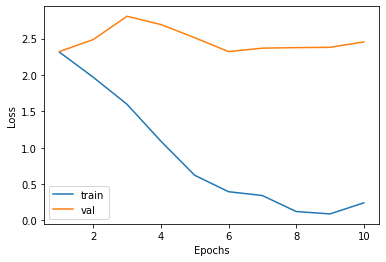

In [ ]:
## Train the model and validate it after each epoch.
## Provide the train-val loss graph.

# *****START CODE
from tqdm import tqdm
total_train_losses = []
total_val_losses = []

ff=open('{}/progress.txt'.format(save_folder),'w')

for epoch in range(1,epochs+1):
    ##TRAINING##
    model.train()
    train_losses = []
    confusion_matrix.reset()

    for i, batch in enumerate(tqdm(train_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch = img_batch.cuda(), lbl_batch.cuda()

        optimizer.zero_grad()
        output = model(img_batch.float())
        loss=criterion(output, lbl_batch.long())
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        confusion_matrix.add(output.data.squeeze(), lbl_batch.long())

        if i % 20 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item()))
            
    train_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)
    

     ##VALIDATION##
    model.eval()
    val_losses = []

    for i, batch, in enumerate(tqdm(test_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch = img_batch.cuda(), lbl_batch.cuda()
        outputs=model(img_batch.float())
        loss=criterion(outputs, lbl_batch.long())

        confusion_matrix.add(outputs.data.squeeze(), lbl_batch.long())
        val_losses.append(loss.item())

    print('Confusion Matrix:')
    print(confusion_matrix.conf)


    val_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    
    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean, 'TRAIN_ACC: ', '%.3f' % train_acc)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean, 'VAL_ACC: ', '%.3f' % val_acc)
    confusion_matrix.reset()

    write_results(save_folder, epoch, train_acc, val_acc, train_loss_mean, val_loss_mean)

    torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch))

total_results["resnet_18_no_train"] = [train_acc, val_acc]

save_graph(total_train_losses, total_val_losses, epochs, save_folder)
        

### Summary

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | 9 | 100.00 | 24.65 |

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 4 (3 points):__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 10

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  1%|▏         | 13/1000 [00:00<00:07, 125.44it/s]

Train (epoch 1/10) [0/10 (0%)]	Loss: 2.510409


100%|██████████| 1000/1000 [00:05<00:00, 171.85it/s]


Confusion Matrix:
[[  1 181   7 322 137 164   1  10   1 182]
 [  0 172  13 550  34 126   6  13   2 100]
 [  0  59   7 527 143 106   8  18   0 145]
 [  0  32   7 794  54  60   6   3   0  57]
 [  1  54   5 534 230  59   1   7   0 120]
 [  0  48   6 774  38  70  14  10   0  47]
 [  1  55   3 724  52  89  22   2   0  59]
 [  0  18   9 559 124 109  10  15   0 167]
 [  0 196  10 377 126 174   2  13   1 105]
 [  1 192  18 437  42 138   0  14   1 169]]
TRAIN_LOSS:  2.418 TRAIN_ACC:  17.000
VAL_LOSS:  2.298 VAL_ACC:  14.663


  2%|▏         | 18/1000 [00:00<00:05, 171.98it/s]

Train (epoch 2/10) [0/10 (0%)]	Loss: 2.646799


100%|██████████| 1000/1000 [00:05<00:00, 175.59it/s]


Confusion Matrix:
[[  2 313   9  93 537   3   2  12   0  35]
 [  3 541  19 207 190   1   9   6   3  37]
 [  0 227  14 157 584   2   7   8   0  14]
 [  0 206   9 372 401   1   9   2   0  13]
 [  0 137  10 163 684   1   3   4   0   9]
 [  1 254   7 384 326   3  12   8   0  12]
 [  4 263   5 216 487   1  19   3   0   9]
 [  1 135  31 247 529   2  12  17   0  37]
 [  0 363  11 139 466   4   1   4   1  15]
 [  4 534  17 189 219   5   3   3   0  38]]
TRAIN_LOSS:  2.258 TRAIN_ACC:  21.000
VAL_LOSS:  2.350 VAL_ACC:  16.743


  1%|          | 12/1000 [00:00<00:08, 117.89it/s]

Train (epoch 3/10) [0/10 (0%)]	Loss: 1.585459


100%|██████████| 1000/1000 [00:05<00:00, 167.73it/s]


Confusion Matrix:
[[ 12  44 310  60 110   3 198  89  12 168]
 [ 12 190 238 133  22   2 246  47   3 123]
 [ 10  33 287 107 166   1 251  54   0 104]
 [  2  34 229 256  68   1 275  78   0  70]
 [  8  27 301 139 262   1 173  40   0  60]
 [ 11  60 192 244  73   0 256 106   1  64]
 [  0  40 243 147 118   0 383  17   1  58]
 [  6  22 249 169 104   1 204 133   0 123]
 [  6  83 220 102  96   3 277  51  18 148]
 [ 13 181 222 143  31   4 172  65   4 177]]
TRAIN_LOSS:  1.866 TRAIN_ACC:  32.000
VAL_LOSS:  2.382 VAL_ACC:  17.010


  1%|          | 12/1000 [00:00<00:08, 115.90it/s]

Train (epoch 4/10) [0/10 (0%)]	Loss: 1.509105


100%|██████████| 1000/1000 [00:05<00:00, 168.55it/s]


Confusion Matrix:
[[  0 170 309  44 219  38  15  39  79  93]
 [  2 459 224  62  57  49  36  18  27  82]
 [  3 169 322  70 264  49  56  18  17  45]
 [  2 172 247 237 145  63  54  34   3  56]
 [  3 115 334  98 347  29  27  23   6  29]
 [  5 237 250 185 126  42  54  45  13  50]
 [  0 190 305 105 203  61 103   4   7  29]
 [  5 139 282 128 177  50  33  92  16  89]
 [  1 216 245  73 193  55  24  17 113  67]
 [  5 397 225  89  63  51  18  28  29 107]]
TRAIN_LOSS:  1.954 TRAIN_ACC:  29.000
VAL_LOSS:  2.431 VAL_ACC:  18.040


  2%|▏         | 18/1000 [00:00<00:05, 176.52it/s]

Train (epoch 5/10) [0/10 (0%)]	Loss: 1.671471


100%|██████████| 1000/1000 [00:05<00:00, 172.41it/s]


Confusion Matrix:
[[ 36  78 200  88 130  13  41 149  93 178]
 [ 32 318 118 139  20  22  70  84  43 170]
 [ 44  69 208 141 165  18  96 130  14 128]
 [ 25  93 115 338  51  24 102 135   9 121]
 [ 21  70 206 174 253  12  56 137  13  69]
 [ 30 114 100 266  61  17 101 190  11 117]
 [ 30  97 187 191 123  24 178  88  10  79]
 [ 24  62 135 187  87  17  56 267   5 171]
 [ 53 111 133 156  89  23  51  88 145 155]
 [ 29 264 109 137  28  19  42 106  28 250]]
TRAIN_LOSS:  1.641 TRAIN_ACC:  44.000
VAL_LOSS:  2.452 VAL_ACC:  19.901


  2%|▏         | 18/1000 [00:00<00:05, 178.62it/s]

Train (epoch 6/10) [0/10 (0%)]	Loss: 1.290050


100%|██████████| 1000/1000 [00:05<00:00, 169.37it/s]


Confusion Matrix:
[[ 10 437 229  17  92   5  24  78  52  62]
 [  3 740 132  26  14   4  24  35  16  22]
 [  7 437 263  26 140   5  56  54   5  20]
 [  3 495 178 138  41  10  57  61   1  29]
 [  4 374 297  48 181   2  33  61   3   8]
 [  8 534 167 101  43   8  51  82   1  12]
 [  2 507 242  47  74   7 102  16   3   7]
 [  8 376 211  78  68   8  33 185   2  42]
 [  9 524 174  34  64   8  33  43  87  28]
 [  5 691 129  27  18   5  19  43  16  59]]
TRAIN_LOSS:  1.566 TRAIN_ACC:  47.000
VAL_LOSS:  2.785 VAL_ACC:  17.554


  2%|▏         | 18/1000 [00:00<00:05, 173.32it/s]

Train (epoch 7/10) [0/10 (0%)]	Loss: 1.489885


100%|██████████| 1000/1000 [00:05<00:00, 170.81it/s]


Confusion Matrix:
[[  9  64  53  99 345   9  92 107  51 177]
 [  9 283  50 172  80  11 160  69  15 167]
 [  8  69  54 135 343  17 203  87   3  94]
 [  2  64  31 347 133  21 215 102   0  98]
 [  3  45  59 186 409  10 136  94   8  61]
 [  5  89  29 307 119  13 215 137   2  91]
 [  0  67  61 188 237  24 311  63   3  53]
 [  6  54  47 199 193  11 105 233   3 160]
 [ 11  89  38 146 244  16 159  51  99 151]
 [  9 225  52 141  94  12  98  89  15 277]]
TRAIN_LOSS:  1.484 TRAIN_ACC:  49.000
VAL_LOSS:  2.624 VAL_ACC:  20.149


  2%|▏         | 17/1000 [00:00<00:05, 168.29it/s]

Train (epoch 8/10) [0/10 (0%)]	Loss: 1.256542


100%|██████████| 1000/1000 [00:05<00:00, 167.48it/s]


Confusion Matrix:
[[  8  46 493  58 213  21  16  37  67  47]
 [  7 213 443 118  51  41  42  34  26  41]
 [  4  43 537  88 202  27  53  27  10  22]
 [  0  55 465 270  64  33  44  49   0  33]
 [  2  20 546 122 232  19  27  32   5   6]
 [  7  76 459 217  74  27  51  71   8  17]
 [  2  44 553 123 125  26 104  18   3   9]
 [ 11  38 440 170 100  24  32 149   6  41]
 [ 11  68 491  93 132  27  24  13 107  38]
 [ 10 187 448 115  47  29  22  47  23  84]]
TRAIN_LOSS:  1.598 TRAIN_ACC:  42.000
VAL_LOSS:  2.755 VAL_ACC:  17.139


  2%|▏         | 15/1000 [00:00<00:06, 149.41it/s]

Train (epoch 9/10) [0/10 (0%)]	Loss: 1.587019


100%|██████████| 1000/1000 [00:05<00:00, 168.71it/s]


Confusion Matrix:
[[ 10 362  67 127 116  16  10 110  76 112]
 [  5 650  20 134  12  26  21  58  24  66]
 [ 17 347  68 195 148  37  35  98  15  53]
 [  7 321  37 406  32  32  41  78   1  58]
 [  6 262  70 250 199  19  20 149   5  31]
 [  7 368  27 350  31  41  34 110   1  38]
 [  0 386  65 232  82  45  99  67   3  28]
 [  6 263  46 228  68  30  20 249   3  98]
 [ 14 387  23 208  70  28  19  61 116  78]
 [  6 565  29 149  19  17   9  58  17 143]]
TRAIN_LOSS:  1.393 TRAIN_ACC:  50.000
VAL_LOSS:  2.770 VAL_ACC:  19.614


  2%|▏         | 18/1000 [00:00<00:05, 179.32it/s]

Train (epoch 10/10) [0/10 (0%)]	Loss: 1.001444


100%|██████████| 1000/1000 [00:05<00:00, 172.10it/s]


Confusion Matrix:
[[ 14 233 127  66 158   7  14  35 135 217]
 [ 11 594  55  90  20  14  19  20  29 164]
 [ 19 262 176 112 180  21  49  37  25 132]
 [ 17 300 105 287  39  23  39  33   3 167]
 [  4 247 158 136 248  10  21  41  13 133]
 [  9 339  87 243  52  24  45  55   7 146]
 [  1 346 154 140 119  28 103  23  12  81]
 [  7 237 102 160  74  13  21 146   5 246]
 [ 30 292  71  98  85  11  21  17 187 192]
 [ 10 487  64 100  24  11   9  20  31 256]]
TRAIN_LOSS:  1.286 TRAIN_ACC:  60.000
VAL_LOSS:  2.730 VAL_ACC:  20.149


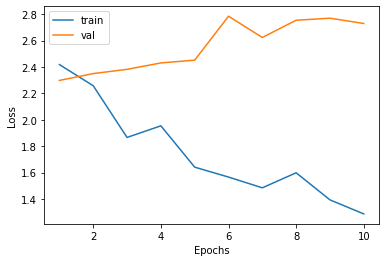

In [ ]:
from tqdm import tqdm
total_train_losses = []
total_val_losses = []

ff=open('{}/progress.txt'.format(save_folder),'w')

for epoch in range(1,epochs+1):
    ##TRAINING##
    model.train()
    train_losses = []
    confusion_matrix.reset()

    for i, batch in enumerate(tqdm(train_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch = img_batch.cuda(), lbl_batch.cuda()

        optimizer.zero_grad()
        output = model(img_batch.float())
        loss=criterion(output, lbl_batch.long())
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        confusion_matrix.add(output.data.squeeze(), lbl_batch.long())

        if i % 20 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item()))
            
    train_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)
    

     ##VALIDATION##
    model.eval()
    val_losses = []

    for i, batch, in enumerate(tqdm(test_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch = img_batch.cuda(), lbl_batch.cuda()
        outputs=model(img_batch.float())
        loss=criterion(outputs, lbl_batch.long())

        confusion_matrix.add(outputs.data.squeeze(), lbl_batch.long())
        val_losses.append(loss.item())

    print('Confusion Matrix:')
    print(confusion_matrix.conf)


    val_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    
    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean, 'TRAIN_ACC: ', '%.3f' % train_acc)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean, 'VAL_ACC: ', '%.3f' % val_acc)
    confusion_matrix.reset()

    write_results(save_folder, epoch, train_acc, val_acc, train_loss_mean, val_loss_mean)

    torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch))

total_results["resnet_18_pre_train"] = [train_acc, val_acc]

save_graph(total_train_losses, total_val_losses, epochs, save_folder)
        

In [ ]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096,10)
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 10

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


 30%|███       | 3/10 [00:00<00:01,  6.04it/s]

Train (epoch 1/10) [0/10 (0%)]	Loss: 2.531725


100%|██████████| 1000/1000 [00:09<00:00, 105.00it/s]


Confusion Matrix:
[[ 20 106   1 280  63  19   5 362  32 118]
 [  0 359   1 213   9   6   4 205   1 218]
 [ 10  87   5 489  76  36  13 240  20  37]
 [  0 125   2 602  35  51  12 139  20  27]
 [  0  39   1 686  49  30  13 112  43  38]
 [  0 100   1 591  25  36  10 219  15  10]
 [  0 123   0 626  28  37   7 154  24   8]
 [  0  55   4 509  51  25   6 281  18  62]
 [  1 178   2 382  48  29  15 110  51 188]
 [  0 215   1 277  15   6   1 126  17 354]]
TRAIN_LOSS:  2.757 TRAIN_ACC:  17.000
VAL_LOSS:  2.252 VAL_ACC:  17.465


 40%|████      | 4/10 [00:00<00:00, 18.42it/s]

Train (epoch 2/10) [0/10 (0%)]	Loss: 2.295459


100%|██████████| 1000/1000 [00:09<00:00, 103.62it/s]


Confusion Matrix:
[[ 67   5 384 145   1  18  10 301  74   1]
 [  7  45 107 372   8  34  16 412   8   7]
 [ 25   9 268 347   4  22  42 271  24   1]
 [  0   5  66 614   8  38  55 216  11   0]
 [  2   1 100 601   9  11  24 225  37   1]
 [  1   3  68 584   3  56  64 211  17   0]
 [  0   4  87 620   4  32  40 205  15   0]
 [  2   5 223 306   1  14  34 388  37   1]
 [  4  10 186 412   4  47  14 245  80   2]
 [  7  16 190 444  10   8   5 285  46   1]]
TRAIN_LOSS:  2.163 TRAIN_ACC:  21.000
VAL_LOSS:  2.262 VAL_ACC:  15.525


 50%|█████     | 5/10 [00:00<00:00, 18.76it/s]

Train (epoch 3/10) [0/10 (0%)]	Loss: 2.204848


100%|██████████| 1000/1000 [00:09<00:00, 101.61it/s]


Confusion Matrix:
[[ 80 447 125  64  13  15   4 180  13  65]
 [  3 913  25  46   3   3   1  17   0   5]
 [ 10 350 218 233  17  22  15 136   1  11]
 [  0 408 105 410  13  17  12  44   0   4]
 [  1 236 158 450  28  14   7 102   2  13]
 [  0 518  71 313   5  48   6  46   0   0]
 [  1 435 110 359   9  21  34  36   0   2]
 [  1 410 126 140   9  12   6 294   0  13]
 [  1 589 127 183  11  21   8  26   7  31]
 [  1 821  50  75   8   3   0  23   3  28]]
TRAIN_LOSS:  2.117 TRAIN_ACC:  20.000
VAL_LOSS:  2.164 VAL_ACC:  20.396


 40%|████      | 4/10 [00:00<00:00, 18.15it/s]

Train (epoch 4/10) [0/10 (0%)]	Loss: 1.746547


100%|██████████| 1000/1000 [00:09<00:00, 100.12it/s]


Confusion Matrix:
[[445 302   7   0   1  83  12  12  49  95]
 [  9 941   3   0   1  19  22   6   1  14]
 [190 283  85   7   7 224  52  95  14  56]
 [ 37 432  17  15   3 319 120  46   4  20]
 [ 57 332  61   6  11 349  53 117  16   9]
 [ 23 455   9   6   5 363  59  76   3   8]
 [ 36 473  55   4   6 255 113  48   6  11]
 [134 354   7   2   1 139  29 318   6  21]
 [ 80 511   4   2   0 167  37   4  96 103]
 [ 38 842   2   0   0  51   3  10  13  53]]
TRAIN_LOSS:  1.732 TRAIN_ACC:  41.000
VAL_LOSS:  2.180 VAL_ACC:  24.158


 40%|████      | 4/10 [00:00<00:00, 18.23it/s]

Train (epoch 5/10) [0/10 (0%)]	Loss: 1.446526


100%|██████████| 1000/1000 [00:10<00:00, 99.51it/s]


Confusion Matrix:
[[154 388  46  13  34 108   3  93 127  40]
 [  2 959   0  10   4  12   1  10   4  14]
 [ 33 184 127  98 102 175  11 236  36  11]
 [  9 300  22 213  49 279  23 103   8   7]
 [  3 172  15 118 174 285   6 218  10  10]
 [  5 334  17 221  37 241   6 142   4   0]
 [  5 393  13 141  45 282  21 101   6   0]
 [ 12 191   8  57  64 103   4 551   8  13]
 [ 13 581  32  35  38  84   2  20 117  82]
 [  4 884   3  20  11  22   0  18  18  32]]
TRAIN_LOSS:  1.671 TRAIN_ACC:  46.000
VAL_LOSS:  2.081 VAL_ACC:  25.634


 40%|████      | 4/10 [00:00<00:00, 18.08it/s]

Train (epoch 6/10) [0/10 (0%)]	Loss: 1.344902


100%|██████████| 1000/1000 [00:10<00:00, 97.51it/s]


Confusion Matrix:
[[ 96 200  55 270   0  14  22   0 254  95]
 [  1 661   1 210   1   0  99   0   6  37]
 [ 26  44 188 548  12  11 102  11  54  17]
 [  3  33  15 827   3   9 104   3   8   8]
 [  5  21  67 803  27   6  37  14  16  15]
 [  2  28  20 891   1  13  43   3   5   1]
 [  1  24  20 704   1   3 249   1   3   1]
 [ 11  35  77 623  10  15  35 151  28  26]
 [  2 316  12 371   0   0  56   1 140 106]
 [  1 502   1 325   0   1  12   0  24 146]]
TRAIN_LOSS:  1.127 TRAIN_ACC:  62.000
VAL_LOSS:  2.935 VAL_ACC:  24.733


 40%|████      | 4/10 [00:00<00:00, 18.40it/s]

Train (epoch 7/10) [0/10 (0%)]	Loss: 2.094977


100%|██████████| 1000/1000 [00:10<00:00, 99.07it/s]


Confusion Matrix:
[[315   7  23   8  50  74   1 231 292   5]
 [ 96 333   6  60  42 194  30 157  84  14]
 [ 81   3  92  48 135 129   6 455  64   0]
 [ 36   9  37 208 102 367  13 206  34   1]
 [ 15   1  41  41 382 112   7 395  17   0]
 [ 20   9  10 155  68 468   2 252  23   0]
 [ 18  10  75 157 172 273  41 214  46   1]
 [ 30   0  11  11  69  95   0 782  13   0]
 [125  73  46  51 100 130   3 104 348  24]
 [135 127   3 101  85 203   3 158 138  59]]
TRAIN_LOSS:  1.145 TRAIN_ACC:  67.000
VAL_LOSS:  2.115 VAL_ACC:  29.980


 50%|█████     | 5/10 [00:00<00:00, 18.33it/s]

Train (epoch 8/10) [0/10 (0%)]	Loss: 0.923396


100%|██████████| 1000/1000 [00:10<00:00, 97.60it/s]


Confusion Matrix:
[[ 23  80 310  18  16  18   1  42   4 494]
 [  5 748  10  17   1   0  27   6   0 202]
 [  4  42 522 117  71  13  17 143   3  81]
 [  2  97 180 451  25  45  45  80   2  86]
 [  1  20 380  99 166  10  10 215   1 109]
 [  2  99 136 544  29  45  17 109   0  26]
 [  1  77 304 343  67  31 103  54   1  26]
 [  5  32 149  74  15  12   5 602   1 116]
 [  5 222  95  32   3  10   8   4   9 616]
 [  2 313  17  23   2   0   3   3   1 648]]
TRAIN_LOSS:  0.656 TRAIN_ACC:  80.000
VAL_LOSS:  2.526 VAL_ACC:  32.842


 50%|█████     | 5/10 [00:00<00:00, 18.85it/s]

Train (epoch 9/10) [0/10 (0%)]	Loss: 0.587172


100%|██████████| 1000/1000 [00:10<00:00, 96.57it/s]


Confusion Matrix:
[[235 102  26  34   8  63   3  47 290 198]
 [  5 901   1  28   0   8  11   3  21  38]
 [ 79  56 189 136 123 124  32 177  40  57]
 [ 18 140  29 444  35 192  38  64  14  39]
 [ 12  28  44 221 318  92  13 219  23  41]
 [ 11 155  28 350  44 260  20 118   3  18]
 [  7 119  53 326  95 188 159  27  14  19]
 [ 30  50  24  87  29  83   6 617  19  66]
 [ 24 286  13 110   7  30   8   5 311 210]
 [  6 584   1  74   3  15   2   1  69 257]]
TRAIN_LOSS:  0.539 TRAIN_ACC:  84.000
VAL_LOSS:  2.304 VAL_ACC:  36.545


 40%|████      | 4/10 [00:00<00:00, 18.12it/s]

Train (epoch 10/10) [0/10 (0%)]	Loss: 0.149204


100%|██████████| 1000/1000 [00:10<00:00, 94.66it/s]


Confusion Matrix:
[[517  57  28  11   6  20   3   4 132 228]
 [ 32 816   1  10   0  14  23   1   8 111]
 [205  54 320  55  92  73  41  49  12 112]
 [ 85 157  93 287  23 160  67  40   6  95]
 [ 86  31 210  83 312  72  19 129  17  52]
 [ 90 172  87 233  37 234  43  69   4  38]
 [ 52 119 168 145  99 118 206  10   6  84]
 [176  44  86  30  40  80   9 442   8  96]
 [126 203  33  26   9  19  10   1 255 322]
 [ 58 390   6  26   2  13   3   0  40 474]]
TRAIN_LOSS:  0.147 TRAIN_ACC:  98.000
VAL_LOSS:  2.375 VAL_ACC:  38.248


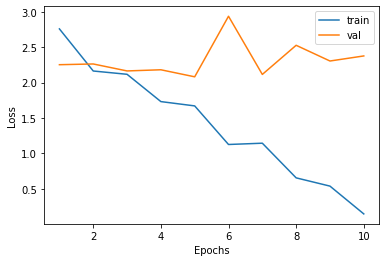

In [ ]:
from tqdm import tqdm
total_train_losses = []
total_val_losses = []

ff=open('{}/progress.txt'.format(save_folder),'w')

for epoch in range(1,epochs+1):
    ##TRAINING##
    model.train()
    train_losses = []
    confusion_matrix.reset()

    for i, batch in enumerate(tqdm(train_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch = img_batch.cuda(), lbl_batch.cuda()

        optimizer.zero_grad()
        output = model(img_batch.float())
        loss=criterion(output, lbl_batch.long())
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        confusion_matrix.add(output.data.squeeze(), lbl_batch.long())

        if i % 20 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item()))
            
    train_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)
    

     ##VALIDATION##
    model.eval()
    val_losses = []

    for i, batch, in enumerate(tqdm(test_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch = img_batch.cuda(), lbl_batch.cuda()
        outputs=model(img_batch.float())
        loss=criterion(outputs, lbl_batch.long())

        confusion_matrix.add(outputs.data.squeeze(), lbl_batch.long())
        val_losses.append(loss.item())

    print('Confusion Matrix:')
    print(confusion_matrix.conf)


    val_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    
    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean, 'TRAIN_ACC: ', '%.3f' % train_acc)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean, 'VAL_ACC: ', '%.3f' % val_acc)
    confusion_matrix.reset()

    write_results(save_folder, epoch, train_acc, val_acc, train_loss_mean, val_loss_mean)

    torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch))

total_results["vgg_16_pre_train"] = [train_acc, val_acc]

save_graph(total_train_losses, total_val_losses, epochs, save_folder)
        

In [ ]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(1024, 10)
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 10

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


 40%|████      | 4/10 [00:00<00:00, 14.79it/s]

Train (epoch 1/10) [0/10 (0%)]	Loss: 2.500803


  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[ 53 344 127 261  22   2  15  39  13 130]
 [ 67 542  66 105   3   2  23  18   4 186]
 [ 53 207  70 211  11   2  10   9   4 436]
 [ 41 263  74 184   2   2   6   9   1 431]
 [ 61 228 113 157   8   1  13   9   6 415]
 [ 35 372  64 119   0   2   8   8   0 399]
 [ 25 110  29 152   0   0   2   4   1 684]
 [ 68 373 151 121   8   0  12  52   2 224]
 [ 69 378 150 223   4   2  24  13  11 130]
 [ 67 532  53 103   3   1  12  18   4 219]]
TRAIN_LOSS:  2.350 TRAIN_ACC:  18.000
VAL_LOSS:  2.456 VAL_ACC:  11.317


 20%|██        | 2/10 [00:00<00:00, 13.49it/s]

Train (epoch 2/10) [0/10 (0%)]	Loss: 1.662963


  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[ 12 142 200 417  70  17   4  21  16 107]
 [  6 471  97 239  28  19   7   4   4 141]
 [  5 101 414 363  76  18  11   6   1  18]
 [  4 118 363 411  49  28  11  10   1  18]
 [  4 174 333 287 123  26  18  15   2  29]
 [  4 170 290 432  33  28  10  17   0  23]
 [  1  91 526 310  31   8  15  10   0  15]
 [  2 220 200 340  94  30  12  70   0  43]
 [  9 250  85 391  41  10   8   2  14 194]
 [  4 416  65 272  28  21   8   4   0 194]]
TRAIN_LOSS:  1.938 TRAIN_ACC:  36.000
VAL_LOSS:  2.434 VAL_ACC:  17.347


 40%|████      | 4/10 [00:00<00:00, 14.23it/s]

Train (epoch 3/10) [0/10 (0%)]	Loss: 1.294502


  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[ 62  35 262 274  55   6   9  76 112 115]
 [ 45 467  53 185  29  19  35  25  35 123]
 [ 22  49 407 216  66  28 134  39  16  36]
 [ 20  62 175 409  55  41 142  72   6  31]
 [ 11  60 313 233 132  35  70  98  11  48]
 [ 20 112 185 325  53  53 149  64   9  37]
 [  4  55 157 208 113  28 376  45   2  19]
 [ 25  73 179 267  67  35  39 275   5  46]
 [ 78 143 117 270  25   7  20  19 139 186]
 [ 52 295  64 222  37  19  26  41  30 226]]
TRAIN_LOSS:  1.425 TRAIN_ACC:  50.000
VAL_LOSS:  2.156 VAL_ACC:  25.208


 20%|██        | 2/10 [00:00<00:00, 14.60it/s]

Train (epoch 4/10) [0/10 (0%)]	Loss: 1.376559


  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[100  64 252 194  69  51   2  80  67 127]
 [ 37 579  22 135  23  75   4  19  12 110]
 [ 52  65 357 188  86 119   8  62  12  64]
 [ 17  84 132 338  49 213   8  93   7  72]
 [ 17  58 201 151 221 152   8 144   4  55]
 [ 34 106 134 274  70 202  12 106   9  60]
 [ 14  65 144 238 207 180  36  83   0  40]
 [ 46 108 126 179  65  81   0 327   2  77]
 [134 239  63 195  30  38   2  19  90 194]
 [ 46 402  29 163  22  67   4  37  11 231]]
TRAIN_LOSS:  1.191 TRAIN_ACC:  64.000
VAL_LOSS:  2.155 VAL_ACC:  24.564


 40%|████      | 4/10 [00:00<00:00, 14.81it/s]

Train (epoch 5/10) [0/10 (0%)]	Loss: 0.732522


  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[110  65 240 208  54  24   2  26 142 135]
 [ 18 551  30 143  23  47   4   8  22 170]
 [ 42  67 296 257 130  73  16  30  34  68]
 [ 24  72 113 466  69 135  25  36   8  65]
 [ 16  71 158 242 298  65  10  85   9  57]
 [ 17 135 105 411  61 130  16  48  12  72]
 [  8  77 118 257 245 101 124  15   5  57]
 [ 31 137  94 268  96  43   0 239   6  97]
 [102 204 100 169  22  20   2   4 188 193]
 [ 37 369  33 153  29  40   1   5  28 317]]
TRAIN_LOSS:  0.881 TRAIN_ACC:  76.000
VAL_LOSS:  2.171 VAL_ACC:  26.921


 40%|████      | 4/10 [00:00<00:00, 14.15it/s]

Train (epoch 6/10) [0/10 (0%)]	Loss: 0.367108


  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[133  60 397  38  72  22  20  30  42 192]
 [ 19 496  67  45  55  93  15  22   6 198]
 [ 36  30 390  67 170  95 139  33   3  50]
 [ 17  50 206 176 104 222 142  50   2  44]
 [ 16  44 171  62 414  92 100  72   3  37]
 [ 24  83 243 117 122 189 115  53   2  59]
 [  4  44 129  45 357 117 263  26   2  20]
 [ 26  78 200  72 176 106  29 232   1  91]
 [116 188 178  39  45  52  12  11  63 300]
 [ 34 292  84  45  62 106   6  22  12 349]]
TRAIN_LOSS:  0.677 TRAIN_ACC:  83.000
VAL_LOSS:  2.298 VAL_ACC:  26.782


 40%|████      | 4/10 [00:00<00:00, 14.73it/s]

Train (epoch 7/10) [0/10 (0%)]	Loss: 0.787776


  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[183  74 246  75  65  11   3  48  77 224]
 [ 21 560  44  72  45  35   8  20   7 204]
 [ 63  51 347 108 184  70  37  58  18  77]
 [ 19  61 168 267 152 118  51 104   4  69]
 [ 26  55 188  83 416  35  24 118   2  64]
 [ 21 121 191 220 125 124  41 108   6  50]
 [  8  44 132  70 429  74 155  49   2  44]
 [ 42  89 145 125 144  38   4 330   1  93]
 [133 241 103  62  31  12   4  10  85 323]
 [ 40 343  54  54  66  33   2  18  15 387]]
TRAIN_LOSS:  0.630 TRAIN_ACC:  82.000
VAL_LOSS:  2.232 VAL_ACC:  28.257


 20%|██        | 2/10 [00:00<00:00, 14.33it/s]

Train (epoch 8/10) [0/10 (0%)]	Loss: 0.632587


100%|██████████| 1000/1000 [00:20<00:00, 49.11it/s]


Confusion Matrix:
[[176  46 187  24  37  28   2  11 235 260]
 [ 21 361  61  43  37  41  19   8  33 392]
 [ 72  57 362  71 112  78  35  39  58 129]
 [ 51  82 215 177  64 148  55  49   9 163]
 [ 44  73 227  63 270  58  34  76  17 149]
 [ 46 138 232 107  77 135  42  81  15 134]
 [ 15  71 188 101 282  71 144  31   3 101]
 [152  95 137  61  80  44   5 177  10 250]
 [127  94  91  21  16  17   4   3 199 432]
 [ 61 164  39  18  31  35   8   5  36 615]]
TRAIN_LOSS:  0.501 TRAIN_ACC:  87.000
VAL_LOSS:  2.314 VAL_ACC:  25.901


 40%|████      | 4/10 [00:00<00:00, 14.92it/s]

Train (epoch 9/10) [0/10 (0%)]	Loss: 0.195646


100%|██████████| 1000/1000 [00:19<00:00, 50.33it/s]


Confusion Matrix:
[[ 74  32 230 143  72  18   0  46  47 344]
 [  5 270  38  81  45  66   7  20   3 481]
 [ 23  41 231 190 201 100   8  60   3 156]
 [  9  62  93 330  92 203  12  57   1 154]
 [  5  33 113 127 345 107   5 126   2 148]
 [ 10 126 116 289 102 195   5  71   0  93]
 [  4  76 139 173 334 107  51  39   0  84]
 [ 18  56  85 138 118  77   1 291   0 227]
 [ 39  92  64  82  49  20   0  10  65 583]
 [ 10  82  27  40  41  61   1   6   2 742]]
TRAIN_LOSS:  0.447 TRAIN_ACC:  88.000
VAL_LOSS:  2.473 VAL_ACC:  25.683


 20%|██        | 2/10 [00:00<00:00, 14.92it/s]

Train (epoch 10/10) [0/10 (0%)]	Loss: 0.469849


100%|██████████| 1000/1000 [00:20<00:00, 49.98it/s]


Confusion Matrix:
[[112  41 306  69 144  34   9  25  75 191]
 [ 34 291  65  94 127  86  30  12   6 271]
 [ 49  15 275 127 323 117  32  15   5  55]
 [ 17  32 177 285 170 184  47  43   0  58]
 [ 16  24 129 103 544  62  33  62   3  35]
 [ 28  77 139 225 189 234  30  38   2  45]
 [  7  33 103  92 516 105  98  28   0  25]
 [ 46  60 144 120 261  89   6 165   1 119]
 [ 88  98 108  83 113  49  10   5 106 344]
 [ 25 163  45  61  93  78  16  12  10 509]]
TRAIN_LOSS:  0.460 TRAIN_ACC:  89.000
VAL_LOSS:  2.489 VAL_ACC:  25.931


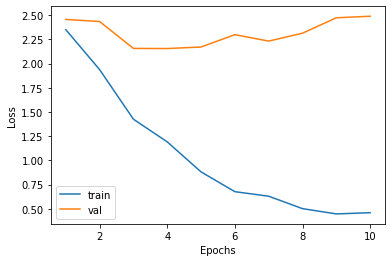

In [ ]:
total_train_losses = []
total_val_losses = []

ff=open('{}/progress.txt'.format(save_folder),'w')

for epoch in range(1,epochs+1):
    ##TRAINING##
    model.train()
    train_losses = []
    confusion_matrix.reset()

    for i, batch in enumerate(tqdm(train_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch = img_batch.cuda(), lbl_batch.cuda()

        optimizer.zero_grad()
        output = model(img_batch.float())
        loss=criterion(output, lbl_batch.long())
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        confusion_matrix.add(output.data.squeeze(), lbl_batch.long())

        if i % 20 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item()))
            
    train_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)
    

     ##VALIDATION##
    model.eval()
    val_losses = []

    for i, batch, in enumerate(tqdm(test_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch = img_batch.cuda(), lbl_batch.cuda()
        outputs=model(img_batch.float())
        loss=criterion(outputs, lbl_batch.long())

        confusion_matrix.add(outputs.data.squeeze(), lbl_batch.long())
        val_losses.append(loss.item())

    print('Confusion Matrix:')
    print(confusion_matrix.conf)


    val_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    
    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean, 'TRAIN_ACC: ', '%.3f' % train_acc)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean, 'VAL_ACC: ', '%.3f' % val_acc)
    confusion_matrix.reset()

    write_results(save_folder, epoch, train_acc, val_acc, train_loss_mean, val_loss_mean)

    torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch))

total_results["densenet_121_pre_train"] = [train_acc, val_acc]

save_graph(total_train_losses, total_val_losses, epochs, save_folder)

### Summary

| Model | Number of  epoch  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | 10 | 89.00 | 25.93 |

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5 (1.5 points):__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

The solution for the problem of the training procedure (small data) has been touched upon in Question 2. However, although bringing many advantages (e.g. data invariance), data augmentations also carry their own issues. 

Each augmentation comes with a factor by which it increases the dataset. Ergo, issues include additional memory usage, thus higher compute costs on cloud platforms, and also added training time. This is hard to work around except that one should only do a necessary number of augmentations. Also, using too many augmentations together may simply create an entirely new observation that has nothing in common with the original image. 

Some transformations, such as translation or random cropping, need to be manually observed to make sure they have not altered the label of the image, while colour changes may additionally discard important color information and thus are not always a label-preserving transformation.

In some cases features of reality (changes in seasons) can't be captured by image augmentations. In such cases a conditional GAN or Neural Style Transfers can be employed to create these conditions.

Sometimes the above-mentioned augmentations also require to preserve the original image size. In e.g. fine rotations this then requires to make assumptions for what is beyond the image boundaries. These could include assuming a constant value, edge extensions, reflections (in more natural contexts), symmetric copies of pixel values at the border, or an image repetition/wrap. 






## Data augmentations

__Question 6 (3 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = datasets.CIFAR10(root='./cifar10_data/', train=True, transform=transform_train, download=True)
to_choose = list(range(0, 100))
train_dataset = torch.utils.data.Subset(train_dataset, to_choose)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)


test_dataset = datasets.CIFAR10(root='./cifar10_data_test/', train=False, transform=transform_test, download=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = ResNet18()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 30


 60%|██████    | 6/10 [00:00<00:00, 27.02it/s]

Train (epoch 1/30) [0/10 (0%)]	Loss: 2.359898



100%|██████████| 10/10 [00:00<00:00, 27.78it/s]

100%|██████████| 1000/1000 [00:07<00:00, 126.40it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[116 106   3   1   0   3   1   0 776   0]
 [204 276   2   3   5  10   0   3 511   2]
 [379 221   2   2   4  34   4   6 360   1]
 [284 353   4   3   4  23   4   3 334   1]
 [514 226   3   1   6  33   3   7 216   2]
 [222 327   5   2   2  27   8   2 412   0]
 [530 245   4   1   8  36  11   3 168   1]
 [225 345  10   2   2  31   6   0 390   0]
 [118  91   1   1   0   4   0   0 787   2]
 [121 211   0   5   4  15   0   4 651   1]]
TRAIN_LOSS:  2.938 TRAIN_ACC:  13.000
VAL_LOSS:  5.451 VAL_ACC:  12.168



 80%|████████  | 8/10 [00:00<00:00, 39.11it/s]

Train (epoch 2/30) [0/10 (0%)]	Loss: 2.116349


100%|██████████| 10/10 [00:00<00:00, 38.18it/s]

100%|██████████| 1000/1000 [00:08<00:00, 124.39it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[619   2 187   3   2   0   0   3 190   0]
 [794   5 104   2   1   1   0   1 105   3]
 [672  10 192  15  40   0   7  10  66   1]
 [648  10 218  15  10   1   9   7  91   4]
 [652  14 242  12  45   0   9   5  30   2]
 [699  12 172  19  12   0   2   7  81   3]
 [690  12 197  23  35   1   4   6  34   5]
 [792   6 103  23  14   0   2   5  64   2]
 [671   2 143   8   0   0   0   0 178   2]
 [734   1 117   7   0   1   0   3 146   3]]
TRAIN_LOSS:  2.412 TRAIN_ACC:  16.000
VAL_LOSS:  8.306 VAL_ACC:  10.554



 50%|█████     | 5/10 [00:00<00:00, 40.24it/s]

Train (epoch 3/30) [0/10 (0%)]	Loss: 1.951068



100%|██████████| 10/10 [00:00<00:00, 38.48it/s]

100%|██████████| 1000/1000 [00:07<00:00, 126.14it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[ 89  11   9   4  17   0   0   1 871   4]
 [131  58   6   7  16   0   0   3 790   5]
 [113  83  89   1 230   0   6  24 457  10]
 [132  94  68   7  99   0   2  17 575  19]
 [151  74  94   2 343   0   7  30 297  13]
 [ 99  68  59   1  98   0   1  23 638  20]
 [ 90 105  99   1 340   0   9  43 305  15]
 [112  61  45   4 105   0   0  25 650   9]
 [ 71   5   0   2  10   0   0   0 912   4]
 [ 91  20   7   4   5   0   0  11 866   8]]
TRAIN_LOSS:  2.100 TRAIN_ACC:  27.000
VAL_LOSS:  9.955 VAL_ACC:  15.248



 80%|████████  | 8/10 [00:00<00:00, 38.18it/s]

Train (epoch 4/30) [0/10 (0%)]	Loss: 1.597177


100%|██████████| 10/10 [00:00<00:00, 36.29it/s]

100%|██████████| 1000/1000 [00:08<00:00, 119.70it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[382  62   9   2  18   6   1   5 455  66]
 [308 281  15   2  13   4   0  22 199 172]
 [149 178  80  17 217  21   0  38 169 144]
 [122 348  32  20  64  24   0  52 140 211]
 [ 72 144  87  33 324  37   6  70  98 140]
 [188 319  43  11  74  12   1  47 142 170]
 [ 67 146 117  36 268  33   5  81  36 218]
 [262 183  42  20  95   3   0  75  82 249]
 [381  92   2   0   6   5   0   4 406 108]
 [366 115   7   2   6   3   0  16 158 339]]
TRAIN_LOSS:  1.974 TRAIN_ACC:  28.000
VAL_LOSS:  3.937 VAL_ACC:  19.050



 80%|████████  | 8/10 [00:00<00:00, 38.06it/s]

Train (epoch 5/30) [0/10 (0%)]	Loss: 1.935187


100%|██████████| 10/10 [00:00<00:00, 35.73it/s]

100%|██████████| 1000/1000 [00:08<00:00, 123.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[174  92  77  69   9   0   2  22  22 539]
 [ 44 371  76 126   0   2   1  35   3 358]
 [ 65 139 205 158 112   0  48 103   9 174]
 [ 71 225 127 285  31   0  14 118   2 140]
 [ 42 123 163 201 137   1  54 191   2  97]
 [109 185 175 241  29   1  18 117   0 132]
 [ 31 189 160 194 107   0  53 198   1  74]
 [ 91 160  99 148  30   1   6 214   0 262]
 [ 99 155  38  65   3   0   1  16  18 609]
 [ 33 158  36 120   2   0   0  35   2 626]]
TRAIN_LOSS:  1.871 TRAIN_ACC:  34.000
VAL_LOSS:  2.712 VAL_ACC:  20.634



 50%|█████     | 5/10 [00:00<00:00, 40.82it/s]


Train (epoch 6/30) [0/10 (0%)]	Loss: 1.721120


100%|██████████| 10/10 [00:00<00:00, 38.50it/s]

100%|██████████| 1000/1000 [00:08<00:00, 121.71it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[  8  44  50  26  16   0   8  50 708  96]
 [  4 295  84  68  23   0  20  47 343 132]
 [  5  86 239 107 175   0  95  55 205  46]
 [  4  96 230 183 176   0  86  54 122  62]
 [  6  69 239 109 250   0 156  39 127  16]
 [  4  85 274 208 133   1  85  44 121  52]
 [  4 110 252 105 286   0 145  35  32  38]
 [  3  79 162 127 122   0  72 248 123  75]
 [ 14  75  29  35  13   0   6  26 700 106]
 [  4 115  56  69  19   0  18 137 334 260]]
TRAIN_LOSS:  1.840 TRAIN_ACC:  36.000
VAL_LOSS:  2.781 VAL_ACC:  23.059



 80%|████████  | 8/10 [00:00<00:00, 36.95it/s]

Train (epoch 7/30) [0/10 (0%)]	Loss: 1.959873


100%|██████████| 10/10 [00:00<00:00, 35.89it/s]

100%|██████████| 1000/1000 [00:08<00:00, 123.81it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[412 167  48  34  10   6   2  17 226  84]
 [199 600  66  31   4  11   0  10  15  80]
 [135 210 275 138 130  11  22  17  53  22]
 [106 379 187 190  66   6  27   9   8  35]
 [ 51 194 251 170 231   5  26  27  23  33]
 [105 390 228 163  47  10  24   6   8  26]
 [ 67 257 270 165 195   6  27   4   1  15]
 [182 253 241 106  66   3  18 111   5  26]
 [314 313  33  32   4   2   0  13 147 146]
 [326 345  57  36   4   9   3  53  13 166]]
TRAIN_LOSS:  1.660 TRAIN_ACC:  39.000
VAL_LOSS:  2.730 VAL_ACC:  21.475



 80%|████████  | 8/10 [00:00<00:00, 38.45it/s]

Train (epoch 8/30) [0/10 (0%)]	Loss: 1.493520


100%|██████████| 10/10 [00:00<00:00, 37.83it/s]

100%|██████████| 1000/1000 [00:07<00:00, 127.31it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[259 186  84  42  59   0   0  28 146 202]
 [ 95 355  68  80  70   0   1  32   6 309]
 [102  77 136  53 442   0   5  76  35  87]
 [ 88 110 172 113 331   1   4  93   0 101]
 [ 45  88  73  75 569   0   3  99   8  51]
 [105 101 216  90 313   0  10  89   1  82]
 [ 62  63 108  57 528   0   4 113   1  71]
 [122  78 128  69 253   0   1 239   3 118]
 [117 235  55  48  43   0   1   9  88 408]
 [107 160  64  78  53   1   1  42  11 495]]
TRAIN_LOSS:  1.667 TRAIN_ACC:  37.000
VAL_LOSS:  2.755 VAL_ACC:  22.356



 80%|████████  | 8/10 [00:00<00:00, 38.85it/s]

Train (epoch 9/30) [0/10 (0%)]	Loss: 1.762176


100%|██████████| 10/10 [00:00<00:00, 36.76it/s]

100%|██████████| 1000/1000 [00:08<00:00, 122.90it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[ 11  72  22  67   6   0  21  16 788   3]
 [ 29 299  15 173   3   0  11  38 434  14]
 [ 41  62  65 176 188   1 110  63 305   2]
 [ 29 100  44 368  50   0  81  60 275   6]
 [ 45  35  51 205 247   0 188  76 160   4]
 [ 25 108  45 328  49   0  67  57 324   4]
 [ 66  55  70 225 202   0 182  94 110   3]
 [ 23 147  23 204  62   0  62 229 257   4]
 [  4  82  19  79   3   0   4   5 799   9]
 [  9 193   8 152   6   0   9  55 550  30]]
TRAIN_LOSS:  1.678 TRAIN_ACC:  37.000
VAL_LOSS:  3.591 VAL_ACC:  22.079



 80%|████████  | 8/10 [00:00<00:00, 36.16it/s]

Train (epoch 10/30) [0/10 (0%)]	Loss: 1.591435


100%|██████████| 10/10 [00:00<00:00, 34.66it/s]

100%|██████████| 1000/1000 [00:08<00:00, 122.73it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[254  88  17 151  54   8  34  38 290  72]
 [168 388  32 131  74  29  10  34  29 121]
 [160  50  43 163 450   6  41  26  63  11]
 [190  76  36 271 312  15  49  31  17  16]
 [154  40  19 134 562   6  11  33  42  10]
 [142  71  36 291 321  20  64  38  14  10]
 [132  34  13 158 580   2  54  25   5   4]
 [181  63  22 168 344   5  31 174   8  15]
 [168 174  10 135  38   5  18  13 208 235]
 [155 200  32 127  80  24  33  90  35 236]]
TRAIN_LOSS:  1.568 TRAIN_ACC:  45.000
VAL_LOSS:  2.998 VAL_ACC:  21.881



 80%|████████  | 8/10 [00:00<00:00, 38.51it/s]

Train (epoch 11/30) [0/10 (0%)]	Loss: 1.448296


100%|██████████| 10/10 [00:00<00:00, 37.31it/s]

100%|██████████| 1000/1000 [00:08<00:00, 121.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[322  32   8  57  29   0   3  22 456  77]
 [286 270  15 108  16   5   5  43 128 140]
 [166  88  71 136 320   8  24  58 119  23]
 [243  82  40 282 190   8  17  69  45  37]
 [116  58  49 126 438   6  36  73  74  35]
 [257  84  35 262 192   9  18  57  60  33]
 [151  83  67 134 431   6  46  61  11  17]
 [239  88  25 144 145   4  15 264  48  39]
 [244  64   8  65  12   2   3   7 482 117]
 [274 112  12  90  15   5   5  78 133 288]]
TRAIN_LOSS:  1.528 TRAIN_ACC:  50.000
VAL_LOSS:  2.926 VAL_ACC:  24.475



 80%|████████  | 8/10 [00:00<00:00, 36.21it/s]

Train (epoch 12/30) [0/10 (0%)]	Loss: 0.948279


100%|██████████| 10/10 [00:00<00:00, 35.19it/s]

100%|██████████| 1000/1000 [00:08<00:00, 115.35it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[275  54  79  26  15   0   6  32 355 164]
 [102 321 121  89  10   0   9  17 145 202]
 [115  54 268 108 231   0  46  34  98  59]
 [128  97 285 190 117   0  53  36  45  62]
 [ 63  33 260  90 358   0  62  43  73  29]
 [116 116 250 181 113   0  60  41  36  94]
 [ 84  31 273 141 341   0  72  37  11  17]
 [118  93 163 122 113   0  48 216  42  96]
 [117 108  50  26  10   0   6  12 356 319]
 [100 134  96  61  10   0  16  56 130 409]]
TRAIN_LOSS:  1.471 TRAIN_ACC:  48.000
VAL_LOSS:  2.940 VAL_ACC:  24.406



 50%|█████     | 5/10 [00:00<00:00, 40.10it/s]

Train (epoch 13/30) [0/10 (0%)]	Loss: 2.014410



100%|██████████| 10/10 [00:00<00:00, 37.84it/s]

100%|██████████| 1000/1000 [00:08<00:00, 119.37it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[195  34  33  59  13   4   7  62 493 106]
 [168 320  30  79   7  16  10  95 121 170]
 [111  39 127 193 171  21 103  82 138  28]
 [124  94  67 339  70  44  74  86  61  54]
 [ 88  15  61 225 258  18 150  89  80  27]
 [137  89  79 304  62  32  75  95  71  63]
 [125  22  98 225 248  25 151  75  16  22]
 [169  62  52 173  59  21  55 321  58  41]
 [120 112  18  51   3   4   6  34 478 178]
 [134 134  26  74   2  13  14 159 137 319]]
TRAIN_LOSS:  1.587 TRAIN_ACC:  38.000
VAL_LOSS:  2.877 VAL_ACC:  25.149



 80%|████████  | 8/10 [00:00<00:00, 37.83it/s]

Train (epoch 14/30) [0/10 (0%)]	Loss: 1.156419


100%|██████████| 10/10 [00:00<00:00, 35.78it/s]

100%|██████████| 1000/1000 [00:08<00:00, 118.91it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[105  52  77 348  51   0  17  70 228  58]
 [ 44 300  81 308  23  16  31  58  15 140]
 [ 91  31 130 206 336  22  32 107  45  13]
 [ 34  57 111 309 224  35  80 141   1  21]
 [ 79  30  51 176 425   7  39 184  14   6]
 [ 50  47 145 256 241  31  56 161   2  18]
 [ 56  35 123 146 412  31  55 144   0   5]
 [ 96  40  94 153 151  18  45 389   3  22]
 [ 33  81  63 480  31   6  16  36 127 131]
 [ 35 125 109 275  21  21  51 104  16 255]]
TRAIN_LOSS:  1.618 TRAIN_ACC:  36.000
VAL_LOSS:  3.053 VAL_ACC:  21.050



 80%|████████  | 8/10 [00:00<00:00, 35.30it/s]

Train (epoch 15/30) [0/10 (0%)]	Loss: 1.159676


100%|██████████| 10/10 [00:00<00:00, 35.47it/s]

100%|██████████| 1000/1000 [00:08<00:00, 119.16it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[176  65  29  93  14   0   2  36 421 170]
 [147 389  46  96   3   0   6  33  90 206]
 [ 99  54 146 253 233   0  17  47 114  50]
 [129 141 120 408  59   2  25  22  57  50]
 [ 60  45 102 288 316   0  11  79  71  39]
 [131 121 143 392  63   0  12  39  46  60]
 [ 83  59 175 346 255   0  27  27  14  21]
 [136 105  95 221  67   0  23 250  53  61]
 [ 71 150  17  72   6   0   5   8 387 288]
 [119 218  39  99   5   0  14  52  88 378]]
TRAIN_LOSS:  1.383 TRAIN_ACC:  44.000
VAL_LOSS:  2.948 VAL_ACC:  24.525



 80%|████████  | 8/10 [00:00<00:00, 37.32it/s]

Train (epoch 16/30) [0/10 (0%)]	Loss: 1.553244


100%|██████████| 10/10 [00:00<00:00, 35.83it/s]

100%|██████████| 1000/1000 [00:08<00:00, 124.56it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[794  29   2  29  19   1   7  10  96  19]
 [581 224   8 102  10   7  11  28  15  30]
 [386  37  24 123 263  17  61  63  28  11]
 [468  84   4 247 117  10  27  38   9   9]
 [292  22  10 141 312  10  78 124  18   4]
 [514  81   7 178 107   6  39  54  10  11]
 [238  32  20 231 298  27  85  59  11   6]
 [532  66   3 104  71  14  30 169   7  15]
 [757  63   1  26   9   4   4   7  87  46]
 [684 117   4  55   8  11  15  32  11  75]]
TRAIN_LOSS:  1.442 TRAIN_ACC:  43.000
VAL_LOSS:  3.799 VAL_ACC:  20.030



 80%|████████  | 8/10 [00:00<00:00, 34.38it/s]

Train (epoch 17/30) [0/10 (0%)]	Loss: 1.364033


100%|██████████| 10/10 [00:00<00:00, 33.99it/s]

100%|██████████| 1000/1000 [00:08<00:00, 119.83it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[394  83  28  16   7   3  12  56 268 139]
 [185 435  47  24   1   9  13  94  33 175]
 [174  63 127  92 178  20 107 100  91  61]
 [170 165  61 168  47  28 151 118  42  63]
 [ 87  58  79 111 255  16 161 136  52  56]
 [165 160 104 148  45  25 116 132  41  71]
 [106  56 119 156 223  22 166 108  11  40]
 [178 121  88  69  44  15 132 290  23  51]
 [257 182  16  12   4   2  11  32 204 284]
 [290 190  52  14   4  14  41 120  32 255]]
TRAIN_LOSS:  1.357 TRAIN_ACC:  54.000
VAL_LOSS:  2.846 VAL_ACC:  22.960



 80%|████████  | 8/10 [00:00<00:00, 38.27it/s]

Train (epoch 18/30) [0/10 (0%)]	Loss: 0.845155


100%|██████████| 10/10 [00:00<00:00, 35.40it/s]

100%|██████████| 1000/1000 [00:08<00:00, 121.33it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[140  21  35 270  34   5   1  50 318 132]
 [131 253  45 277  18  12   0  22  59 199]
 [ 64  17 134 260 364   9   1  65  59  40]
 [ 53  21  98 502 217  17   0  48  16  41]
 [ 33   9  68 243 501   6   2  95  33  21]
 [ 42  40 146 411 221  20   0  64  10  53]
 [ 61   9 108 320 445   9   1  27   2  25]
 [ 85  50  90 235 143  20   2 298  19  69]
 [ 84  43  20 319  26   0   0  37 230 245]
 [ 78 124  35 245  20   9   3  76  55 367]]
TRAIN_LOSS:  1.289 TRAIN_ACC:  50.000
VAL_LOSS:  2.939 VAL_ACC:  24.218



 80%|████████  | 8/10 [00:00<00:00, 37.77it/s]

Train (epoch 19/30) [0/10 (0%)]	Loss: 1.283509


100%|██████████| 10/10 [00:00<00:00, 37.09it/s]

100%|██████████| 1000/1000 [00:08<00:00, 121.32it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[ 90  86  19  38  30   1   8 105 461 168]
 [ 38 419  15  33   8   1   3  90 110 299]
 [ 55  55 105 122 242   4  80 140 110 100]
 [ 68 126  81 275 105  10  48 130  39 131]
 [ 17  41  66 136 344   1 114 167  61  64]
 [ 55 145 105 208 105   5  66 143  33 142]
 [ 79  32  95 186 354   1  92 108   6  54]
 [ 54  95  55  77  76   5  34 487  39  89]
 [ 14 149   8  43   7   0   4  70 420 289]
 [ 27 183  12  35   5   5   7 178 101 459]]
TRAIN_LOSS:  1.296 TRAIN_ACC:  52.000
VAL_LOSS:  3.193 VAL_ACC:  26.693



 80%|████████  | 8/10 [00:00<00:00, 39.02it/s]

Train (epoch 20/30) [0/10 (0%)]	Loss: 1.335181


100%|██████████| 10/10 [00:00<00:00, 36.90it/s]

100%|██████████| 1000/1000 [00:08<00:00, 121.75it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[138  74  91  68  29  33   7  25 242 299]
 [ 66 497  89  58   9  20   5  35  25 212]
 [ 81  57 259 180 225  32  23  43  48  65]
 [ 92  91 195 395 105  22  26  41  10  36]
 [ 49  29 168 220 335  16  31  95  32  36]
 [ 83  71 264 304 106  40  21  56   8  54]
 [ 83  33 229 240 318   7  29  50   2  16]
 [139  85 189 163  91  21  17 243  11  52]
 [ 41 176  67  83   8  16   5  11 182 415]
 [ 68 279  97  60   7  25  22  59  36 359]]
TRAIN_LOSS:  1.380 TRAIN_ACC:  56.000
VAL_LOSS:  3.126 VAL_ACC:  24.525



 80%|████████  | 8/10 [00:00<00:00, 33.24it/s]

Train (epoch 21/30) [0/10 (0%)]	Loss: 0.671398


100%|██████████| 10/10 [00:00<00:00, 33.19it/s]

100%|██████████| 1000/1000 [00:08<00:00, 122.87it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[417   8  35 102  55   4   1  36 288  60]
 [417 103  60 112  12  33   3 116  46 114]
 [176  13 164 289 208  25  14  42  66  16]
 [185  16  67 521  95  42   7  41  21  18]
 [130   1 159 286 286  20  17  64  36  12]
 [216  12  79 493  89  37  11  34  18  18]
 [142   2 217 328 238  25  12  36   3   4]
 [357  18  60 248  77  21  18 182  16  14]
 [384  20  13 113  12   4   1  32 241 184]
 [434  29  31 116   7  16  10 175  49 145]]
TRAIN_LOSS:  1.383 TRAIN_ACC:  55.000
VAL_LOSS:  3.229 VAL_ACC:  20.871



 80%|████████  | 8/10 [00:00<00:00, 35.58it/s]

Train (epoch 22/30) [0/10 (0%)]	Loss: 0.707045


100%|██████████| 10/10 [00:00<00:00, 35.27it/s]

100%|██████████| 1000/1000 [00:08<00:00, 119.26it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[171  32 100  69 130   7  53  38 308  98]
 [122 318 140  76  12  28  40  31  50 199]
 [ 72  24 154 191 259  29 173  29  64  18]
 [ 54  55 104 420 126  44 161  14  21  14]
 [ 54  23  90 211 362  19 158  47  33  14]
 [ 57  55 115 348 124  62 195  19  14  18]
 [ 39  22  80 269 299  25 239  22   4   8]
 [143  75  87 165 124  26 173 171  22  25]
 [117  87 102  82  43   1  35  15 227 295]
 [ 93 125 144  72  22  15 104  67  55 315]]
TRAIN_LOSS:  1.123 TRAIN_ACC:  63.000
VAL_LOSS:  2.853 VAL_ACC:  24.149



 80%|████████  | 8/10 [00:00<00:00, 37.91it/s]

Train (epoch 23/30) [0/10 (0%)]	Loss: 0.867709


100%|██████████| 10/10 [00:00<00:00, 36.00it/s]

100%|██████████| 1000/1000 [00:08<00:00, 118.83it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[150  53  55 158 113  12   1  44 302 118]
 [112 359 118 113   9  38   1  35  24 207]
 [ 95  33 294 230 192  20   9  52  64  24]
 [104  50 190 444 122  40   7  28   8  20]
 [ 97  17 263 229 257  16   9  75  31  17]
 [ 95  56 223 380 116  50  10  39  14  24]
 [117  14 354 215 228  19  10  36   3  11]
 [195  76 162 209  67  23   8 221  13  37]
 [ 80 133  41 178  25  10   2  24 216 295]
 [ 97 157  68 138  13  30  10  91  30 378]]
TRAIN_LOSS:  1.103 TRAIN_ACC:  59.000
VAL_LOSS:  3.197 VAL_ACC:  23.554



 80%|████████  | 8/10 [00:00<00:00, 34.72it/s]

Train (epoch 24/30) [0/10 (0%)]	Loss: 0.704143


100%|██████████| 10/10 [00:00<00:00, 35.09it/s]

100%|██████████| 1000/1000 [00:08<00:00, 123.04it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[153  30  68 129  55  19  23  22 346 161]
 [114 255  91  43  15  18  17  40  42 381]
 [ 71  17 125 115 327  46  77  80  75  80]
 [ 68  23 139 261 164  76  82  78  28  94]
 [ 46  14  95  91 432  42  77 120  44  50]
 [ 62  23 117 271 180  81  73  93  20  87]
 [ 46  17 102 101 372  41 119 131   4  74]
 [ 92  43  83 103 141  59  89 255  26 120]
 [100  64  44 121  16  12   6  11 270 360]
 [ 73  83  70  46  15  26  56  44  45 554]]
TRAIN_LOSS:  1.151 TRAIN_ACC:  60.000
VAL_LOSS:  2.999 VAL_ACC:  24.802



 80%|████████  | 8/10 [00:00<00:00, 35.97it/s]

Train (epoch 25/30) [0/10 (0%)]	Loss: 0.966529


100%|██████████| 10/10 [00:00<00:00, 33.87it/s]

100%|██████████| 1000/1000 [00:08<00:00, 117.64it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[208  27  37 283  24  17  22  66 173 149]
 [139 237  73 131  15  39  42  63  18 259]
 [ 90  11 134 284 267  34  77  53  37  26]
 [ 97  14  86 469 115  39 129  32   2  30]
 [ 52  15  90 247 399  18  91  71   9  19]
 [ 83   9 138 390 135  54 118  35   4  41]
 [ 63   9 107 267 352  25 134  33   2  15]
 [154  12  70 210 151  20 168 175   2  49]
 [ 91  70  28 250   6  15  14  42 140 348]
 [117  77  39 139  12  29  88 102  12 397]]
TRAIN_LOSS:  1.005 TRAIN_ACC:  64.000
VAL_LOSS:  3.466 VAL_ACC:  23.238



 70%|███████   | 7/10 [00:00<00:00, 33.11it/s]

Train (epoch 26/30) [0/10 (0%)]	Loss: 1.471270



100%|██████████| 10/10 [00:00<00:00, 30.81it/s]

100%|██████████| 1000/1000 [00:08<00:00, 115.16it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[ 55 133  24  50  48   9   2  78 471 136]
 [ 53 512  41  65  15  11   1  67  61 190]
 [ 85 111 144 163 230  13   4  93 137  33]
 [ 45 185  54 349 144  26   4  92  74  40]
 [101 108 107 180 293  17   4 121  45  35]
 [ 52 211  49 290 140  25   4  92  99  45]
 [125 105 190 178 273   6   5  85  16  24]
 [ 69 208  34 135 102  11   1 358  57  36]
 [ 44 241   5  54  16   3   0  42 283 316]
 [ 40 282  25  48  10  13   3 166  82 343]]
TRAIN_LOSS:  1.160 TRAIN_ACC:  60.000
VAL_LOSS:  3.631 VAL_ACC:  23.436



 80%|████████  | 8/10 [00:00<00:00, 37.55it/s]

Train (epoch 27/30) [0/10 (0%)]	Loss: 0.500546


100%|██████████| 10/10 [00:00<00:00, 36.27it/s]

100%|██████████| 1000/1000 [00:08<00:00, 115.80it/s]


Confusion Matrix:
[[272  21  22  16   6   6   0  44 484 135]
 [157 200  44  16   1   8   3  37 315 235]
 [201  30 177 117 107  26  17  54 239  45]
 [190  66 122 248  32  42   0  52 215  46]
 [150  18 164 193 170  25  10  82 178  21]
 [204  74 111 207  38  41   4  48 209  71]
 [215  21 153 242 140  25  21  63  99  28]
 [208  71  73 101  36  18   5 225 187  87]
 [113  51  22  14   2   2   0  11 473 316]
 [155  76  38  21   0  14   2  57 243 406]]
TRAIN_LOSS:  1.230 TRAIN_ACC:  52.000
VAL_LOSS:  4.465 VAL_ACC:  22.109



 70%|███████   | 7/10 [00:00<00:00, 34.21it/s]

Train (epoch 28/30) [0/10 (0%)]	Loss: 0.952921


100%|██████████| 10/10 [00:00<00:00, 32.23it/s]

100%|██████████| 1000/1000 [00:08<00:00, 119.88it/s]



Confusion Matrix:
[[199   9  44  33  20   4   4  26 412 255]
 [108  90  42  27   7   2   3  29  68 640]
 [ 62  12 219  86 226  29  35  57 134 153]
 [ 64  34 166 275 125  31  16  54  73 175]
 [ 52   3 176  90 358  38  23  93  81  97]
 [ 50  17 196 260 124  56  14  47  52 191]
 [ 54  11 264 122 300  45  32  54  17 108]
 [ 80  39  85  99  92  18  14 280  77 227]
 [ 91  22  15  34  11   2   3   8 300 518]
 [ 56  29  37  29   8   7   9  34  81 722]]
TRAIN_LOSS:  1.128 TRAIN_ACC:  57.000
VAL_LOSS:  3.259 VAL_ACC:  25.059


 80%|████████  | 8/10 [00:00<00:00, 35.16it/s]

Train (epoch 29/30) [0/10 (0%)]	Loss: 1.075740


100%|██████████| 10/10 [00:00<00:00, 33.40it/s]

100%|██████████| 1000/1000 [00:08<00:00, 115.97it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Confusion Matrix:
[[ 34 127  13 360   7  33   8  51 241 132]
 [ 21 453  27  88   2  27  14  81  31 272]
 [ 23  77  93 359 179  68  59  71  50  34]
 [ 13 135  36 546  46  81  39  63  11  43]
 [ 38  75  47 299 267  52  56 112  39  26]
 [ 16 105  60 535  50  89  43  69   7  33]
 [ 43  78 124 321 201  56  85  70   4  25]
 [ 36 150  24 239  65  43  33 337  16  68]
 [  4 165   6 282   5  18  11  18 190 305]
 [ 10 240  22 105   1  31  17 110  39 437]]
TRAIN_LOSS:  0.945 TRAIN_ACC:  66.000
VAL_LOSS:  3.078 VAL_ACC:  25.059



 80%|████████  | 8/10 [00:00<00:00, 39.14it/s]

Train (epoch 30/30) [0/10 (0%)]	Loss: 0.511792


100%|██████████| 10/10 [00:00<00:00, 37.81it/s]

100%|██████████| 1000/1000 [00:08<00:00, 121.06it/s]


Confusion Matrix:
[[106  54  20 429  16  12   4  41 245  79]
 [101 382  36 188   5  31   4  55  50 164]
 [ 50  40 106 523 147  30  15  39  48  15]
 [ 37  52  46 757  31  33   9  29   8  11]
 [ 48  30  52 517 213  13  19  73  34  12]
 [ 37  60  71 698  45  45   6  30   4  11]
 [ 66  44 108 559 140  27  22  30   2   9]
 [109  88  36 392  67  27   8 237  23  24]
 [ 69 102  10 355   5  10   0  29 229 195]
 [ 91 168  16 244   5  21  10 113  58 286]]
TRAIN_LOSS:  1.080 TRAIN_ACC:  62.000
VAL_LOSS:  3.358 VAL_ACC:  23.594


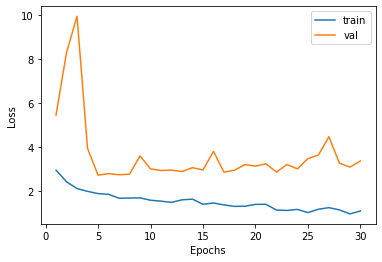

In [ ]:
from tqdm import tqdm
total_train_losses = []
total_val_losses = []

ff=open('{}/progress.txt'.format(save_folder),'w')

for epoch in range(1,epochs+1):
    ##TRAINING##
    model.train()
    train_losses = []
    confusion_matrix.reset()

    for i, batch in enumerate(tqdm(train_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch = img_batch.cuda(), lbl_batch.cuda()

        optimizer.zero_grad()
        output = model(img_batch.float())
        loss=criterion(output, lbl_batch.long())
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        confusion_matrix.add(output.data.squeeze(), lbl_batch.long())

        if i % 20 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item()))
            
    train_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)
    
    

     ##VALIDATION##
    model.eval()
    val_losses = []

    for i, batch, in enumerate(tqdm(test_dataloader)):
        img_batch, lbl_batch = batch
        img_batch, lbl_batch = img_batch.cuda(), lbl_batch.cuda()
        outputs=model(img_batch.float())
        loss=criterion(outputs, lbl_batch.long())

        confusion_matrix.add(outputs.data.squeeze(), lbl_batch.long())
        val_losses.append(loss.item())

    print('Confusion Matrix:')
    print(confusion_matrix.conf)


    val_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    
    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean, 'TRAIN_ACC: ', '%.3f' % train_acc)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean, 'VAL_ACC: ', '%.3f' % val_acc)
    confusion_matrix.reset()

    write_results(save_folder, epoch, train_acc, val_acc, train_loss_mean, val_loss_mean)

    torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch))

total_results["resnet_18_no_train_modified"] = [train_acc, val_acc]

save_graph(total_train_losses, total_val_losses, epochs, save_folder)
        

### Summary

| Model | Number of  epoch  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | 29 | 66.00 | 25.06 |

# Conclusions

__Question 7 (5 points):__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.


**ResNet18**  
**Non_pretrained**   
Using non-pretrained resnet18 we achieved a $95\%$ accuracy on the trainset and $21\%$ on the testset.  
The clear advantage of using a non-pretrained method is that, when the dataset is large enough, we can train the model properly on our specific dataset.  
The disadvantage of this method is that, in theory at least, we need a large amount of data to reach a decent performance and it requires a long time for training, especially if there is no GPU available.  
**Pretrained**  
Using the pretrained resnet18 from torchvision.models, that was already trained on the ImageNet dataset, we were able to achieve a $60\%$ accuracy on the trainset and a $20\%$ accuracy on the testset.  
The advantage of using this method in general is that we have to re-train only the final block so that it returns the correct number of classes, so it's much faster to train compared to a model that we need to train from scratch. Additionally the fact that the convolutional blocks are already trained is useful specifically in our case, since we have a very small dataset, so that we don't have to rely on our small dataset to find the weights of the convolutional block.  
The disadvantage is that the net cannot be adapted perfectly to our data, this is quite the disadvantage when we have a large amount of data.  

**VGG16**  
**Pretrained**
Using the pretrained VGG16 from torchvision.models, that was already trained on the ImageNet dataset, we were able to achieve a $98\%$ accuracy on the trainset and a $38\%$ accuracy on the testset.  
The general advantages and disadvantages are the same as in the case of the pretrained ResNet18, the main difference is that this model achieved an even better performance. 


**DenseNet121**  
**Pretrained**  
Using the pretrained DenseNet121 from torchvision.models, that was already trained on the ImageNet dataset, we were able to achieve a $93\%$ accuracy on the trainset and a $28\%$ accuracy on the testset.  
The general advantages and disadvantages are the same as in the case of the pretrained ResNet18, but this model achieved a slightly worse performance.  


**Data Augmentation**  
**ResNet18**  
In order to augment the data we used random-crop, random horizontal flip and Normalization. This data unfortunately lead to a worse performance, with a $42\%$ accuracy on the trainset and a $23\%$ accuracy on the testset.  
In general the data augmentation should lead to a better performance, given that the alogirthm should be able to recognise different patterns in the same images, increasing the possibility of finding the right patterns afterwards in the test images.  
The most probable reason why the algorithm was unable to perform properly is that the size of the dataset was too small, so the random crop, normalization and rotation lead the algorithm to not being able to recognise the standard patterns that was able to recognise with the original images.  
The main advantage that we can see on Data Augmentation is not the better result compared to the baseline (23% against 21%) but the fact that the algortihm is overfitting much less (42% on trainset against 95%). This means we can increse the number of epochs and get a better result on the testset.


In [ ]:
import pandas as pd
import seaborn as sns
tot_res = pd.DataFrame(total_results).T
mapper = {0 : "trainset", 1:"testset"}
tot_res = tot_res.rename(mapper = mapper, axis=1)
df = pd.melt(tot_res.reset_index(), id_vars="index", var_name="test/train", value_name="accuracy")

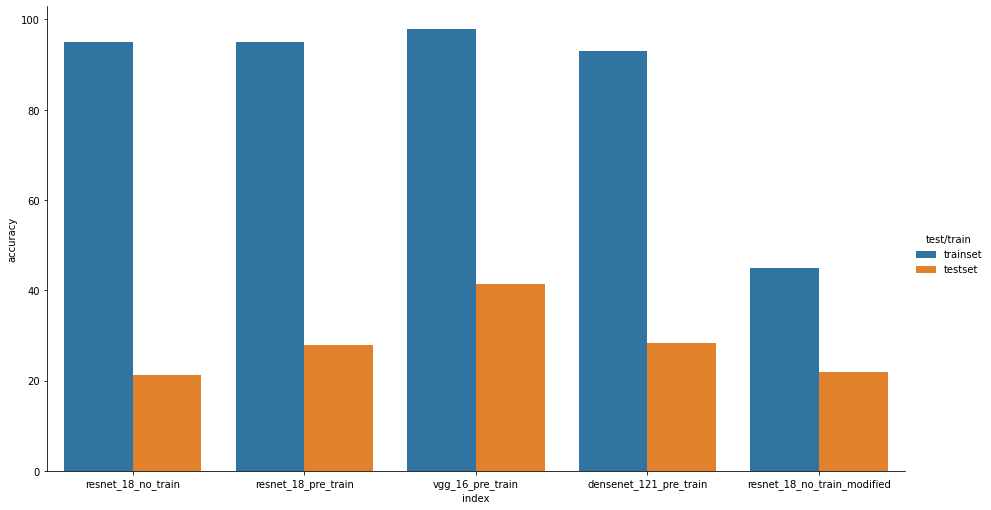

In [ ]:
sns.catplot(x='index', y='accuracy', hue='test/train', data=df, kind='bar', height=7, aspect=9/5)

# Weak supervision

__Bonus \[open\] question (up to 3 points):__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

In [ ]:
'''
#transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
'''
train_dataset = datasets.CIFAR10(root='./cifar10_data/', train=True, transform=transforms.ToTensor(), download=True)
train_range = list(range(0, 100))
val_range = list(range(100, 3600))
val_dataset = torch.utils.data.Subset(train_dataset, val_range)
train_dataset = torch.utils.data.Subset(train_dataset, train_range)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = 10, shuffle = False)
'''
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
'''
test_dataset = datasets.CIFAR10(root='./cifar10_data_test/', train=False, transform=transforms.ToTensor(), download=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified




  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 19.98it/s]

 40%|████      | 4/10 [00:00<00:00, 19.81it/s]

Train (epoch 1/7) [0/10 (0%)]	Loss: 2.305357




 70%|███████   | 7/10 [00:00<00:00, 21.09it/s]

100%|██████████| 10/10 [00:00<00:00, 22.38it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 95.60it/s]

  2%|▏         | 20/1000 [00:00<00:10, 95.70it/s]

  3%|▎         | 30/1000 [00:00<00:10, 94.83it/s]

  4%|▍         | 40/1000 [00:00<00:10, 94.56it/s]

  5%|▌         | 50/1000 [00:00<00:10, 94.47it/s]

  6%|▌         | 60/1000 [00:00<00:09, 94.38it/s]

  7%|▋         | 70/1000 [00:00<00:09, 93.70it/s]

  8%|▊         | 80/1000 [00:00<00:09, 93.49it/s]

  9%|▉         | 90/1000 [00:00<00:09, 93.54it/s]

 10%|█         | 100/1000 [00:01<00:09, 94.35it/s]

 11%|█         | 110/1000 [00:01<00:09, 94.48it/s]

 12%|█▏        | 120/1000 [00:01<00:09, 94.40it/s]

 13%|█▎        | 130/1000 [00:01<00:09, 94.64it/s]

 14%|█▍        | 140/1000 [00:01<00:09, 94.36it/s]

 15%|█▌        | 150/1000 [00:01<00:08, 94.86it/s]

 16%|█▌        | 160/1000 [00:01<00:08, 93.74it/s]

 17%|█▋        | 170/1000 [00:01<00

Confusion Matrix:
[[ 48  77  20  61  31   3   7  68   9 682]
 [  5 255   3  79  12   2   5  48   5 602]
 [ 44  62  44 427  49   6   7 135   6 233]
 [  9  60  13 520  45   8  13  91  15 239]
 [  2   9  10 683  25   3   6  76   0 197]
 [  7  79  10 488  34  27  16 149  26 171]
 [  8  33   9 628  65  16   8 119  10 111]
 [  2  35  10 294  30   2   2 110   5 521]
 [  3 120   3  47  31   3   3  37   7 750]
 [  0  86   2  47   3   0   1  14   1 858]]
TRAIN_LOSS:  2.432 TRAIN_ACC:  10.000
VAL_LOSS:  2.202 VAL_ACC:  18.832




  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 18.38it/s]

 40%|████      | 4/10 [00:00<00:00, 18.81it/s]

Train (epoch 2/7) [0/10 (0%)]	Loss: 1.677884




 70%|███████   | 7/10 [00:00<00:00, 19.99it/s]

100%|██████████| 10/10 [00:00<00:00, 21.48it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 96.82it/s]

  2%|▏         | 20/1000 [00:00<00:10, 95.59it/s]

  3%|▎         | 29/1000 [00:00<00:10, 93.28it/s]

  4%|▍         | 39/1000 [00:00<00:10, 92.45it/s]

  5%|▍         | 49/1000 [00:00<00:10, 93.04it/s]

  6%|▌         | 59/1000 [00:00<00:10, 92.63it/s]

  7%|▋         | 68/1000 [00:00<00:10, 91.47it/s]

  8%|▊         | 77/1000 [00:00<00:10, 90.66it/s]

  9%|▊         | 86/1000 [00:00<00:10, 90.20it/s]

 10%|▉         | 95/1000 [00:01<00:10, 90.03it/s]

 10%|█         | 104/1000 [00:01<00:09, 89.83it/s]

 11%|█▏        | 114/1000 [00:01<00:09, 90.57it/s]

 12%|█▏        | 124/1000 [00:01<00:09, 91.57it/s]

 13%|█▎        | 134/1000 [00:01<00:09, 91.08it/s]

 14%|█▍        | 144/1000 [00:01<00:09, 90.54it/s]

 15%|█▌        | 154/1000 [00:01<00:09, 91.79it/s]

 16%|█▋        | 164/1000 [00:01<00:

Confusion Matrix:
[[ 59 282 375   9  14   2  27  21  11 206]
 [  1 891   9   8   0   3  10   4   0  90]
 [ 13 142 660  79  21   8  48  22   0  20]
 [  2 355 291 200  18  22  65  22   0  38]
 [  0 129 595 116  79   5  49  13   0  25]
 [  5 290 359 171   9  49  60  50   0  14]
 [  3 255 278 186  33  80 150  16   0   6]
 [  2 235 586  37  24   6   5  38   0  78]
 [  9 512 153  12  12   3  22   1   5 275]
 [  3 681  27   4   4   1   2   9   0 281]]
TRAIN_LOSS:  1.978 TRAIN_ACC:  34.000
VAL_LOSS:  2.069 VAL_ACC:  23.881




  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 17.63it/s]

 40%|████      | 4/10 [00:00<00:00, 18.12it/s]

Train (epoch 3/7) [0/10 (0%)]	Loss: 1.231453




 60%|██████    | 6/10 [00:00<00:00, 18.56it/s]

100%|██████████| 10/10 [00:00<00:00, 20.39it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 95.79it/s]

  2%|▏         | 18/1000 [00:00<00:10, 89.99it/s]

  3%|▎         | 28/1000 [00:00<00:10, 91.10it/s]

  4%|▎         | 37/1000 [00:00<00:10, 89.54it/s]

  5%|▍         | 46/1000 [00:00<00:10, 89.47it/s]

  6%|▌         | 56/1000 [00:00<00:10, 90.67it/s]

  7%|▋         | 66/1000 [00:00<00:10, 91.43it/s]

  8%|▊         | 76/1000 [00:00<00:10, 92.16it/s]

  9%|▊         | 86/1000 [00:00<00:09, 92.11it/s]

 10%|▉         | 96/1000 [00:01<00:09, 93.00it/s]

 11%|█         | 106/1000 [00:01<00:09, 93.30it/s]

 12%|█▏        | 116/1000 [00:01<00:09, 93.67it/s]

 13%|█▎        | 126/1000 [00:01<00:09, 93.54it/s]

 14%|█▎        | 136/1000 [00:01<00:09, 92.76it/s]

 15%|█▍        | 146/1000 [00:01<00:09, 91.37it/s]

 16%|█▌        | 156/1000 [00:01<00:09, 91.46it/s]

 17%|█▋        | 166/1000 [00:01<00:

Confusion Matrix:
[[  3   5 218 424 111 132   1  91  18   3]
 [  0 112  19 329  27 436   3  87   0   3]
 [  0   7 207 301 109 348   1  38   1   1]
 [  0   5  66 378 112 435   0  16   0   1]
 [  0   2 129 345 195 331   1   8   0   0]
 [  1   9  42 291  80 570   2  11   0   1]
 [  0   6 117 262  91 508   5  18   0   0]
 [  0   3  90 382 153 353   0  27   1   2]
 [  0  28 112 524  99 177   4  54   6   0]
 [  1  42  28 453  66 375   0  40   0   7]]
TRAIN_LOSS:  1.688 TRAIN_ACC:  44.000
VAL_LOSS:  2.372 VAL_ACC:  14.950




  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 18.53it/s]

 40%|████      | 4/10 [00:00<00:00, 18.42it/s]

Train (epoch 4/7) [0/10 (0%)]	Loss: 2.164700




 70%|███████   | 7/10 [00:00<00:00, 19.75it/s]

100%|██████████| 10/10 [00:00<00:00, 21.36it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:09, 99.34it/s]

  2%|▏         | 20/1000 [00:00<00:10, 97.86it/s]

  3%|▎         | 30/1000 [00:00<00:09, 97.30it/s]

  4%|▍         | 40/1000 [00:00<00:09, 96.53it/s]

  5%|▌         | 50/1000 [00:00<00:09, 96.50it/s]

  6%|▌         | 60/1000 [00:00<00:09, 96.09it/s]

  7%|▋         | 70/1000 [00:00<00:09, 94.67it/s]

  8%|▊         | 80/1000 [00:00<00:09, 94.06it/s]

  9%|▉         | 90/1000 [00:00<00:09, 95.11it/s]

 10%|█         | 100/1000 [00:01<00:09, 94.35it/s]

 11%|█         | 110/1000 [00:01<00:09, 94.86it/s]

 12%|█▏        | 120/1000 [00:01<00:09, 95.26it/s]

 13%|█▎        | 130/1000 [00:01<00:09, 95.95it/s]

 14%|█▍        | 140/1000 [00:01<00:09, 95.24it/s]

 15%|█▌        | 150/1000 [00:01<00:08, 94.67it/s]

 16%|█▌        | 160/1000 [00:01<00:08, 94.17it/s]

 17%|█▋        | 170/1000 [00:01<00

Confusion Matrix:
[[152 173 301   8  51   1   2 138 174   6]
 [  9 904  33   7  11   2   1  28  18   3]
 [ 34 252 441  20  78  14   1 149  21   3]
 [ 14 588 138  69  33   8   5 146   8   4]
 [  6 167 333  47 220   7   4 210  10   7]
 [ 19 649  99  36  34  17   1 143   6   3]
 [ 12 505 194  60 125   3  14  74  17   3]
 [ 15 264 193  11  68   5   0 437   7  11]
 [ 55 427 205  12  41   1   1  86 170   6]
 [ 13 757  74  10  41   2   1  77  35   2]]
TRAIN_LOSS:  2.011 TRAIN_ACC:  33.000
VAL_LOSS:  2.139 VAL_ACC:  24.020




  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 18.34it/s]

 40%|████      | 4/10 [00:00<00:00, 18.48it/s]

Train (epoch 5/7) [0/10 (0%)]	Loss: 1.437342




 70%|███████   | 7/10 [00:00<00:00, 19.99it/s]

100%|██████████| 10/10 [00:00<00:00, 21.61it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:09, 99.29it/s]

  2%|▏         | 20/1000 [00:00<00:10, 97.10it/s]

  3%|▎         | 30/1000 [00:00<00:09, 97.43it/s]

  4%|▍         | 39/1000 [00:00<00:10, 94.56it/s]

  5%|▍         | 49/1000 [00:00<00:10, 94.60it/s]

  6%|▌         | 59/1000 [00:00<00:10, 93.89it/s]

  7%|▋         | 69/1000 [00:00<00:09, 94.04it/s]

  8%|▊         | 79/1000 [00:00<00:09, 94.84it/s]

  9%|▉         | 89/1000 [00:00<00:09, 93.96it/s]

 10%|▉         | 99/1000 [00:01<00:09, 93.73it/s]

 11%|█         | 109/1000 [00:01<00:09, 94.20it/s]

 12%|█▏        | 119/1000 [00:01<00:09, 95.35it/s]

 13%|█▎        | 129/1000 [00:01<00:09, 95.97it/s]

 14%|█▍        | 139/1000 [00:01<00:08, 96.25it/s]

 15%|█▍        | 149/1000 [00:01<00:08, 96.55it/s]

 16%|█▌        | 159/1000 [00:01<00:08, 95.53it/s]

 17%|█▋        | 169/1000 [00:01<00:

Confusion Matrix:
[[263 107 141 148 198  17  54  28  47   3]
 [ 14 589   9 268  27  28  77   0   1   3]
 [ 70  41 232 251 234  72  72  30   7   4]
 [ 11  84  32 640  75  74  70  25   1   1]
 [  5  10 114 341 462  29  16  31   2   1]
 [ 12  83  38 502  85 170  82  29   0   6]
 [  5  40  93 440 135  87 197   8   1   1]
 [ 36  32  82 307 242  81   5 220   0   6]
 [ 88 220  48 291 217  11  71   4  49   5]
 [ 30 357  19 390 107  28  65  12   1   3]]
TRAIN_LOSS:  1.335 TRAIN_ACC:  55.000
VAL_LOSS:  2.129 VAL_ACC:  27.970




  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 18.48it/s]

 40%|████      | 4/10 [00:00<00:00, 18.89it/s]

Train (epoch 6/7) [0/10 (0%)]	Loss: 0.506840




 60%|██████    | 6/10 [00:00<00:00, 19.18it/s]

100%|██████████| 10/10 [00:00<00:00, 21.08it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 11/1000 [00:00<00:09, 99.96it/s]

  2%|▏         | 21/1000 [00:00<00:09, 98.61it/s]

  3%|▎         | 31/1000 [00:00<00:09, 97.44it/s]

  4%|▍         | 41/1000 [00:00<00:09, 96.48it/s]

  5%|▌         | 51/1000 [00:00<00:09, 96.48it/s]

  6%|▌         | 61/1000 [00:00<00:09, 95.97it/s]

  7%|▋         | 70/1000 [00:00<00:09, 93.73it/s]

  8%|▊         | 79/1000 [00:00<00:10, 91.09it/s]

  9%|▉         | 88/1000 [00:00<00:10, 90.30it/s]

 10%|▉         | 98/1000 [00:01<00:09, 90.51it/s]

 11%|█         | 108/1000 [00:01<00:09, 92.57it/s]

 12%|█▏        | 118/1000 [00:01<00:09, 92.24it/s]

 13%|█▎        | 128/1000 [00:01<00:09, 93.03it/s]

 14%|█▍        | 138/1000 [00:01<00:09, 92.58it/s]

 15%|█▍        | 148/1000 [00:01<00:09, 93.62it/s]

 16%|█▌        | 158/1000 [00:01<00:08, 94.82it/s]

 17%|█▋        | 168/1000 [00:01<00:

Confusion Matrix:
[[208   2 641   5  90   3   0  23   2  32]
 [ 61  92 274  98 121  57   4  74   2 233]
 [ 18   0 739  26 118  15   0  87   1   9]
 [  5   5 314 271 174  50   1 170   0  23]
 [  2   0 519  35 296   5   0 153   0   1]
 [ 11   4 282 192 148 119   1 219   1  30]
 [  3   0 570 128 179  47  17  54   1   8]
 [ 17   0 324  32 104   9   0 521   0   4]
 [ 72   6 475  72 211   5   2  23   4 134]
 [ 60   9 372  94 188   8   1  66   0 214]]
TRAIN_LOSS:  0.781 TRAIN_ACC:  73.000
VAL_LOSS:  2.832 VAL_ACC:  24.564




  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 17.89it/s]

 50%|█████     | 5/10 [00:00<00:00, 18.82it/s]

Train (epoch 7/7) [0/10 (0%)]	Loss: 1.248875




100%|██████████| 10/10 [00:00<00:00, 21.83it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:09, 99.67it/s]

  2%|▏         | 20/1000 [00:00<00:09, 98.37it/s]

  3%|▎         | 30/1000 [00:00<00:10, 96.35it/s]

  4%|▍         | 40/1000 [00:00<00:10, 95.49it/s]

  5%|▍         | 49/1000 [00:00<00:10, 93.15it/s]

  6%|▌         | 59/1000 [00:00<00:10, 92.62it/s]

  7%|▋         | 68/1000 [00:00<00:10, 91.58it/s]

  8%|▊         | 77/1000 [00:00<00:10, 91.07it/s]

  9%|▊         | 86/1000 [00:00<00:10, 88.75it/s]

 10%|▉         | 95/1000 [00:01<00:10, 88.80it/s]

 10%|█         | 104/1000 [00:01<00:10, 86.67it/s]

 11%|█▏        | 113/1000 [00:01<00:10, 86.07it/s]

 12%|█▏        | 122/1000 [00:01<00:10, 85.89it/s]

 13%|█▎        | 131/1000 [00:01<00:10, 84.60it/s]

 14%|█▍        | 140/1000 [00:01<00:10, 84.72it/s]

 15%|█▍        | 149/1000 [00:01<00:10, 84.77it/s]

 16%|█▌        | 158/1000 [00:01<00:09, 85.82it/s]

 17%|█▋        | 168/1000 [00:01

Confusion Matrix:
[[294 168 202  29  13   5  11   9 187  88]
 [  7 919   8  24   0   6  14   1   8  29]
 [106  91 480 127  37  71  42  21  14  24]
 [ 33 245 111 359   9 141  65  24   6  20]
 [ 18  41 358 304 139  60  26  49   6  10]
 [ 32 197 127 211  12 293  70  49   2  14]
 [ 14 125 175 275  29  75 296   4   7   7]
 [ 79  89 233 135  31  91   4 323   1  25]
 [ 62 435 113  45  15   1  16   5 208 104]
 [ 15 704  46  61  11  14  17   3  29 112]]
TRAIN_LOSS:  0.711 TRAIN_ACC:  77.000
VAL_LOSS:  2.135 VAL_ACC:  33.891




  0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  2%|▏         | 7/350 [00:00<00:05, 66.46it/s]

  4%|▍         | 14/350 [00:00<00:05, 65.93it/s]

  7%|▋         | 23/350 [00:00<00:04, 70.54it/s]

  9%|▉         | 32/350 [00:00<00:04, 75.23it/s]

 12%|█▏        | 42/350 [00:00<00:03, 79.77it/s]

 15%|█▍        | 52/350 [00:00<00:03, 83.13it/s]

 18%|█▊        | 62/350 [00:00<00:03, 85.92it/s]

 20%|██        | 71/350 [00:00<00:03, 86.90it/s]

 23%|██▎       | 81/350 [00:00<00:03, 88.19it/s]

 26%|██▌       | 91/350 [00:01<00:02, 89.46it/s]

 29%|██▊       | 100/350 [00:01<00:02, 89.49it/s]

 31%|███       | 109/350 [00:01<00:02, 89.52it/s]

 34%|███▎      | 118/350 [00:01<00:02, 89.39it/s]

 37%|███▋      | 128/350 [00:01<00:02, 89.98it/s]

 39%|███▉      | 138/350 [00:01<00:02, 90.46it/s]

 42%|████▏     | 

Added 50 images to the training data




  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 27.71it/s]

 40%|████      | 6/15 [00:00<00:00, 26.77it/s]

Train (epoch 1/7) [0/15 (0%)]	Loss: 2.783514




 60%|██████    | 9/15 [00:00<00:00, 25.70it/s]

 80%|████████  | 12/15 [00:00<00:00, 25.67it/s]

100%|██████████| 15/15 [00:00<00:00, 25.24it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 95.54it/s]

  2%|▏         | 20/1000 [00:00<00:10, 95.82it/s]

  3%|▎         | 30/1000 [00:00<00:10, 94.65it/s]

  4%|▍         | 39/1000 [00:00<00:10, 92.72it/s]

  5%|▍         | 49/1000 [00:00<00:10, 93.69it/s]

  6%|▌         | 59/1000 [00:00<00:10, 93.00it/s]

  7%|▋         | 68/1000 [00:00<00:10, 91.98it/s]

  8%|▊         | 78/1000 [00:00<00:09, 92.70it/s]

  9%|▉         | 88/1000 [00:00<00:09, 94.19it/s]

 10%|▉         | 98/1000 [00:01<00:09, 94.19it/s]

 11%|█         | 108/1000 [00:01<00:09, 92.79it/s]

 12%|█▏        | 118/1000 [00:01<00:09, 93.65it/s]

 13%|█▎        | 128/1000 [00:01<00:09, 94.36it/s]

 14%|█▍        | 138/1000 [00:01<00:09, 94.10it/s]

 15%|█▍        | 148/1000 [00:01<00:09, 94.15it/s]

 16%|█▌        | 158/1000 [00:01<00:09,

Confusion Matrix:
[[   0  880   42    0    8    0    0   77    0    0]
 [   0 1034    1    5    0    1    1    5    1    3]
 [   1  745  176    3   25    0    1   62    1    1]
 [   0  936   41    3    4    2   11   16    0    1]
 [   1  675  211    3   80    0    2   38    1    0]
 [   0  957   41    1    4    0    0    4    0    0]
 [   0  814  134    8   25    1    8   17    0    0]
 [   1  845   87    2   13    0    1   72    0    1]
 [   0  984   15    0    4    0    0    1    0    0]
 [   1  998    3    4    2    0    0    1    0    3]]
TRAIN_LOSS:  1.921 TRAIN_ACC:  34.667
VAL_LOSS:  2.574 VAL_ACC:  13.557




  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 17.69it/s]

 27%|██▋       | 4/15 [00:00<00:00, 17.84it/s]

Train (epoch 2/7) [0/15 (0%)]	Loss: 2.149188




 47%|████▋     | 7/15 [00:00<00:00, 19.45it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 20.78it/s]

100%|██████████| 15/15 [00:00<00:00, 22.38it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:09, 99.15it/s]

  2%|▏         | 20/1000 [00:00<00:10, 97.46it/s]

  3%|▎         | 30/1000 [00:00<00:10, 96.39it/s]

  4%|▍         | 40/1000 [00:00<00:10, 95.91it/s]

  5%|▌         | 50/1000 [00:00<00:10, 94.49it/s]

  6%|▌         | 60/1000 [00:00<00:09, 94.44it/s]

  7%|▋         | 70/1000 [00:00<00:09, 94.91it/s]

  8%|▊         | 80/1000 [00:00<00:09, 93.78it/s]

  9%|▉         | 90/1000 [00:00<00:09, 93.62it/s]

 10%|█         | 100/1000 [00:01<00:09, 93.15it/s]

 11%|█         | 110/1000 [00:01<00:09, 92.15it/s]

 12%|█▏        | 120/1000 [00:01<00:09, 92.01it/s]

 13%|█▎        | 130/1000 [00:01<00:09, 92.07it/s]

 14%|█▍        | 140/1000 [00:01<00:09, 91.92it/s]

 15%|█▌        | 150/1000 [00:01<00:09, 91.17it/s]

 16%|█▌        | 160/1000 [00:01<00:09

Confusion Matrix:
[[   0  527    8    5    3    0    0  432    0   32]
 [   1 1014    1    2    1    0    1   13    0   18]
 [   0  323   59   55   36    0    0  539    0    3]
 [   2  685    7  104   11    2    5  193    0    5]
 [   0  191   12   70  156    0    1  579    0    2]
 [   3  692   11   73    7    2    1  218    0    0]
 [   4  396   46  270   35    1    0  255    0    0]
 [   2  290   14   15    9    0    1  684    0    7]
 [   0  896    2   12    1    0    0   75    0   18]
 [   1  941    4    6    3    0    0   35    0   22]]
TRAIN_LOSS:  1.570 TRAIN_ACC:  46.000
VAL_LOSS:  2.354 VAL_ACC:  20.108




  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.05it/s]

 27%|██▋       | 4/15 [00:00<00:00, 18.51it/s]

Train (epoch 3/7) [0/15 (0%)]	Loss: 1.181748




 47%|████▋     | 7/15 [00:00<00:00, 19.39it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 20.80it/s]

100%|██████████| 15/15 [00:00<00:00, 22.32it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 96.00it/s]

  2%|▏         | 19/1000 [00:00<00:10, 94.05it/s]

  3%|▎         | 28/1000 [00:00<00:10, 91.22it/s]

  4%|▍         | 38/1000 [00:00<00:10, 92.14it/s]

  5%|▍         | 48/1000 [00:00<00:10, 91.73it/s]

  6%|▌         | 57/1000 [00:00<00:10, 90.02it/s]

  7%|▋         | 67/1000 [00:00<00:10, 90.85it/s]

  8%|▊         | 77/1000 [00:00<00:10, 91.04it/s]

  9%|▊         | 87/1000 [00:00<00:09, 91.36it/s]

 10%|▉         | 96/1000 [00:01<00:10, 88.92it/s]

 10%|█         | 105/1000 [00:01<00:10, 87.96it/s]

 11%|█▏        | 114/1000 [00:01<00:10, 88.28it/s]

 12%|█▏        | 123/1000 [00:01<00:09, 87.72it/s]

 13%|█▎        | 132/1000 [00:01<00:09, 87.02it/s]

 14%|█▍        | 141/1000 [00:01<00:09, 87.59it/s]

 15%|█▌        | 150/1000 [00:01<00:09,

Confusion Matrix:
[[ 152  568    4   68   44    0   19  111   28   13]
 [   4 1008    1   18    4    0   10    2    0    4]
 [  51  311   48  128   62    1  129  283    2    0]
 [  15  537    6  325   13   12   67   39    0    0]
 [   4  207   16  254  237    1   56  236    0    0]
 [  16  547    7  194   18   35  106   84    0    0]
 [  20  267   31  314   46   14  257   57    0    1]
 [  13  347   12   98   41    8   22  478    2    1]
 [  20  776    5   73   35    1   18   19   53    4]
 [   4  944    2   30   12    0    6    2    3    9]]
TRAIN_LOSS:  1.106 TRAIN_ACC:  62.667
VAL_LOSS:  2.615 VAL_ACC:  25.635




  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 17.09it/s]

 27%|██▋       | 4/15 [00:00<00:00, 17.08it/s]

Train (epoch 4/7) [0/15 (0%)]	Loss: 0.893027




 47%|████▋     | 7/15 [00:00<00:00, 18.52it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 19.60it/s]

100%|██████████| 15/15 [00:00<00:00, 21.44it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 9/1000 [00:00<00:11, 87.91it/s]

  2%|▏         | 18/1000 [00:00<00:11, 86.03it/s]

  3%|▎         | 26/1000 [00:00<00:11, 83.92it/s]

  4%|▎         | 35/1000 [00:00<00:11, 84.66it/s]

  4%|▍         | 45/1000 [00:00<00:11, 86.67it/s]

  6%|▌         | 55/1000 [00:00<00:10, 88.97it/s]

  6%|▋         | 65/1000 [00:00<00:10, 91.16it/s]

  8%|▊         | 75/1000 [00:00<00:10, 92.10it/s]

  8%|▊         | 85/1000 [00:00<00:09, 92.52it/s]

  9%|▉         | 94/1000 [00:01<00:09, 91.73it/s]

 10%|█         | 104/1000 [00:01<00:09, 92.72it/s]

 11%|█▏        | 114/1000 [00:01<00:09, 92.93it/s]

 12%|█▏        | 124/1000 [00:01<00:09, 92.35it/s]

 13%|█▎        | 134/1000 [00:01<00:09, 93.34it/s]

 14%|█▍        | 144/1000 [00:01<00:09, 93.74it/s]

 15%|█▌        | 154/1000 [00:01<00:08, 

Confusion Matrix:
[[ 126  445   16    1   39    2    0  229   59   90]
 [   5 1021    2    3    2    0    0    7    0   11]
 [  85  315   97    7   73   17    3  408    5    5]
 [  29  696   17   32   16   67    5  144    1    7]
 [  11  244   42   25  223   12    2  441    5    6]
 [  30  629   27    6   22   90    0  202    0    1]
 [  50  504  125   28   82   57   11  147    1    2]
 [  20  233   17    5   20   18    0  689    5   15]
 [  26  805    9    3   20   10    0   27   58   46]
 [  12  907    4    5    3    4    0   22   12   43]]
TRAIN_LOSS:  1.234 TRAIN_ACC:  64.667
VAL_LOSS:  2.645 VAL_ACC:  23.547




  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.43it/s]

 33%|███▎      | 5/15 [00:00<00:00, 19.31it/s]

Train (epoch 5/7) [0/15 (0%)]	Loss: 0.756811




 53%|█████▎    | 8/15 [00:00<00:00, 20.29it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 21.46it/s]

100%|██████████| 15/15 [00:00<00:00, 22.72it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 11/1000 [00:00<00:09, 100.63it/s]

  2%|▏         | 21/1000 [00:00<00:09, 98.22it/s] 

  3%|▎         | 31/1000 [00:00<00:09, 97.13it/s]

  4%|▍         | 41/1000 [00:00<00:10, 95.47it/s]

  5%|▌         | 50/1000 [00:00<00:10, 93.69it/s]

  6%|▌         | 60/1000 [00:00<00:10, 93.53it/s]

  7%|▋         | 70/1000 [00:00<00:09, 93.15it/s]

  8%|▊         | 80/1000 [00:00<00:10, 91.00it/s]

  9%|▉         | 90/1000 [00:00<00:09, 91.83it/s]

 10%|█         | 100/1000 [00:01<00:09, 92.96it/s]

 11%|█         | 110/1000 [00:01<00:09, 91.53it/s]

 12%|█▏        | 120/1000 [00:01<00:09, 91.79it/s]

 13%|█▎        | 130/1000 [00:01<00:09, 92.82it/s]

 14%|█▍        | 140/1000 [00:01<00:09, 92.73it/s]

 15%|█▌        | 150/1000 [00:01<00:09, 92.83it/s]

 16%|█▌        | 160/1000 [00:01<00:

Confusion Matrix:
[[199  89  18  23  88   4   3 207 267 109]
 [ 40 756   4  29  14   4  14  31  36 123]
 [113  54  61  58 246  21  57 366  28  11]
 [ 66 232  14 223  61  94  87 201  10  26]
 [ 14  41   1  92 475   7  28 325  20   8]
 [ 68 233   3 137  75 140  60 272  11   8]
 [ 49  86  17 192 192  43 245 167   9   7]
 [ 32  36   5  59  85  12   4 743  24  22]
 [ 28 282   8  35  59   3   5  39 389 156]
 [ 48 417   1  45  24   4   5  76  92 300]]
TRAIN_LOSS:  0.869 TRAIN_ACC:  70.000
VAL_LOSS:  1.952 VAL_ACC:  34.788




  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.54it/s]

 33%|███▎      | 5/15 [00:00<00:00, 19.32it/s]

Train (epoch 6/7) [0/15 (0%)]	Loss: 0.606557




 53%|█████▎    | 8/15 [00:00<00:00, 20.30it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 21.59it/s]

100%|██████████| 15/15 [00:00<00:00, 22.79it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 97.58it/s]

  2%|▏         | 20/1000 [00:00<00:10, 95.86it/s]

  3%|▎         | 30/1000 [00:00<00:10, 94.50it/s]

  4%|▍         | 39/1000 [00:00<00:10, 93.03it/s]

  5%|▍         | 49/1000 [00:00<00:10, 93.15it/s]

  6%|▌         | 59/1000 [00:00<00:10, 93.07it/s]

  7%|▋         | 68/1000 [00:00<00:10, 91.57it/s]

  8%|▊         | 78/1000 [00:00<00:09, 92.40it/s]

  9%|▉         | 88/1000 [00:00<00:09, 92.11it/s]

 10%|▉         | 98/1000 [00:01<00:09, 92.33it/s]

 11%|█         | 108/1000 [00:01<00:09, 92.67it/s]

 12%|█▏        | 118/1000 [00:01<00:09, 92.10it/s]

 13%|█▎        | 128/1000 [00:01<00:09, 91.99it/s]

 14%|█▍        | 138/1000 [00:01<00:09, 91.75it/s]

 15%|█▍        | 148/1000 [00:01<00:09, 92.30it/s]

 16%|█▌        | 158/1000 [00:01<00:09,

Confusion Matrix:
[[203 107  28  34  35  25   1  39 135 400]
 [  5 729   7  26   6  11   5   7   8 247]
 [126 107 220  57 130  51  32 213  20  59]
 [ 62 291  32 236  25 201  30  85   2  50]
 [ 26  55  54 154 385  38   8 247  13  31]
 [ 57 239  26 116  29 352  23 135   3  27]
 [ 39 149 162 242 111 108 110  68   1  17]
 [ 53  64  20  56  61  50   2 624   6  86]
 [ 13 210  15  77  25  14   3   5 183 459]
 [  9 307   5  51   7  18   1   5  12 597]]
TRAIN_LOSS:  0.610 TRAIN_ACC:  78.000
VAL_LOSS:  2.100 VAL_ACC:  35.852




  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.44it/s]

 27%|██▋       | 4/15 [00:00<00:00, 18.63it/s]

Train (epoch 7/7) [0/15 (0%)]	Loss: 0.133572




 40%|████      | 6/15 [00:00<00:00, 18.65it/s]

 60%|██████    | 9/15 [00:00<00:00, 19.99it/s]

 80%|████████  | 12/15 [00:00<00:00, 21.09it/s]

100%|██████████| 15/15 [00:00<00:00, 21.68it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 11/1000 [00:00<00:09, 100.03it/s]

  2%|▏         | 20/1000 [00:00<00:10, 96.77it/s] 

  3%|▎         | 30/1000 [00:00<00:10, 96.04it/s]

  4%|▍         | 40/1000 [00:00<00:10, 95.28it/s]

  5%|▌         | 50/1000 [00:00<00:10, 94.49it/s]

  6%|▌         | 60/1000 [00:00<00:10, 93.32it/s]

  7%|▋         | 70/1000 [00:00<00:09, 93.10it/s]

  8%|▊         | 80/1000 [00:00<00:09, 93.25it/s]

  9%|▉         | 90/1000 [00:00<00:09, 93.08it/s]

 10%|█         | 100/1000 [00:01<00:09, 93.08it/s]

 11%|█         | 110/1000 [00:01<00:09, 93.12it/s]

 12%|█▏        | 120/1000 [00:01<00:09, 92.62it/s]

 13%|█▎        | 130/1000 [00:01<00:09, 92.71it/s]

 14%|█▍        | 140/1000 [00:01<00:09, 92.52it/s]

 15%|█▌        | 150/1000 [00:01<00:09, 

Confusion Matrix:
[[409 141  28  36  55  33   5  55  65 180]
 [ 19 891   1  26   5  20   6   7   2  74]
 [174  49 292  58 128  80  41 177   6  10]
 [ 74 158  66 254  31 286  45  83   1  16]
 [ 35  35 115 151 368  44  11 241   7   4]
 [ 89 109  42 135  38 455  21 109   2   7]
 [ 63  67 273 197 114 130 122  36   0   5]
 [ 89  44  25  56  49  78   4 654   2  21]
 [ 76 391  27  72  29  16  10   8 120 255]
 [ 54 581   5  45   9  33   4   7   4 270]]
TRAIN_LOSS:  0.234 TRAIN_ACC:  94.000
VAL_LOSS:  2.465 VAL_ACC:  37.783




  0%|          | 0/345 [00:00<?, ?it/s]

  2%|▏         | 7/345 [00:00<00:04, 69.60it/s]

  4%|▍         | 15/345 [00:00<00:04, 70.54it/s]

  7%|▋         | 25/345 [00:00<00:04, 76.59it/s]

 10%|█         | 35/345 [00:00<00:03, 80.40it/s]

 13%|█▎        | 45/345 [00:00<00:03, 83.85it/s]

 16%|█▌        | 55/345 [00:00<00:03, 87.27it/s]

 19%|█▉        | 65/345 [00:00<00:03, 90.02it/s]

 22%|██▏       | 75/345 [00:00<00:02, 91.48it/s]

 25%|██▍       | 85/345 [00:00<00:02, 92.55it/s]

 28%|██▊       | 95/345 [00:01<00:02, 91.99it/s]

 30%|███       | 105/345 [00:01<00:02, 92.39it/s]

 33%|███▎      | 115/345 [00:01<00:02, 93.20it/s]

 36%|███▌      | 125/345 [00:01<00:02, 93.66it/s]

 39%|███▉      | 135/345 [00:01<00:02, 94.02it/s]

 42%|████▏     | 146/345 [00:01<00:02, 95.96it/s]

 45%|████▌     | 156/345 [00:01<00:01, 95.73it/s]

 48%|████▊     | 166/345 [00:01<00:01, 95.66it/s]

 51%|█████     | 176/345 [00:01<00:01, 96.44it/s]

 54%|█████▍    | 186/345 [00:02<00:01, 96.90it/s]


Added 338 images to the training data




  0%|          | 0/44 [00:00<?, ?it/s]

  7%|▋         | 3/44 [00:00<00:01, 27.27it/s]



Train (epoch 1/7) [0/44 (0%)]	Loss: 2.685483


 14%|█▎        | 6/44 [00:00<00:01, 26.47it/s]

 20%|██        | 9/44 [00:00<00:01, 25.94it/s]

 27%|██▋       | 12/44 [00:00<00:01, 25.43it/s]

 34%|███▍      | 15/44 [00:00<00:01, 25.19it/s]

 41%|████      | 18/44 [00:00<00:01, 25.04it/s]

 48%|████▊     | 21/44 [00:00<00:00, 25.08it/s]

 55%|█████▍    | 24/44 [00:00<00:00, 24.80it/s]

Train (epoch 1/7) [20/44 (45%)]	Loss: 2.112406




 61%|██████▏   | 27/44 [00:01<00:00, 24.77it/s]

 68%|██████▊   | 30/44 [00:01<00:00, 24.96it/s]

 75%|███████▌  | 33/44 [00:01<00:00, 25.16it/s]

 82%|████████▏ | 36/44 [00:01<00:00, 24.98it/s]

 89%|████████▊ | 39/44 [00:01<00:00, 24.70it/s]

100%|██████████| 44/44 [00:01<00:00, 25.00it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Train (epoch 1/7) [40/44 (91%)]	Loss: 0.185678




  1%|          | 10/1000 [00:00<00:10, 93.00it/s]

  2%|▏         | 18/1000 [00:00<00:11, 87.58it/s]

  3%|▎         | 26/1000 [00:00<00:11, 82.78it/s]

  3%|▎         | 34/1000 [00:00<00:12, 80.36it/s]

  4%|▍         | 42/1000 [00:00<00:11, 79.94it/s]

  5%|▌         | 50/1000 [00:00<00:11, 79.29it/s]

  6%|▌         | 58/1000 [00:00<00:11, 78.75it/s]

  7%|▋         | 67/1000 [00:00<00:11, 79.57it/s]

  8%|▊         | 75/1000 [00:00<00:11, 79.00it/s]

  8%|▊         | 83/1000 [00:01<00:11, 79.10it/s]

  9%|▉         | 91/1000 [00:01<00:11, 76.87it/s]

 10%|█         | 100/1000 [00:01<00:11, 78.31it/s]

 11%|█         | 109/1000 [00:01<00:11, 79.32it/s]

 12%|█▏        | 118/1000 [00:01<00:10, 81.13it/s]

 13%|█▎        | 127/1000 [00:01<00:10, 83.05it/s]

 14%|█▎        | 137/1000 [00:01<00:10, 85.33it/s]

 15%|█▍        | 146/1000 [00:01<00:10, 83.98it/s]

 16%|█▌        | 155/1000 [00:01<00:09, 85.12it/s]

 16%|█▋        | 164/1000 [00:02<00:10, 83.52it/s]

 17%|█▋        | 173/

Confusion Matrix:
[[   0  776    0    1    1    0    1  226    0    1]
 [   0 1149    1    5    1    1    1   74    1    2]
 [   0  807    4    4    1    0    1  196    1    1]
 [   0  856    4    0    2    0    3  147    1    0]
 [   0  796    2    2    0    0    2  206    1    2]
 [   0  794    2    1    0    0    0  209    1    0]
 [   0  935    2    0    0    0    0   66    1    3]
 [   0  553    2    1    0    1    0  565    1    1]
 [   0  987    2    0    1    0    0   13    0    1]
 [   0 1000    3    0    2    0    0    9    1    1]]
TRAIN_LOSS:  1.620 TRAIN_ACC:  48.630
VAL_LOSS:  3.731 VAL_ACC:  16.469




  0%|          | 0/44 [00:00<?, ?it/s]

  5%|▍         | 2/44 [00:00<00:02, 17.55it/s]

  9%|▉         | 4/44 [00:00<00:02, 17.47it/s]

Train (epoch 2/7) [0/44 (0%)]	Loss: 3.179411




 16%|█▌        | 7/44 [00:00<00:01, 19.05it/s]

 23%|██▎       | 10/44 [00:00<00:01, 20.23it/s]

 30%|██▉       | 13/44 [00:00<00:01, 21.37it/s]

 36%|███▋      | 16/44 [00:00<00:01, 22.09it/s]

 43%|████▎     | 19/44 [00:00<00:01, 22.56it/s]

 50%|█████     | 22/44 [00:00<00:00, 22.95it/s]

 57%|█████▋    | 25/44 [00:01<00:00, 23.38it/s]

Train (epoch 2/7) [20/44 (45%)]	Loss: 0.170810




 64%|██████▎   | 28/44 [00:01<00:00, 23.89it/s]

 70%|███████   | 31/44 [00:01<00:00, 24.11it/s]

 77%|███████▋  | 34/44 [00:01<00:00, 24.41it/s]

 84%|████████▍ | 37/44 [00:01<00:00, 24.55it/s]

 91%|█████████ | 40/44 [00:01<00:00, 24.72it/s]

100%|██████████| 44/44 [00:01<00:00, 23.61it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Train (epoch 2/7) [40/44 (91%)]	Loss: 0.000681




  1%|          | 10/1000 [00:00<00:10, 97.40it/s]

  2%|▏         | 20/1000 [00:00<00:10, 96.40it/s]

  3%|▎         | 29/1000 [00:00<00:10, 93.34it/s]

  4%|▍         | 39/1000 [00:00<00:10, 92.98it/s]

  5%|▍         | 49/1000 [00:00<00:10, 93.25it/s]

  6%|▌         | 58/1000 [00:00<00:10, 91.05it/s]

  7%|▋         | 68/1000 [00:00<00:10, 92.69it/s]

  8%|▊         | 78/1000 [00:00<00:09, 92.34it/s]

  9%|▉         | 88/1000 [00:00<00:09, 93.03it/s]

 10%|▉         | 97/1000 [00:01<00:09, 91.68it/s]

 11%|█         | 107/1000 [00:01<00:09, 92.20it/s]

 12%|█▏        | 117/1000 [00:01<00:09, 91.16it/s]

 13%|█▎        | 127/1000 [00:01<00:09, 91.90it/s]

 14%|█▎        | 137/1000 [00:01<00:09, 91.81it/s]

 15%|█▍        | 147/1000 [00:01<00:09, 92.51it/s]

 16%|█▌        | 157/1000 [00:01<00:09, 90.60it/s]

 17%|█▋        | 167/1000 [00:01<00:09, 91.57it/s]

 18%|█▊        | 177/1000 [00:01<00:09, 91.21it/s]

 19%|█▊        | 187/1000 [00:02<00:08, 92.03it/s]

 20%|█▉        | 197

Confusion Matrix:
[[   0  589    0    0    0    0    0  417    0    0]
 [   0 1217    0    0    0    0    0   18    0    0]
 [   0  480    3    0    0    0    0  532    0    0]
 [   0  646    3    0    0    0    0  364    0    0]
 [   0  297    0    0    0    0    0  714    0    0]
 [   0  570    0    0    0    0    0  437    0    0]
 [   0  708    0    0    0    0    0  299    0    0]
 [   0  198    1    0    0    0    0  925    0    0]
 [   0  950    0    0    0    0    0   54    0    0]
 [   0  969    0    0    0    0    0   47    0    0]]
TRAIN_LOSS:  0.674 TRAIN_ACC:  79.680
VAL_LOSS:  4.764 VAL_ACC:  20.550




  0%|          | 0/44 [00:00<?, ?it/s]

  5%|▍         | 2/44 [00:00<00:02, 17.81it/s]

  9%|▉         | 4/44 [00:00<00:02, 17.41it/s]

Train (epoch 3/7) [0/44 (0%)]	Loss: 2.462866




 16%|█▌        | 7/44 [00:00<00:01, 18.77it/s]

 23%|██▎       | 10/44 [00:00<00:01, 20.30it/s]

 30%|██▉       | 13/44 [00:00<00:01, 21.59it/s]

 36%|███▋      | 16/44 [00:00<00:01, 22.56it/s]

 43%|████▎     | 19/44 [00:00<00:01, 23.38it/s]

 50%|█████     | 22/44 [00:00<00:00, 24.12it/s]

 57%|█████▋    | 25/44 [00:01<00:00, 24.57it/s]

Train (epoch 3/7) [20/44 (45%)]	Loss: 0.028132




 64%|██████▎   | 28/44 [00:01<00:00, 24.80it/s]

 70%|███████   | 31/44 [00:01<00:00, 24.52it/s]

 77%|███████▋  | 34/44 [00:01<00:00, 24.67it/s]

 84%|████████▍ | 37/44 [00:01<00:00, 24.89it/s]

 91%|█████████ | 40/44 [00:01<00:00, 24.64it/s]

100%|██████████| 44/44 [00:01<00:00, 23.97it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Train (epoch 3/7) [40/44 (91%)]	Loss: 0.000221




  1%|          | 10/1000 [00:00<00:10, 95.29it/s]

  2%|▏         | 20/1000 [00:00<00:10, 94.26it/s]

  3%|▎         | 30/1000 [00:00<00:10, 93.15it/s]

  4%|▍         | 40/1000 [00:00<00:10, 93.36it/s]

  5%|▌         | 50/1000 [00:00<00:10, 93.14it/s]

  6%|▌         | 60/1000 [00:00<00:10, 92.48it/s]

  7%|▋         | 70/1000 [00:00<00:10, 92.19it/s]

  8%|▊         | 80/1000 [00:00<00:10, 91.95it/s]

  9%|▉         | 90/1000 [00:00<00:09, 91.94it/s]

 10%|█         | 100/1000 [00:01<00:09, 92.75it/s]

 11%|█         | 110/1000 [00:01<00:09, 93.32it/s]

 12%|█▏        | 120/1000 [00:01<00:09, 93.00it/s]

 13%|█▎        | 130/1000 [00:01<00:09, 91.53it/s]

 14%|█▍        | 140/1000 [00:01<00:09, 90.18it/s]

 15%|█▍        | 149/1000 [00:01<00:09, 89.26it/s]

 16%|█▌        | 159/1000 [00:01<00:09, 90.27it/s]

 17%|█▋        | 169/1000 [00:01<00:09, 91.05it/s]

 18%|█▊        | 179/1000 [00:01<00:08, 91.50it/s]

 19%|█▉        | 189/1000 [00:02<00:08, 92.06it/s]

 20%|█▉        | 19

Confusion Matrix:
[[   0  378   13    1    0    0    0  505    0  109]
 [   0 1216    0    0    0    0    0   15    0    4]
 [   0  271  119    2    0    0    0  618    0    5]
 [   0  489   47    9    0    0    0  464    0    4]
 [   0  189   28    3    0    0    0  788    0    3]
 [   0  444   29    4    0    1    0  526    0    3]
 [   0  572   26    1    0    0    0  408    0    0]
 [   0  117   27    1    0    0    0  967    0   12]
 [   0  834   12    0    0    0    0   84    0   74]
 [   0  882    6    0    0    0    0   52    0   76]]
TRAIN_LOSS:  0.475 TRAIN_ACC:  84.475
VAL_LOSS:  3.783 VAL_ACC:  22.878




  0%|          | 0/44 [00:00<?, ?it/s]

  5%|▍         | 2/44 [00:00<00:02, 17.32it/s]

 11%|█▏        | 5/44 [00:00<00:02, 18.41it/s]

Train (epoch 4/7) [0/44 (0%)]	Loss: 1.266267




 18%|█▊        | 8/44 [00:00<00:01, 19.79it/s]

 25%|██▌       | 11/44 [00:00<00:01, 21.05it/s]

 32%|███▏      | 14/44 [00:00<00:01, 22.25it/s]

 39%|███▊      | 17/44 [00:00<00:01, 22.79it/s]

 45%|████▌     | 20/44 [00:00<00:01, 23.24it/s]

 52%|█████▏    | 23/44 [00:00<00:00, 23.42it/s]

 59%|█████▉    | 26/44 [00:01<00:00, 23.62it/s]

Train (epoch 4/7) [20/44 (45%)]	Loss: 0.024984




 66%|██████▌   | 29/44 [00:01<00:00, 23.68it/s]

 73%|███████▎  | 32/44 [00:01<00:00, 23.73it/s]

 80%|███████▉  | 35/44 [00:01<00:00, 24.18it/s]

 86%|████████▋ | 38/44 [00:01<00:00, 23.90it/s]

 93%|█████████▎| 41/44 [00:01<00:00, 24.10it/s]

100%|██████████| 44/44 [00:01<00:00, 23.49it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Train (epoch 4/7) [40/44 (91%)]	Loss: 0.000305




  1%|          | 9/1000 [00:00<00:11, 89.13it/s]

  2%|▏         | 18/1000 [00:00<00:11, 89.27it/s]

  3%|▎         | 26/1000 [00:00<00:11, 85.25it/s]

  4%|▎         | 36/1000 [00:00<00:11, 86.97it/s]

  4%|▍         | 45/1000 [00:00<00:10, 87.44it/s]

  5%|▌         | 54/1000 [00:00<00:10, 87.66it/s]

  6%|▋         | 63/1000 [00:00<00:10, 88.18it/s]

  7%|▋         | 73/1000 [00:00<00:10, 89.77it/s]

  8%|▊         | 82/1000 [00:00<00:10, 89.79it/s]

  9%|▉         | 92/1000 [00:01<00:10, 90.71it/s]

 10%|█         | 102/1000 [00:01<00:09, 91.84it/s]

 11%|█         | 112/1000 [00:01<00:09, 91.82it/s]

 12%|█▏        | 122/1000 [00:01<00:09, 90.55it/s]

 13%|█▎        | 132/1000 [00:01<00:09, 91.72it/s]

 14%|█▍        | 142/1000 [00:01<00:09, 92.25it/s]

 15%|█▌        | 152/1000 [00:01<00:09, 92.16it/s]

 16%|█▌        | 162/1000 [00:01<00:09, 92.93it/s]

 17%|█▋        | 172/1000 [00:01<00:08, 93.36it/s]

 18%|█▊        | 182/1000 [00:02<00:08, 93.33it/s]

 19%|█▉        | 192/

Confusion Matrix:
[[   0  449   38    8    0    0    0  448    0   63]
 [   0 1209    0    1    0    0    0   17    0    8]
 [   0  243  154   63    9    0    0  542    0    4]
 [   0  479   44   86    0    1    0  401    0    2]
 [   0  228   24   50   11    0    0  698    0    0]
 [   0  418   38   70    2    1    1  476    0    1]
 [   0  529   28  138    4    0    0  307    0    1]
 [   0  134   28    8    1    0    0  947    0    6]
 [   0  856   17    7    0    0    0   82    0   42]
 [   0  903    6    0    0    0    0   49    0   58]]
TRAIN_LOSS:  0.367 TRAIN_ACC:  87.671
VAL_LOSS:  3.761 VAL_ACC:  23.625




  0%|          | 0/44 [00:00<?, ?it/s]

  5%|▍         | 2/44 [00:00<00:02, 18.58it/s]

  9%|▉         | 4/44 [00:00<00:02, 18.05it/s]

Train (epoch 5/7) [0/44 (0%)]	Loss: 1.008092




 16%|█▌        | 7/44 [00:00<00:01, 19.46it/s]

 23%|██▎       | 10/44 [00:00<00:01, 20.86it/s]

 30%|██▉       | 13/44 [00:00<00:01, 22.10it/s]

 36%|███▋      | 16/44 [00:00<00:01, 22.96it/s]

 43%|████▎     | 19/44 [00:00<00:01, 23.68it/s]

 50%|█████     | 22/44 [00:00<00:00, 23.72it/s]

 57%|█████▋    | 25/44 [00:01<00:00, 23.91it/s]

Train (epoch 5/7) [20/44 (45%)]	Loss: 0.011356




 64%|██████▎   | 28/44 [00:01<00:00, 24.33it/s]

 70%|███████   | 31/44 [00:01<00:00, 24.33it/s]

 77%|███████▋  | 34/44 [00:01<00:00, 24.60it/s]

 84%|████████▍ | 37/44 [00:01<00:00, 24.84it/s]

 91%|█████████ | 40/44 [00:01<00:00, 25.14it/s]

100%|██████████| 44/44 [00:01<00:00, 24.04it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Train (epoch 5/7) [40/44 (91%)]	Loss: 0.001613




  1%|          | 10/1000 [00:00<00:10, 96.68it/s]

  2%|▏         | 20/1000 [00:00<00:10, 95.70it/s]

  3%|▎         | 30/1000 [00:00<00:10, 94.43it/s]

  4%|▍         | 40/1000 [00:00<00:10, 94.50it/s]

  5%|▌         | 50/1000 [00:00<00:09, 95.11it/s]

  6%|▌         | 60/1000 [00:00<00:09, 94.23it/s]

  7%|▋         | 70/1000 [00:00<00:09, 93.72it/s]

  8%|▊         | 79/1000 [00:00<00:09, 92.33it/s]

  9%|▉         | 89/1000 [00:00<00:09, 92.75it/s]

 10%|▉         | 99/1000 [00:01<00:09, 94.01it/s]

 11%|█         | 109/1000 [00:01<00:09, 93.18it/s]

 12%|█▏        | 119/1000 [00:01<00:09, 93.95it/s]

 13%|█▎        | 129/1000 [00:01<00:09, 93.91it/s]

 14%|█▍        | 139/1000 [00:01<00:09, 92.47it/s]

 15%|█▍        | 149/1000 [00:01<00:09, 92.67it/s]

 16%|█▌        | 159/1000 [00:01<00:09, 93.36it/s]

 17%|█▋        | 169/1000 [00:01<00:08, 92.55it/s]

 18%|█▊        | 179/1000 [00:01<00:08, 91.84it/s]

 19%|█▉        | 189/1000 [00:02<00:08, 92.82it/s]

 20%|█▉        | 199

Confusion Matrix:
[[  19  508   63    8   20    1    0  298    0   89]
 [   0 1209    0    4    0    0    2    9    0   11]
 [   4  388  148   28   63    4    0  377    0    3]
 [   0  575   30  115   23   10    0  258    0    2]
 [   0  373   17   32   80    0    0  507    0    2]
 [   0  549   18   68   27   13    0  331    0    1]
 [   0  731   14   69   33    0    1  159    0    0]
 [   0  180   26   13   12    1    1  882    0    9]
 [   1  889   18    7    6    1    0   38    0   44]
 [   0  917    6    3    1    0    0   20    0   69]]
TRAIN_LOSS:  0.425 TRAIN_ACC:  86.301
VAL_LOSS:  3.649 VAL_ACC:  24.296




  0%|          | 0/44 [00:00<?, ?it/s]

  5%|▍         | 2/44 [00:00<00:02, 18.36it/s]

 11%|█▏        | 5/44 [00:00<00:02, 19.16it/s]

Train (epoch 6/7) [0/44 (0%)]	Loss: 1.115430




 18%|█▊        | 8/44 [00:00<00:01, 20.13it/s]

 25%|██▌       | 11/44 [00:00<00:01, 21.14it/s]

 32%|███▏      | 14/44 [00:00<00:01, 22.11it/s]

 39%|███▊      | 17/44 [00:00<00:01, 22.90it/s]

 45%|████▌     | 20/44 [00:00<00:01, 23.59it/s]

 52%|█████▏    | 23/44 [00:00<00:00, 24.00it/s]

 59%|█████▉    | 26/44 [00:01<00:00, 24.40it/s]

Train (epoch 6/7) [20/44 (45%)]	Loss: 0.007688




 66%|██████▌   | 29/44 [00:01<00:00, 24.61it/s]

 73%|███████▎  | 32/44 [00:01<00:00, 24.74it/s]

 80%|███████▉  | 35/44 [00:01<00:00, 24.56it/s]

 86%|████████▋ | 38/44 [00:01<00:00, 24.53it/s]

 93%|█████████▎| 41/44 [00:01<00:00, 24.66it/s]

100%|██████████| 44/44 [00:01<00:00, 23.90it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Train (epoch 6/7) [40/44 (91%)]	Loss: 0.001318




  1%|          | 10/1000 [00:00<00:10, 95.66it/s]

  2%|▏         | 20/1000 [00:00<00:10, 94.89it/s]

  3%|▎         | 30/1000 [00:00<00:10, 94.47it/s]

  4%|▍         | 40/1000 [00:00<00:10, 94.72it/s]

  5%|▌         | 50/1000 [00:00<00:10, 94.59it/s]

  6%|▌         | 59/1000 [00:00<00:10, 91.54it/s]

  7%|▋         | 69/1000 [00:00<00:10, 92.59it/s]

  8%|▊         | 79/1000 [00:00<00:09, 93.05it/s]

  9%|▉         | 89/1000 [00:00<00:09, 94.11it/s]

 10%|▉         | 99/1000 [00:01<00:09, 94.06it/s]

 11%|█         | 109/1000 [00:01<00:09, 93.66it/s]

 12%|█▏        | 119/1000 [00:01<00:09, 93.75it/s]

 13%|█▎        | 129/1000 [00:01<00:09, 93.70it/s]

 14%|█▍        | 139/1000 [00:01<00:09, 93.63it/s]

 15%|█▍        | 149/1000 [00:01<00:09, 93.99it/s]

 16%|█▌        | 159/1000 [00:01<00:08, 93.69it/s]

 17%|█▋        | 169/1000 [00:01<00:08, 92.54it/s]

 18%|█▊        | 179/1000 [00:01<00:08, 93.27it/s]

 19%|█▉        | 189/1000 [00:02<00:08, 92.51it/s]

 20%|█▉        | 199

Confusion Matrix:
[[  84  450   30   41   48    2    2  222    0  127]
 [   1 1208    0    5    0    0    1    8    0   12]
 [  17  232   80   91  155    5   14  416    0    5]
 [   7  357    8  305   50    7    8  265    0    6]
 [   1  156    7  102  203    1    2  538    0    1]
 [   9  338    6  211   56   11   13  361    0    2]
 [   6  408    6  296   86    1   25  179    0    0]
 [   3  116   10   43   36    1    1  898    0   16]
 [   1  871   10   27    9    0    0   35    0   51]
 [   1  876    1   11    3    0    0   19    0  105]]
TRAIN_LOSS:  0.244 TRAIN_ACC:  92.009
VAL_LOSS:  3.567 VAL_ACC:  27.965




  0%|          | 0/44 [00:00<?, ?it/s]

  5%|▍         | 2/44 [00:00<00:02, 17.76it/s]

  9%|▉         | 4/44 [00:00<00:02, 18.29it/s]

Train (epoch 7/7) [0/44 (0%)]	Loss: 0.485505




 16%|█▌        | 7/44 [00:00<00:01, 19.50it/s]

 23%|██▎       | 10/44 [00:00<00:01, 20.83it/s]

 30%|██▉       | 13/44 [00:00<00:01, 22.06it/s]

 36%|███▋      | 16/44 [00:00<00:01, 22.19it/s]

 43%|████▎     | 19/44 [00:00<00:01, 23.20it/s]

 50%|█████     | 22/44 [00:00<00:00, 23.50it/s]

 57%|█████▋    | 25/44 [00:01<00:00, 24.10it/s]

Train (epoch 7/7) [20/44 (45%)]	Loss: 0.009305




 64%|██████▎   | 28/44 [00:01<00:00, 24.46it/s]

 70%|███████   | 31/44 [00:01<00:00, 24.26it/s]

 77%|███████▋  | 34/44 [00:01<00:00, 24.53it/s]

 84%|████████▍ | 37/44 [00:01<00:00, 24.50it/s]

 91%|█████████ | 40/44 [00:01<00:00, 24.71it/s]

100%|██████████| 44/44 [00:01<00:00, 23.98it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

Train (epoch 7/7) [40/44 (91%)]	Loss: 0.000063




  1%|          | 10/1000 [00:00<00:09, 99.33it/s]

  2%|▏         | 20/1000 [00:00<00:10, 96.97it/s]

  3%|▎         | 30/1000 [00:00<00:10, 96.12it/s]

  4%|▍         | 39/1000 [00:00<00:10, 94.05it/s]

  5%|▍         | 48/1000 [00:00<00:10, 92.72it/s]

  6%|▌         | 58/1000 [00:00<00:10, 92.72it/s]

  7%|▋         | 67/1000 [00:00<00:10, 91.52it/s]

  8%|▊         | 76/1000 [00:00<00:10, 90.85it/s]

  9%|▊         | 86/1000 [00:00<00:09, 91.63it/s]

 10%|▉         | 96/1000 [00:01<00:09, 92.36it/s]

 11%|█         | 106/1000 [00:01<00:09, 93.41it/s]

 12%|█▏        | 116/1000 [00:01<00:09, 92.91it/s]

 13%|█▎        | 126/1000 [00:01<00:09, 93.03it/s]

 14%|█▎        | 136/1000 [00:01<00:09, 92.17it/s]

 15%|█▍        | 146/1000 [00:01<00:09, 93.08it/s]

 16%|█▌        | 156/1000 [00:01<00:09, 93.53it/s]

 17%|█▋        | 166/1000 [00:01<00:09, 92.37it/s]

 18%|█▊        | 176/1000 [00:01<00:08, 93.22it/s]

 19%|█▊        | 186/1000 [00:02<00:08, 93.28it/s]

 20%|█▉        | 196

Confusion Matrix:
[[ 135  460   22   19   20    0    1  265   25   59]
 [   1 1223    0    0    0    0    0    8    1    2]
 [  27  263   64   57  105    2   19  469    6    3]
 [  12  470   11  197   29    6   17  271    0    0]
 [   3  198   18   75  118    1    3  592    3    0]
 [  14  459    8  118   31   18   12  346    0    1]
 [   8  395    9  278   49    7   59  202    0    0]
 [   6  157    3   16   16    1    3  918    0    4]
 [   7  887    9    7    4    0    0   50   16   24]
 [   1  951    1    0    2    0    0   23    0   38]]
TRAIN_LOSS:  0.154 TRAIN_ACC:  95.662
VAL_LOSS:  4.849 VAL_ACC:  26.691




  0%|          | 0/312 [00:00<?, ?it/s]

  3%|▎         | 8/312 [00:00<00:04, 71.17it/s]

  5%|▍         | 15/312 [00:00<00:04, 70.59it/s]

  8%|▊         | 25/312 [00:00<00:03, 77.00it/s]

 11%|█         | 35/312 [00:00<00:03, 81.39it/s]

 14%|█▍        | 45/312 [00:00<00:03, 85.70it/s]

 18%|█▊        | 55/312 [00:00<00:02, 89.50it/s]

 21%|██        | 65/312 [00:00<00:02, 91.20it/s]

 24%|██▍       | 75/312 [00:00<00:02, 92.90it/s]

 27%|██▋       | 85/312 [00:00<00:02, 94.85it/s]

 30%|███       | 95/312 [00:01<00:02, 95.15it/s]

 34%|███▎      | 105/312 [00:01<00:02, 95.26it/s]

 37%|███▋      | 115/312 [00:01<00:02, 95.48it/s]

 40%|████      | 125/312 [00:01<00:01, 95.80it/s]

 43%|████▎     | 135/312 [00:01<00:01, 96.82it/s]

 46%|████▋     | 145/312 [00:01<00:01, 97.16it/s]

 50%|████▉     | 155/312 [00:01<00:01, 95.67it/s]

 53%|█████▎    | 165/312 [00:01<00:01, 96.28it/s]

 56%|█████▌    | 175/312 [00:01<00:01, 96.91it/s]

 59%|█████▉    | 185/312 [00:01<00:01, 96.63it/s]


Added 905 images to the training data




  0%|          | 0/101 [00:00<?, ?it/s]

  3%|▎         | 3/101 [00:00<00:03, 27.69it/s]



Train (epoch 1/7) [0/101 (0%)]	Loss: 2.792963


  6%|▌         | 6/101 [00:00<00:03, 26.72it/s]

  9%|▉         | 9/101 [00:00<00:03, 25.98it/s]

 12%|█▏        | 12/101 [00:00<00:03, 25.63it/s]

 15%|█▍        | 15/101 [00:00<00:03, 25.74it/s]

 18%|█▊        | 18/101 [00:00<00:03, 25.84it/s]

 21%|██        | 21/101 [00:00<00:03, 25.71it/s]

 24%|██▍       | 24/101 [00:00<00:03, 24.98it/s]

Train (epoch 1/7) [20/101 (20%)]	Loss: 0.419974




 27%|██▋       | 27/101 [00:01<00:02, 24.92it/s]

 30%|██▉       | 30/101 [00:01<00:02, 24.88it/s]

 33%|███▎      | 33/101 [00:01<00:02, 24.94it/s]

 36%|███▌      | 36/101 [00:01<00:02, 25.08it/s]

 39%|███▊      | 39/101 [00:01<00:02, 25.37it/s]

 42%|████▏     | 42/101 [00:01<00:02, 25.46it/s]

 45%|████▍     | 45/101 [00:01<00:02, 25.12it/s]

Train (epoch 1/7) [40/101 (40%)]	Loss: 0.506128




 48%|████▊     | 48/101 [00:01<00:02, 24.83it/s]

 50%|█████     | 51/101 [00:02<00:01, 25.01it/s]

 53%|█████▎    | 54/101 [00:02<00:01, 25.00it/s]

 56%|█████▋    | 57/101 [00:02<00:01, 24.88it/s]

 59%|█████▉    | 60/101 [00:02<00:01, 24.91it/s]

 62%|██████▏   | 63/101 [00:02<00:01, 25.05it/s]

 65%|██████▌   | 66/101 [00:02<00:01, 25.36it/s]

Train (epoch 1/7) [60/101 (59%)]	Loss: 0.189050




 68%|██████▊   | 69/101 [00:02<00:01, 25.19it/s]

 71%|███████▏  | 72/101 [00:02<00:01, 25.18it/s]

 74%|███████▍  | 75/101 [00:02<00:01, 25.00it/s]

 77%|███████▋  | 78/101 [00:03<00:00, 24.32it/s]

 80%|████████  | 81/101 [00:03<00:00, 24.83it/s]

 83%|████████▎ | 84/101 [00:03<00:00, 25.08it/s]

Train (epoch 1/7) [80/101 (79%)]	Loss: 1.836172




 86%|████████▌ | 87/101 [00:03<00:00, 24.65it/s]

 89%|████████▉ | 90/101 [00:03<00:00, 24.56it/s]

 92%|█████████▏| 93/101 [00:03<00:00, 24.33it/s]

 95%|█████████▌| 96/101 [00:03<00:00, 24.34it/s]

100%|██████████| 101/101 [00:04<00:00, 24.93it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 91.52it/s]

Train (epoch 1/7) [100/101 (99%)]	Loss: 0.001910




  2%|▏         | 19/1000 [00:00<00:11, 88.76it/s]

  3%|▎         | 29/1000 [00:00<00:10, 89.06it/s]

  4%|▍         | 38/1000 [00:00<00:10, 89.32it/s]

  5%|▍         | 48/1000 [00:00<00:10, 90.25it/s]

  6%|▌         | 58/1000 [00:00<00:10, 91.55it/s]

  7%|▋         | 68/1000 [00:00<00:10, 91.51it/s]

  8%|▊         | 78/1000 [00:00<00:10, 90.95it/s]

  9%|▊         | 87/1000 [00:00<00:10, 89.55it/s]

 10%|▉         | 96/1000 [00:01<00:10, 88.08it/s]

 10%|█         | 105/1000 [00:01<00:10, 85.21it/s]

 11%|█▏        | 114/1000 [00:01<00:10, 82.42it/s]

 12%|█▏        | 123/1000 [00:01<00:10, 83.35it/s]

 13%|█▎        | 132/1000 [00:01<00:10, 84.92it/s]

 14%|█▍        | 142/1000 [00:01<00:09, 87.52it/s]

 15%|█▌        | 152/1000 [00:01<00:09, 89.69it/s]

 16%|█▌        | 161/1000 [00:01<00:09, 89.51it/s]

 17%|█▋        | 171/1000 [00:01<00:09, 90.81it/s]

 18%|█▊        | 181/1000 [00:02<00:08, 92.13it/s]

 19%|█▉        | 191/1000 [00:02<00:08, 92.21it/s]

 20%|██        | 20

Confusion Matrix:
[[   0  784    1    2    2    0    0  216    0    1]
 [   2 1581    5    2    4    0    1   69    0    2]
 [   0  438    5    4    2    0    1  562    0    1]
 [   0  614    5    3    1    0    2  387    0    1]
 [   0  232    3    0    2    3    0  769    0    2]
 [   0  596    2    1    0    0    0  408    0    0]
 [   0  588    0    0    1    1    0  415    0    2]
 [   1  276    2    2    1    3    0  980    0    1]
 [   0  983    2    0    1    0    0   18    0    0]
 [   1  991    3    2    1    0    0   12    1    1]]
TRAIN_LOSS:  0.743 TRAIN_ACC:  75.721
VAL_LOSS:  6.626 VAL_ACC:  23.371




  0%|          | 0/101 [00:00<?, ?it/s]

  2%|▏         | 2/101 [00:00<00:05, 18.59it/s]

  5%|▍         | 5/101 [00:00<00:04, 19.39it/s]

Train (epoch 2/7) [0/101 (0%)]	Loss: 6.092490




  8%|▊         | 8/101 [00:00<00:04, 20.51it/s]

 11%|█         | 11/101 [00:00<00:04, 21.67it/s]

 14%|█▍        | 14/101 [00:00<00:03, 22.87it/s]

 17%|█▋        | 17/101 [00:00<00:03, 23.64it/s]

 20%|█▉        | 20/101 [00:00<00:03, 23.93it/s]

 23%|██▎       | 23/101 [00:00<00:03, 24.28it/s]

 26%|██▌       | 26/101 [00:01<00:03, 24.69it/s]

Train (epoch 2/7) [20/101 (20%)]	Loss: 0.004362




 29%|██▊       | 29/101 [00:01<00:02, 25.11it/s]

 32%|███▏      | 32/101 [00:01<00:02, 25.23it/s]

 35%|███▍      | 35/101 [00:01<00:02, 25.22it/s]

 38%|███▊      | 38/101 [00:01<00:02, 25.20it/s]

 41%|████      | 41/101 [00:01<00:02, 25.29it/s]

 44%|████▎     | 44/101 [00:01<00:02, 25.15it/s]

Train (epoch 2/7) [40/101 (40%)]	Loss: 0.000587




 47%|████▋     | 47/101 [00:01<00:02, 25.42it/s]

 50%|████▉     | 50/101 [00:02<00:02, 25.22it/s]

 52%|█████▏    | 53/101 [00:02<00:01, 25.24it/s]

 55%|█████▌    | 56/101 [00:02<00:01, 25.31it/s]

 58%|█████▊    | 59/101 [00:02<00:01, 24.91it/s]

 61%|██████▏   | 62/101 [00:02<00:01, 24.49it/s]

 64%|██████▍   | 65/101 [00:02<00:01, 24.27it/s]

Train (epoch 2/7) [60/101 (59%)]	Loss: 0.161199




 67%|██████▋   | 68/101 [00:02<00:01, 24.65it/s]

 70%|███████   | 71/101 [00:02<00:01, 24.82it/s]

 73%|███████▎  | 74/101 [00:03<00:01, 24.60it/s]

 76%|███████▌  | 77/101 [00:03<00:00, 24.38it/s]

 79%|███████▉  | 80/101 [00:03<00:00, 24.26it/s]

 82%|████████▏ | 83/101 [00:03<00:00, 24.71it/s]

 85%|████████▌ | 86/101 [00:03<00:00, 24.66it/s]

Train (epoch 2/7) [80/101 (79%)]	Loss: 0.107285




 88%|████████▊ | 89/101 [00:03<00:00, 24.92it/s]

 91%|█████████ | 92/101 [00:03<00:00, 24.98it/s]

 94%|█████████▍| 95/101 [00:03<00:00, 24.63it/s]

 97%|█████████▋| 98/101 [00:03<00:00, 24.78it/s]

100%|██████████| 101/101 [00:04<00:00, 24.67it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 92.82it/s]

Train (epoch 2/7) [100/101 (99%)]	Loss: 0.081638




  2%|▏         | 20/1000 [00:00<00:10, 92.45it/s]

  3%|▎         | 30/1000 [00:00<00:10, 92.51it/s]

  4%|▍         | 40/1000 [00:00<00:10, 92.94it/s]

  5%|▌         | 50/1000 [00:00<00:10, 92.98it/s]

  6%|▌         | 59/1000 [00:00<00:10, 91.96it/s]

  7%|▋         | 69/1000 [00:00<00:10, 92.18it/s]

  8%|▊         | 79/1000 [00:00<00:09, 92.83it/s]

  9%|▉         | 89/1000 [00:00<00:09, 92.84it/s]

 10%|▉         | 99/1000 [00:01<00:09, 93.13it/s]

 11%|█         | 109/1000 [00:01<00:09, 93.48it/s]

 12%|█▏        | 119/1000 [00:01<00:09, 93.40it/s]

 13%|█▎        | 129/1000 [00:01<00:09, 92.17it/s]

 14%|█▍        | 139/1000 [00:01<00:09, 91.94it/s]

 15%|█▍        | 149/1000 [00:01<00:09, 91.71it/s]

 16%|█▌        | 159/1000 [00:01<00:09, 92.75it/s]

 17%|█▋        | 169/1000 [00:01<00:08, 92.85it/s]

 18%|█▊        | 179/1000 [00:01<00:08, 91.97it/s]

 19%|█▉        | 189/1000 [00:02<00:08, 92.80it/s]

 20%|█▉        | 199/1000 [00:02<00:08, 93.49it/s]

 21%|██        | 20

Confusion Matrix:
[[   0  482    0    0    0    0    0  524    0    0]
 [   0 1566    0    0    0    0    0  100    0    0]
 [   0  126    0    0    0    0    0  887    0    0]
 [   0  255    0    1    0    0    0  757    0    0]
 [   0   42    0    0    0    0    0  969    0    0]
 [   0  277    0    0    0    0    0  730    0    0]
 [   0  168    0    0    0    0    0  839    0    0]
 [   0  126    0    0    0    0    0 1140    0    0]
 [   0  852    0    0    0    0    0  152    0    0]
 [   0  901    0    0    0    0    0  111    0    0]]
TRAIN_LOSS:  0.509 TRAIN_ACC:  85.174
VAL_LOSS:  5.897 VAL_ACC:  24.598




  0%|          | 0/101 [00:00<?, ?it/s]

  2%|▏         | 2/101 [00:00<00:05, 17.63it/s]

  4%|▍         | 4/101 [00:00<00:05, 17.49it/s]

Train (epoch 3/7) [0/101 (0%)]	Loss: 3.898349




  6%|▌         | 6/101 [00:00<00:05, 18.04it/s]

  9%|▉         | 9/101 [00:00<00:04, 19.69it/s]

 12%|█▏        | 12/101 [00:00<00:04, 21.10it/s]

 15%|█▍        | 15/101 [00:00<00:03, 22.22it/s]

 18%|█▊        | 18/101 [00:00<00:03, 23.04it/s]

 21%|██        | 21/101 [00:00<00:03, 23.85it/s]

 24%|██▍       | 24/101 [00:01<00:03, 24.02it/s]

Train (epoch 3/7) [20/101 (20%)]	Loss: 0.031917




 27%|██▋       | 27/101 [00:01<00:03, 24.27it/s]

 30%|██▉       | 30/101 [00:01<00:02, 24.65it/s]

 33%|███▎      | 33/101 [00:01<00:02, 24.86it/s]

 36%|███▌      | 36/101 [00:01<00:02, 24.75it/s]

 39%|███▊      | 39/101 [00:01<00:02, 24.89it/s]

 42%|████▏     | 42/101 [00:01<00:02, 25.10it/s]

 45%|████▍     | 45/101 [00:01<00:02, 24.31it/s]

Train (epoch 3/7) [40/101 (40%)]	Loss: 0.000893




 48%|████▊     | 48/101 [00:02<00:02, 24.30it/s]

 50%|█████     | 51/101 [00:02<00:02, 24.64it/s]

 53%|█████▎    | 54/101 [00:02<00:01, 24.80it/s]

 56%|█████▋    | 57/101 [00:02<00:01, 24.63it/s]

 59%|█████▉    | 60/101 [00:02<00:01, 24.70it/s]

 62%|██████▏   | 63/101 [00:02<00:01, 24.63it/s]

Train (epoch 3/7) [60/101 (59%)]	Loss: 0.000810




 65%|██████▌   | 66/101 [00:02<00:01, 24.38it/s]

 68%|██████▊   | 69/101 [00:02<00:01, 24.62it/s]

 71%|███████▏  | 72/101 [00:02<00:01, 24.81it/s]

 74%|███████▍  | 75/101 [00:03<00:01, 24.40it/s]

 77%|███████▋  | 78/101 [00:03<00:00, 24.68it/s]

 80%|████████  | 81/101 [00:03<00:00, 24.53it/s]

 83%|████████▎ | 84/101 [00:03<00:00, 24.38it/s]

Train (epoch 3/7) [80/101 (79%)]	Loss: 0.000209




 86%|████████▌ | 87/101 [00:03<00:00, 24.60it/s]

 89%|████████▉ | 90/101 [00:03<00:00, 24.56it/s]

 92%|█████████▏| 93/101 [00:03<00:00, 24.74it/s]

 95%|█████████▌| 96/101 [00:03<00:00, 24.86it/s]

100%|██████████| 101/101 [00:04<00:00, 24.33it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 96.19it/s]

Train (epoch 3/7) [100/101 (99%)]	Loss: 0.001211




  2%|▏         | 20/1000 [00:00<00:10, 94.95it/s]

  3%|▎         | 30/1000 [00:00<00:10, 94.86it/s]

  4%|▍         | 40/1000 [00:00<00:10, 94.06it/s]

  5%|▌         | 50/1000 [00:00<00:10, 94.07it/s]

  6%|▌         | 60/1000 [00:00<00:10, 93.58it/s]

  7%|▋         | 70/1000 [00:00<00:09, 93.83it/s]

  8%|▊         | 80/1000 [00:00<00:09, 93.73it/s]

  9%|▉         | 90/1000 [00:00<00:09, 94.20it/s]

 10%|█         | 100/1000 [00:01<00:09, 94.54it/s]

 11%|█         | 110/1000 [00:01<00:09, 93.75it/s]

 12%|█▏        | 120/1000 [00:01<00:09, 91.82it/s]

 13%|█▎        | 130/1000 [00:01<00:09, 90.34it/s]

 14%|█▍        | 140/1000 [00:01<00:09, 91.68it/s]

 15%|█▌        | 150/1000 [00:01<00:09, 92.10it/s]

 16%|█▌        | 160/1000 [00:01<00:09, 92.63it/s]

 17%|█▋        | 170/1000 [00:01<00:09, 92.10it/s]

 18%|█▊        | 180/1000 [00:01<00:08, 92.69it/s]

 19%|█▉        | 190/1000 [00:02<00:08, 91.44it/s]

 20%|██        | 200/1000 [00:02<00:08, 92.13it/s]

 21%|██        | 2

Confusion Matrix:
[[   0  865    0    1    0    0    0  140    0    0]
 [   0 1652    0    1    0    0    0   11    0    2]
 [   0  418    0    0    1    0    0  594    0    0]
 [   0  650    1    1    0    0    0  361    0    0]
 [   0  256    1    0    2    0    0  752    0    0]
 [   0  594    1    0    0    0    0  412    0    0]
 [   0  643    0    0    0    0    0  364    0    0]
 [   0  219    0    0    1    0    0 1046    0    0]
 [   0  983    0    0    0    0    0   21    0    0]
 [   0  998    0    0    0    0    0   14    0    0]]
TRAIN_LOSS:  0.289 TRAIN_ACC:  91.443
VAL_LOSS:  7.450 VAL_ACC:  24.543




  0%|          | 0/101 [00:00<?, ?it/s]

  2%|▏         | 2/101 [00:00<00:05, 18.58it/s]

  5%|▍         | 5/101 [00:00<00:04, 19.41it/s]

Train (epoch 4/7) [0/101 (0%)]	Loss: 3.611631




  8%|▊         | 8/101 [00:00<00:04, 20.38it/s]

 11%|█         | 11/101 [00:00<00:04, 21.55it/s]

 14%|█▍        | 14/101 [00:00<00:03, 22.44it/s]

 17%|█▋        | 17/101 [00:00<00:03, 23.24it/s]

 20%|█▉        | 20/101 [00:00<00:03, 23.92it/s]

 23%|██▎       | 23/101 [00:00<00:03, 24.42it/s]

Train (epoch 4/7) [20/101 (20%)]	Loss: 0.045651




 26%|██▌       | 26/101 [00:01<00:03, 24.24it/s]

 29%|██▊       | 29/101 [00:01<00:02, 24.74it/s]

 32%|███▏      | 32/101 [00:01<00:02, 24.89it/s]

 35%|███▍      | 35/101 [00:01<00:02, 24.91it/s]

 38%|███▊      | 38/101 [00:01<00:02, 24.75it/s]

 41%|████      | 41/101 [00:01<00:02, 24.54it/s]

 44%|████▎     | 44/101 [00:01<00:02, 24.77it/s]

Train (epoch 4/7) [40/101 (40%)]	Loss: 0.020984




 47%|████▋     | 47/101 [00:01<00:02, 24.85it/s]

 50%|████▉     | 50/101 [00:02<00:02, 24.72it/s]

 52%|█████▏    | 53/101 [00:02<00:01, 24.89it/s]

 55%|█████▌    | 56/101 [00:02<00:01, 25.10it/s]

 58%|█████▊    | 59/101 [00:02<00:01, 25.33it/s]

 61%|██████▏   | 62/101 [00:02<00:01, 25.27it/s]

 64%|██████▍   | 65/101 [00:02<00:01, 25.29it/s]

Train (epoch 4/7) [60/101 (59%)]	Loss: 0.002641




 67%|██████▋   | 68/101 [00:02<00:01, 25.26it/s]

 70%|███████   | 71/101 [00:02<00:01, 25.31it/s]

 73%|███████▎  | 74/101 [00:03<00:01, 25.17it/s]

 76%|███████▌  | 77/101 [00:03<00:00, 25.41it/s]

 79%|███████▉  | 80/101 [00:03<00:00, 25.44it/s]

 82%|████████▏ | 83/101 [00:03<00:00, 25.33it/s]

 85%|████████▌ | 86/101 [00:03<00:00, 25.36it/s]

Train (epoch 4/7) [80/101 (79%)]	Loss: 0.003545




 88%|████████▊ | 89/101 [00:03<00:00, 25.52it/s]

 91%|█████████ | 92/101 [00:03<00:00, 25.58it/s]

 94%|█████████▍| 95/101 [00:03<00:00, 25.44it/s]

 97%|█████████▋| 98/101 [00:03<00:00, 25.09it/s]

100%|██████████| 101/101 [00:04<00:00, 24.75it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 93.58it/s]

Train (epoch 4/7) [100/101 (99%)]	Loss: 0.000762




  2%|▏         | 19/1000 [00:00<00:10, 91.90it/s]

  3%|▎         | 29/1000 [00:00<00:10, 92.79it/s]

  4%|▍         | 39/1000 [00:00<00:10, 93.10it/s]

  5%|▍         | 49/1000 [00:00<00:10, 93.61it/s]

  6%|▌         | 59/1000 [00:00<00:10, 93.34it/s]

  7%|▋         | 69/1000 [00:00<00:09, 93.86it/s]

  8%|▊         | 79/1000 [00:00<00:09, 93.28it/s]

  9%|▉         | 89/1000 [00:00<00:09, 94.14it/s]

 10%|▉         | 99/1000 [00:01<00:09, 93.69it/s]

 11%|█         | 109/1000 [00:01<00:09, 93.94it/s]

 12%|█▏        | 119/1000 [00:01<00:09, 93.32it/s]

 13%|█▎        | 129/1000 [00:01<00:09, 93.93it/s]

 14%|█▍        | 139/1000 [00:01<00:09, 93.48it/s]

 15%|█▍        | 149/1000 [00:01<00:09, 93.66it/s]

 16%|█▌        | 159/1000 [00:01<00:08, 93.79it/s]

 17%|█▋        | 169/1000 [00:01<00:08, 93.58it/s]

 18%|█▊        | 179/1000 [00:01<00:08, 92.91it/s]

 19%|█▉        | 189/1000 [00:02<00:08, 92.71it/s]

 20%|█▉        | 199/1000 [00:02<00:08, 93.28it/s]

 21%|██        | 20

Confusion Matrix:
[[   0  751    0    0    0    0    0  254    0    1]
 [   0 1653    0    0    0    0    0   12    0    1]
 [   0  359    2    0    2    0    1  649    0    0]
 [   0  634    1    1    2    0    0  375    0    0]
 [   0  235    1    0    1    0    0  773    0    1]
 [   0  531    1    1    1    0    0  473    0    0]
 [   0  645    1    0    0    0    0  361    0    0]
 [   0  200    2    1    2    0    0 1061    0    0]
 [   0  979    0    0    0    0    0   25    0    0]
 [   0  999    0    0    0    0    0   13    0    0]]
TRAIN_LOSS:  0.354 TRAIN_ACC:  91.343
VAL_LOSS:  6.612 VAL_ACC:  24.698




  0%|          | 0/101 [00:00<?, ?it/s]

  2%|▏         | 2/101 [00:00<00:05, 17.11it/s]

  4%|▍         | 4/101 [00:00<00:05, 17.27it/s]

Train (epoch 5/7) [0/101 (0%)]	Loss: 2.664262




  7%|▋         | 7/101 [00:00<00:04, 19.02it/s]

 10%|▉         | 10/101 [00:00<00:04, 20.51it/s]

 13%|█▎        | 13/101 [00:00<00:04, 21.61it/s]

 16%|█▌        | 16/101 [00:00<00:03, 22.64it/s]

 19%|█▉        | 19/101 [00:00<00:03, 23.01it/s]

 22%|██▏       | 22/101 [00:00<00:03, 23.34it/s]

 25%|██▍       | 25/101 [00:01<00:03, 23.67it/s]

Train (epoch 5/7) [20/101 (20%)]	Loss: 0.002847




 28%|██▊       | 28/101 [00:01<00:03, 23.92it/s]

 31%|███       | 31/101 [00:01<00:02, 24.21it/s]

 34%|███▎      | 34/101 [00:01<00:02, 24.35it/s]

 37%|███▋      | 37/101 [00:01<00:02, 24.57it/s]

 40%|███▉      | 40/101 [00:01<00:02, 24.62it/s]

 43%|████▎     | 43/101 [00:01<00:02, 24.75it/s]

 46%|████▌     | 46/101 [00:01<00:02, 24.84it/s]

Train (epoch 5/7) [40/101 (40%)]	Loss: 0.001332




 49%|████▊     | 49/101 [00:02<00:02, 24.55it/s]

 51%|█████▏    | 52/101 [00:02<00:01, 24.73it/s]

 54%|█████▍    | 55/101 [00:02<00:01, 24.40it/s]

 57%|█████▋    | 58/101 [00:02<00:01, 24.40it/s]

 60%|██████    | 61/101 [00:02<00:01, 24.25it/s]

 63%|██████▎   | 64/101 [00:02<00:01, 24.45it/s]

Train (epoch 5/7) [60/101 (59%)]	Loss: 0.000286




 66%|██████▋   | 67/101 [00:02<00:01, 24.28it/s]

 69%|██████▉   | 70/101 [00:02<00:01, 24.57it/s]

 72%|███████▏  | 73/101 [00:03<00:01, 24.88it/s]

 75%|███████▌  | 76/101 [00:03<00:01, 24.96it/s]

 78%|███████▊  | 79/101 [00:03<00:00, 24.74it/s]

 81%|████████  | 82/101 [00:03<00:00, 24.78it/s]

 84%|████████▍ | 85/101 [00:03<00:00, 24.92it/s]

Train (epoch 5/7) [80/101 (79%)]	Loss: 0.001311




 87%|████████▋ | 88/101 [00:03<00:00, 25.19it/s]

 90%|█████████ | 91/101 [00:03<00:00, 25.37it/s]

 93%|█████████▎| 94/101 [00:03<00:00, 25.35it/s]

 96%|█████████▌| 97/101 [00:03<00:00, 25.40it/s]

100%|██████████| 101/101 [00:04<00:00, 24.40it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 11/1000 [00:00<00:09, 100.72it/s]

Train (epoch 5/7) [100/101 (99%)]	Loss: 0.000491




  2%|▏         | 21/1000 [00:00<00:09, 99.50it/s] 

  3%|▎         | 31/1000 [00:00<00:09, 97.65it/s]

  4%|▍         | 41/1000 [00:00<00:10, 95.67it/s]

  5%|▌         | 51/1000 [00:00<00:09, 95.51it/s]

  6%|▌         | 61/1000 [00:00<00:09, 95.49it/s]

  7%|▋         | 71/1000 [00:00<00:09, 93.93it/s]

  8%|▊         | 80/1000 [00:00<00:09, 92.23it/s]

  9%|▉         | 90/1000 [00:00<00:09, 92.04it/s]

 10%|█         | 100/1000 [00:01<00:09, 93.03it/s]

 11%|█         | 110/1000 [00:01<00:09, 93.63it/s]

 12%|█▏        | 120/1000 [00:01<00:09, 93.18it/s]

 13%|█▎        | 130/1000 [00:01<00:09, 92.68it/s]

 14%|█▍        | 140/1000 [00:01<00:09, 92.08it/s]

 15%|█▌        | 150/1000 [00:01<00:09, 92.44it/s]

 16%|█▌        | 160/1000 [00:01<00:09, 92.26it/s]

 17%|█▋        | 170/1000 [00:01<00:08, 92.41it/s]

 18%|█▊        | 180/1000 [00:01<00:08, 92.95it/s]

 19%|█▉        | 190/1000 [00:02<00:08, 93.20it/s]

 20%|██        | 200/1000 [00:02<00:08, 93.67it/s]

 21%|██        | 

Confusion Matrix:
[[   0  727    1    0    0    0    0  278    0    0]
 [   0 1660    0    0    0    0    0    4    0    2]
 [   0  337    5    3    9    0    1  658    0    0]
 [   0  611    1    1    0    0    0  398    0    2]
 [   0  215    1    0   13    0    0  782    0    0]
 [   0  525    0    4    1    0    0  477    0    0]
 [   0  645    0    1    6    0    0  355    0    0]
 [   0  177    1    0    1    0    0 1087    0    0]
 [   0  972    0    0    0    0    0   31    0    1]
 [   0 1003    0    0    0    0    0    6    0    3]]
TRAIN_LOSS:  0.212 TRAIN_ACC:  93.234
VAL_LOSS:  6.567 VAL_ACC:  25.161




  0%|          | 0/101 [00:00<?, ?it/s]

  2%|▏         | 2/101 [00:00<00:05, 18.37it/s]

  5%|▍         | 5/101 [00:00<00:04, 19.24it/s]

Train (epoch 6/7) [0/101 (0%)]	Loss: 1.428464




  8%|▊         | 8/101 [00:00<00:04, 19.99it/s]

 11%|█         | 11/101 [00:00<00:04, 21.11it/s]

 14%|█▍        | 14/101 [00:00<00:03, 21.92it/s]

 17%|█▋        | 17/101 [00:00<00:03, 22.64it/s]

 20%|█▉        | 20/101 [00:00<00:03, 22.86it/s]

 23%|██▎       | 23/101 [00:01<00:03, 23.30it/s]

 26%|██▌       | 26/101 [00:01<00:03, 24.00it/s]

Train (epoch 6/7) [20/101 (20%)]	Loss: 0.002977




 29%|██▊       | 29/101 [00:01<00:02, 24.37it/s]

 32%|███▏      | 32/101 [00:01<00:02, 24.72it/s]

 35%|███▍      | 35/101 [00:01<00:02, 25.09it/s]

 38%|███▊      | 38/101 [00:01<00:02, 25.15it/s]

 41%|████      | 41/101 [00:01<00:02, 24.90it/s]

 44%|████▎     | 44/101 [00:01<00:02, 24.97it/s]

Train (epoch 6/7) [40/101 (40%)]	Loss: 0.000513




 47%|████▋     | 47/101 [00:01<00:02, 24.70it/s]

 50%|████▉     | 50/101 [00:02<00:02, 24.85it/s]

 52%|█████▏    | 53/101 [00:02<00:01, 24.82it/s]

 55%|█████▌    | 56/101 [00:02<00:01, 24.50it/s]

 58%|█████▊    | 59/101 [00:02<00:01, 24.48it/s]

 61%|██████▏   | 62/101 [00:02<00:01, 24.29it/s]

 64%|██████▍   | 65/101 [00:02<00:01, 24.73it/s]

Train (epoch 6/7) [60/101 (59%)]	Loss: 0.000074




 67%|██████▋   | 68/101 [00:02<00:01, 24.69it/s]

 70%|███████   | 71/101 [00:02<00:01, 24.83it/s]

 73%|███████▎  | 74/101 [00:03<00:01, 24.77it/s]

 76%|███████▌  | 77/101 [00:03<00:00, 24.57it/s]

 79%|███████▉  | 80/101 [00:03<00:00, 24.72it/s]

 82%|████████▏ | 83/101 [00:03<00:00, 24.83it/s]

 85%|████████▌ | 86/101 [00:03<00:00, 24.97it/s]

Train (epoch 6/7) [80/101 (79%)]	Loss: 0.000515




 88%|████████▊ | 89/101 [00:03<00:00, 25.35it/s]

 91%|█████████ | 92/101 [00:03<00:00, 25.18it/s]

 94%|█████████▍| 95/101 [00:03<00:00, 25.08it/s]

 97%|█████████▋| 98/101 [00:04<00:00, 24.95it/s]

100%|██████████| 101/101 [00:04<00:00, 24.39it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 97.80it/s]

Train (epoch 6/7) [100/101 (99%)]	Loss: 0.000085




  2%|▏         | 20/1000 [00:00<00:10, 95.55it/s]

  3%|▎         | 30/1000 [00:00<00:10, 94.19it/s]

  4%|▍         | 40/1000 [00:00<00:10, 93.78it/s]

  5%|▌         | 50/1000 [00:00<00:10, 93.62it/s]

  6%|▌         | 60/1000 [00:00<00:10, 93.32it/s]

  7%|▋         | 70/1000 [00:00<00:09, 94.19it/s]

  8%|▊         | 80/1000 [00:00<00:09, 93.90it/s]

  9%|▉         | 90/1000 [00:00<00:09, 93.77it/s]

 10%|█         | 100/1000 [00:01<00:09, 93.83it/s]

 11%|█         | 110/1000 [00:01<00:09, 90.77it/s]

 12%|█▏        | 120/1000 [00:01<00:09, 92.20it/s]

 13%|█▎        | 130/1000 [00:01<00:09, 92.05it/s]

 14%|█▍        | 140/1000 [00:01<00:09, 93.14it/s]

 15%|█▌        | 150/1000 [00:01<00:09, 91.62it/s]

 16%|█▌        | 160/1000 [00:01<00:09, 92.38it/s]

 17%|█▋        | 170/1000 [00:01<00:08, 92.83it/s]

 18%|█▊        | 180/1000 [00:01<00:08, 92.31it/s]

 19%|█▉        | 190/1000 [00:02<00:08, 92.71it/s]

 20%|██        | 200/1000 [00:02<00:08, 93.08it/s]

 21%|██        | 2

Confusion Matrix:
[[   0  718    1    2    2    0    0  283    0    0]
 [   0 1661    0    0    0    0    0    4    0    1]
 [   0  346   14    5   21    0    1  626    0    0]
 [   0  626    3   10    8    0    0  366    0    0]
 [   0  229    2    1   35    0    1  743    0    0]
 [   0  559    1    4    5    0    1  437    0    0]
 [   0  621    2   10   27    0    5  342    0    0]
 [   0  179    1    0    0    0    0 1086    0    0]
 [   0  978    0    1    0    0    0   24    0    1]
 [   0  998    0    0    0    0    0    9    0    5]]
TRAIN_LOSS:  0.150 TRAIN_ACC:  94.925
VAL_LOSS:  7.031 VAL_ACC:  25.588




  0%|          | 0/101 [00:00<?, ?it/s]

  2%|▏         | 2/101 [00:00<00:05, 18.11it/s]

  4%|▍         | 4/101 [00:00<00:05, 17.67it/s]

Train (epoch 7/7) [0/101 (0%)]	Loss: 0.956362




  7%|▋         | 7/101 [00:00<00:05, 18.77it/s]

 10%|▉         | 10/101 [00:00<00:04, 20.23it/s]

 13%|█▎        | 13/101 [00:00<00:04, 21.45it/s]

 16%|█▌        | 16/101 [00:00<00:03, 22.42it/s]

 19%|█▉        | 19/101 [00:00<00:03, 23.16it/s]

 22%|██▏       | 22/101 [00:00<00:03, 22.84it/s]

 25%|██▍       | 25/101 [00:01<00:03, 23.62it/s]

Train (epoch 7/7) [20/101 (20%)]	Loss: 0.006278




 28%|██▊       | 28/101 [00:01<00:03, 23.88it/s]

 31%|███       | 31/101 [00:01<00:02, 24.29it/s]

 34%|███▎      | 34/101 [00:01<00:02, 24.64it/s]

 37%|███▋      | 37/101 [00:01<00:02, 24.80it/s]

 40%|███▉      | 40/101 [00:01<00:02, 24.48it/s]

 43%|████▎     | 43/101 [00:01<00:02, 24.20it/s]

 46%|████▌     | 46/101 [00:01<00:02, 24.61it/s]

Train (epoch 7/7) [40/101 (40%)]	Loss: 0.004533




 49%|████▊     | 49/101 [00:02<00:02, 24.72it/s]

 51%|█████▏    | 52/101 [00:02<00:01, 24.65it/s]

 54%|█████▍    | 55/101 [00:02<00:01, 24.51it/s]

 57%|█████▋    | 58/101 [00:02<00:01, 24.53it/s]

 60%|██████    | 61/101 [00:02<00:01, 24.50it/s]

 63%|██████▎   | 64/101 [00:02<00:01, 24.56it/s]

Train (epoch 7/7) [60/101 (59%)]	Loss: 0.000022




 66%|██████▋   | 67/101 [00:02<00:01, 24.62it/s]

 69%|██████▉   | 70/101 [00:02<00:01, 24.67it/s]

 72%|███████▏  | 73/101 [00:03<00:01, 24.87it/s]

 75%|███████▌  | 76/101 [00:03<00:01, 24.41it/s]

 78%|███████▊  | 79/101 [00:03<00:00, 24.30it/s]

 81%|████████  | 82/101 [00:03<00:00, 24.72it/s]

 84%|████████▍ | 85/101 [00:03<00:00, 24.91it/s]

Train (epoch 7/7) [80/101 (79%)]	Loss: 0.001068




 87%|████████▋ | 88/101 [00:03<00:00, 25.02it/s]

 90%|█████████ | 91/101 [00:03<00:00, 24.81it/s]

 93%|█████████▎| 94/101 [00:03<00:00, 24.98it/s]

 96%|█████████▌| 97/101 [00:04<00:00, 25.22it/s]

100%|██████████| 101/101 [00:04<00:00, 24.27it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 95.25it/s]

Train (epoch 7/7) [100/101 (99%)]	Loss: 0.000034




  2%|▏         | 20/1000 [00:00<00:10, 94.50it/s]

  3%|▎         | 30/1000 [00:00<00:10, 93.47it/s]

  4%|▍         | 40/1000 [00:00<00:10, 93.36it/s]

  5%|▌         | 50/1000 [00:00<00:10, 93.92it/s]

  6%|▌         | 60/1000 [00:00<00:10, 93.87it/s]

  7%|▋         | 70/1000 [00:00<00:09, 93.45it/s]

  8%|▊         | 80/1000 [00:00<00:09, 92.93it/s]

  9%|▉         | 90/1000 [00:00<00:09, 93.00it/s]

 10%|█         | 100/1000 [00:01<00:09, 93.54it/s]

 11%|█         | 110/1000 [00:01<00:09, 92.85it/s]

 12%|█▏        | 120/1000 [00:01<00:09, 93.80it/s]

 13%|█▎        | 130/1000 [00:01<00:09, 93.63it/s]

 14%|█▍        | 140/1000 [00:01<00:09, 93.72it/s]

 15%|█▌        | 150/1000 [00:01<00:09, 93.51it/s]

 16%|█▌        | 160/1000 [00:01<00:09, 91.81it/s]

 17%|█▋        | 170/1000 [00:01<00:09, 91.14it/s]

 18%|█▊        | 180/1000 [00:01<00:09, 90.54it/s]

 19%|█▉        | 190/1000 [00:02<00:08, 91.08it/s]

 20%|██        | 200/1000 [00:02<00:08, 91.74it/s]

 21%|██        | 2

Confusion Matrix:
[[   2  711    1    4    3    0    0  283    1    1]
 [   0 1659    0    2    0    0    0    4    0    1]
 [   0  316   21   11   19    0   10  636    0    0]
 [   0  586    1   13    3    0    6  399    0    5]
 [   0  215    5    4   40    0    6  741    0    0]
 [   0  543    1    3    6    1    4  447    0    2]
 [   0  613    2   10   14    3   25  340    0    0]
 [   0  183    1    0    1    0    0 1081    0    0]
 [   0  974    1    0    0    0    0   26    2    1]
 [   0  996    0    0    0    0    0    8    0    8]]
TRAIN_LOSS:  0.141 TRAIN_ACC:  95.821
VAL_LOSS:  6.960 VAL_ACC:  25.915




  0%|          | 0/221 [00:00<?, ?it/s]

  4%|▎         | 8/221 [00:00<00:02, 71.93it/s]

  7%|▋         | 15/221 [00:00<00:02, 71.28it/s]

 11%|█         | 24/221 [00:00<00:02, 75.27it/s]

 15%|█▌        | 34/221 [00:00<00:02, 80.10it/s]

 20%|█▉        | 44/221 [00:00<00:02, 85.03it/s]

 24%|██▍       | 54/221 [00:00<00:01, 88.54it/s]

 29%|██▉       | 64/221 [00:00<00:01, 89.87it/s]

 33%|███▎      | 74/221 [00:00<00:01, 91.70it/s]

 38%|███▊      | 84/221 [00:00<00:01, 92.92it/s]

 43%|████▎     | 94/221 [00:01<00:01, 94.30it/s]

 47%|████▋     | 104/221 [00:01<00:01, 95.43it/s]

 52%|█████▏    | 114/221 [00:01<00:01, 94.54it/s]

 56%|█████▌    | 124/221 [00:01<00:01, 95.96it/s]

 61%|██████    | 135/221 [00:01<00:00, 97.21it/s]

 66%|██████▌   | 145/221 [00:01<00:00, 97.49it/s]

 70%|███████   | 155/221 [00:01<00:00, 97.35it/s]

 75%|███████▍  | 165/221 [00:01<00:00, 97.87it/s]

 79%|███████▉  | 175/221 [00:01<00:00, 98.14it/s]

 84%|████████▎ | 185/221 [00:01<00:00, 98.16it/s]


Added 675 images to the training data




  0%|          | 0/78 [00:00<?, ?it/s]

  4%|▍         | 3/78 [00:00<00:02, 27.67it/s]

  8%|▊         | 6/78 [00:00<00:02, 26.68it/s]

Train (epoch 1/7) [0/78 (0%)]	Loss: 2.546455




 12%|█▏        | 9/78 [00:00<00:02, 25.64it/s]

 15%|█▌        | 12/78 [00:00<00:02, 25.44it/s]

 19%|█▉        | 15/78 [00:00<00:02, 25.41it/s]

 23%|██▎       | 18/78 [00:00<00:02, 25.38it/s]

 27%|██▋       | 21/78 [00:00<00:02, 25.52it/s]

 31%|███       | 24/78 [00:00<00:02, 25.17it/s]

Train (epoch 1/7) [20/78 (26%)]	Loss: 0.679764




 35%|███▍      | 27/78 [00:01<00:02, 25.20it/s]

 38%|███▊      | 30/78 [00:01<00:01, 25.18it/s]

 42%|████▏     | 33/78 [00:01<00:01, 25.23it/s]

 46%|████▌     | 36/78 [00:01<00:01, 25.45it/s]

 50%|█████     | 39/78 [00:01<00:01, 25.54it/s]

 54%|█████▍    | 42/78 [00:01<00:01, 25.46it/s]

 58%|█████▊    | 45/78 [00:01<00:01, 25.47it/s]

Train (epoch 1/7) [40/78 (51%)]	Loss: 0.814937




 62%|██████▏   | 48/78 [00:01<00:01, 25.60it/s]

 65%|██████▌   | 51/78 [00:02<00:01, 25.62it/s]

 69%|██████▉   | 54/78 [00:02<00:00, 25.48it/s]

 73%|███████▎  | 57/78 [00:02<00:00, 25.42it/s]

 77%|███████▋  | 60/78 [00:02<00:00, 25.26it/s]

 81%|████████  | 63/78 [00:02<00:00, 25.48it/s]

 85%|████████▍ | 66/78 [00:02<00:00, 25.62it/s]

Train (epoch 1/7) [60/78 (77%)]	Loss: 1.031211




 88%|████████▊ | 69/78 [00:02<00:00, 25.42it/s]

 92%|█████████▏| 72/78 [00:02<00:00, 25.27it/s]

 96%|█████████▌| 75/78 [00:02<00:00, 24.93it/s]

100%|██████████| 78/78 [00:03<00:00, 25.30it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 93.19it/s]

  2%|▏         | 20/1000 [00:00<00:10, 92.99it/s]

  3%|▎         | 30/1000 [00:00<00:10, 93.38it/s]

  4%|▍         | 39/1000 [00:00<00:10, 91.81it/s]

  5%|▍         | 48/1000 [00:00<00:10, 88.91it/s]

  6%|▌         | 56/1000 [00:00<00:10, 85.85it/s]

  6%|▋         | 64/1000 [00:00<00:11, 82.53it/s]

  7%|▋         | 72/1000 [00:00<00:11, 81.00it/s]

  8%|▊         | 81/1000 [00:00<00:11, 81.32it/s]

  9%|▉         | 90/1000 [00:01<00:10, 83.07it/s]

 10%|▉         | 99/1000 [00:01<00:11, 81.36it/s]

 11%|█         | 107/1000 [00:01<00:11, 80.22it/s]

 12%|█▏        | 116/1000 [00:01<00:10, 81.84it/s]

 12%|█▎        | 125/1000 [00:01<00:10, 81.35it/s]

 13%|█▎        | 134/1000 [00:01<00:10, 81

Confusion Matrix:
[[   0  593    2    1    0    0    2  407    0    1]
 [   0 1429    1    5    3    1    3   82    1    2]
 [   0  247    2    5    0    0    1  757    0    1]
 [   0  468    1    1    2    1    2  535    0    3]
 [   0  261    2    0    3    0    1  741    2    1]
 [   0  340    2    1    0    0    0  664    0    0]
 [   0  564    0    0    0    0    1  438    1    3]
 [   0  336    1    1    1    0    1  833    0    2]
 [   0  905    3    0    0    0    0   96    0    0]
 [   0  963    2    1    2    0    1   42    0    1]]
TRAIN_LOSS:  1.004 TRAIN_ACC:  65.032
VAL_LOSS:  4.822 VAL_ACC:  21.067




  0%|          | 0/78 [00:00<?, ?it/s]

  3%|▎         | 2/78 [00:00<00:04, 18.49it/s]

  5%|▌         | 4/78 [00:00<00:04, 18.22it/s]

Train (epoch 2/7) [0/78 (0%)]	Loss: 4.355086




  9%|▉         | 7/78 [00:00<00:03, 19.15it/s]

 13%|█▎        | 10/78 [00:00<00:03, 20.69it/s]

 17%|█▋        | 13/78 [00:00<00:02, 21.77it/s]

 21%|██        | 16/78 [00:00<00:02, 22.84it/s]

 24%|██▍       | 19/78 [00:00<00:02, 23.56it/s]

 28%|██▊       | 22/78 [00:00<00:02, 23.83it/s]

 32%|███▏      | 25/78 [00:01<00:02, 23.93it/s]

Train (epoch 2/7) [20/78 (26%)]	Loss: 0.424603




 36%|███▌      | 28/78 [00:01<00:02, 24.27it/s]

 40%|███▉      | 31/78 [00:01<00:01, 24.18it/s]

 44%|████▎     | 34/78 [00:01<00:01, 24.22it/s]

 47%|████▋     | 37/78 [00:01<00:01, 24.27it/s]

 51%|█████▏    | 40/78 [00:01<00:01, 24.43it/s]

 55%|█████▌    | 43/78 [00:01<00:01, 24.57it/s]

 59%|█████▉    | 46/78 [00:01<00:01, 24.75it/s]

Train (epoch 2/7) [40/78 (51%)]	Loss: 0.307670




 63%|██████▎   | 49/78 [00:02<00:01, 24.69it/s]

 67%|██████▋   | 52/78 [00:02<00:01, 24.63it/s]

 71%|███████   | 55/78 [00:02<00:00, 24.45it/s]

 74%|███████▍  | 58/78 [00:02<00:00, 24.42it/s]

 78%|███████▊  | 61/78 [00:02<00:00, 24.65it/s]

 82%|████████▏ | 64/78 [00:02<00:00, 24.61it/s]

Train (epoch 2/7) [60/78 (77%)]	Loss: 0.048561




 86%|████████▌ | 67/78 [00:02<00:00, 24.74it/s]

 90%|████████▉ | 70/78 [00:02<00:00, 24.82it/s]

 94%|█████████▎| 73/78 [00:03<00:00, 25.08it/s]

100%|██████████| 78/78 [00:03<00:00, 24.30it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 91.98it/s]

  2%|▏         | 20/1000 [00:00<00:10, 92.45it/s]

  3%|▎         | 30/1000 [00:00<00:10, 92.24it/s]

  4%|▍         | 40/1000 [00:00<00:10, 92.21it/s]

  5%|▌         | 50/1000 [00:00<00:10, 92.42it/s]

  6%|▌         | 60/1000 [00:00<00:10, 92.28it/s]

  7%|▋         | 70/1000 [00:00<00:10, 92.22it/s]

  8%|▊         | 80/1000 [00:00<00:09, 93.13it/s]

  9%|▉         | 90/1000 [00:00<00:09, 94.30it/s]

 10%|█         | 100/1000 [00:01<00:09, 94.60it/s]

 11%|█         | 110/1000 [00:01<00:09, 94.40it/s]

 12%|█▏        | 120/1000 [00:01<00:09, 94.23it/s]

 13%|█▎        | 130/1000 [00:01<00:09, 93.82it/s]

 14%|█▍        | 140/1000 [00:01<00:09, 93.85it/s]

 15%|█▌        | 150/1000 [00:01<00:09, 

Confusion Matrix:
[[   0  839    0    0    0    0    0  167    0    0]
 [   0 1488    0    0    0    0    0   39    0    0]
 [   0  381    0    0    0    0    0  632    0    0]
 [   0  531    0    0    0    0    0  482    0    0]
 [   0  295    0    0    0    0    0  716    0    0]
 [   0  403    0    0    0    0    0  604    0    0]
 [   0  608    0    0    0    0    0  399    0    0]
 [   0  247    0    0    0    0    0  928    0    0]
 [   0  992    0    0    0    0    0   12    0    0]
 [   0  994    0    0    0    0    0   18    0    0]]
TRAIN_LOSS:  0.638 TRAIN_ACC:  80.645
VAL_LOSS:  6.689 VAL_ACC:  22.422




  0%|          | 0/78 [00:00<?, ?it/s]

  3%|▎         | 2/78 [00:00<00:04, 16.75it/s]

  5%|▌         | 4/78 [00:00<00:04, 16.92it/s]

Train (epoch 3/7) [0/78 (0%)]	Loss: 4.495492




  9%|▉         | 7/78 [00:00<00:03, 18.30it/s]

 13%|█▎        | 10/78 [00:00<00:03, 19.67it/s]

 17%|█▋        | 13/78 [00:00<00:03, 20.72it/s]

 21%|██        | 16/78 [00:00<00:02, 21.98it/s]

 24%|██▍       | 19/78 [00:00<00:02, 22.86it/s]

 28%|██▊       | 22/78 [00:00<00:02, 23.54it/s]

 32%|███▏      | 25/78 [00:01<00:02, 24.27it/s]

Train (epoch 3/7) [20/78 (26%)]	Loss: 0.947021




 36%|███▌      | 28/78 [00:01<00:02, 24.62it/s]

 40%|███▉      | 31/78 [00:01<00:01, 24.78it/s]

 44%|████▎     | 34/78 [00:01<00:01, 24.60it/s]

 47%|████▋     | 37/78 [00:01<00:01, 24.68it/s]

 51%|█████▏    | 40/78 [00:01<00:01, 24.75it/s]

 55%|█████▌    | 43/78 [00:01<00:01, 24.85it/s]

 59%|█████▉    | 46/78 [00:01<00:01, 25.11it/s]

Train (epoch 3/7) [40/78 (51%)]	Loss: 0.015707




 63%|██████▎   | 49/78 [00:02<00:01, 25.34it/s]

 67%|██████▋   | 52/78 [00:02<00:01, 25.40it/s]

 71%|███████   | 55/78 [00:02<00:00, 25.30it/s]

 74%|███████▍  | 58/78 [00:02<00:00, 25.11it/s]

 78%|███████▊  | 61/78 [00:02<00:00, 24.75it/s]

 82%|████████▏ | 64/78 [00:02<00:00, 24.91it/s]

Train (epoch 3/7) [60/78 (77%)]	Loss: 0.022241




 86%|████████▌ | 67/78 [00:02<00:00, 25.05it/s]

 90%|████████▉ | 70/78 [00:02<00:00, 25.20it/s]

 94%|█████████▎| 73/78 [00:02<00:00, 25.34it/s]

100%|██████████| 78/78 [00:03<00:00, 24.42it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:10, 98.91it/s]

  2%|▏         | 19/1000 [00:00<00:10, 95.76it/s]

  3%|▎         | 29/1000 [00:00<00:10, 94.31it/s]

  4%|▍         | 38/1000 [00:00<00:10, 92.02it/s]

  5%|▍         | 48/1000 [00:00<00:10, 93.17it/s]

  6%|▌         | 58/1000 [00:00<00:10, 92.71it/s]

  7%|▋         | 68/1000 [00:00<00:09, 93.61it/s]

  8%|▊         | 78/1000 [00:00<00:09, 93.02it/s]

  9%|▉         | 88/1000 [00:00<00:09, 92.59it/s]

 10%|▉         | 98/1000 [00:01<00:09, 92.36it/s]

 11%|█         | 108/1000 [00:01<00:09, 92.56it/s]

 12%|█▏        | 118/1000 [00:01<00:09, 92.12it/s]

 13%|█▎        | 128/1000 [00:01<00:09, 91.77it/s]

 14%|█▍        | 138/1000 [00:01<00:09, 92.09it/s]

 15%|█▍        | 148/1000 [00:01<00:09, 9

Confusion Matrix:
[[   0 1001    0    0    0    0    0    4    0    1]
 [   0 1515    0    0    0    0    0   12    0    0]
 [   0  980    0    0    0    0    0   33    0    0]
 [   0 1004    0    0    0    0    0    9    0    0]
 [   0  978    0    0    0    0    0   33    0    0]
 [   0  987    0    0    0    0    0   20    0    0]
 [   0 1005    0    0    0    0    0    2    0    0]
 [   0  962    0    0    0    0    0  213    0    0]
 [   0 1004    0    0    0    0    0    0    0    0]
 [   0 1008    0    0    0    0    0    2    0    2]]
TRAIN_LOSS:  0.426 TRAIN_ACC:  87.742
VAL_LOSS:  12.742 VAL_ACC:  16.056




  0%|          | 0/78 [00:00<?, ?it/s]

  3%|▎         | 2/78 [00:00<00:04, 18.62it/s]

  5%|▌         | 4/78 [00:00<00:03, 18.99it/s]

Train (epoch 4/7) [0/78 (0%)]	Loss: 8.013593




  9%|▉         | 7/78 [00:00<00:03, 20.47it/s]

 13%|█▎        | 10/78 [00:00<00:03, 21.60it/s]

 17%|█▋        | 13/78 [00:00<00:02, 22.60it/s]

 21%|██        | 16/78 [00:00<00:02, 23.33it/s]

 24%|██▍       | 19/78 [00:00<00:02, 23.87it/s]

 28%|██▊       | 22/78 [00:00<00:02, 24.28it/s]

 32%|███▏      | 25/78 [00:01<00:02, 24.28it/s]

Train (epoch 4/7) [20/78 (26%)]	Loss: 0.139466




 36%|███▌      | 28/78 [00:01<00:02, 24.47it/s]

 40%|███▉      | 31/78 [00:01<00:01, 24.75it/s]

 44%|████▎     | 34/78 [00:01<00:01, 25.09it/s]

 47%|████▋     | 37/78 [00:01<00:01, 25.25it/s]

 51%|█████▏    | 40/78 [00:01<00:01, 25.05it/s]

 55%|█████▌    | 43/78 [00:01<00:01, 24.99it/s]

Train (epoch 4/7) [40/78 (51%)]	Loss: 0.062757




 59%|█████▉    | 46/78 [00:01<00:01, 24.24it/s]

 63%|██████▎   | 49/78 [00:02<00:01, 24.75it/s]

 67%|██████▋   | 52/78 [00:02<00:01, 25.03it/s]

 71%|███████   | 55/78 [00:02<00:00, 25.00it/s]

 74%|███████▍  | 58/78 [00:02<00:00, 25.09it/s]

 78%|███████▊  | 61/78 [00:02<00:00, 24.75it/s]

 82%|████████▏ | 64/78 [00:02<00:00, 24.58it/s]

Train (epoch 4/7) [60/78 (77%)]	Loss: 0.232832




 86%|████████▌ | 67/78 [00:02<00:00, 24.33it/s]

 90%|████████▉ | 70/78 [00:02<00:00, 24.59it/s]

 94%|█████████▎| 73/78 [00:02<00:00, 24.67it/s]

100%|██████████| 78/78 [00:03<00:00, 24.55it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 11/1000 [00:00<00:09, 100.51it/s]

  2%|▏         | 21/1000 [00:00<00:09, 98.05it/s] 

  3%|▎         | 30/1000 [00:00<00:10, 95.31it/s]

  4%|▍         | 40/1000 [00:00<00:10, 94.54it/s]

  5%|▌         | 50/1000 [00:00<00:10, 94.20it/s]

  6%|▌         | 60/1000 [00:00<00:09, 94.34it/s]

  7%|▋         | 70/1000 [00:00<00:09, 93.26it/s]

  8%|▊         | 80/1000 [00:00<00:09, 92.97it/s]

  9%|▉         | 89/1000 [00:00<00:09, 91.80it/s]

 10%|▉         | 99/1000 [00:01<00:09, 92.39it/s]

 11%|█         | 109/1000 [00:01<00:09, 92.80it/s]

 12%|█▏        | 119/1000 [00:01<00:09, 91.67it/s]

 13%|█▎        | 129/1000 [00:01<00:09, 91.86it/s]

 14%|█▍        | 139/1000 [00:01<00:09, 92.21it/s]

 15%|█▍        | 149/1000 [00:01<00:09,

Confusion Matrix:
[[   0  913    1    0    0    0    1   89    0    2]
 [   0 1475    0    1    0    0    2   44    0    5]
 [   0  430    1    1    2    0    0  579    0    0]
 [   0  582    1    0    0    0    1  427    0    2]
 [   0  328    0    0    1    0    0  682    0    0]
 [   0  462    0    0    1    0    0  543    0    1]
 [   0  699    0    0    0    0    0  308    0    0]
 [   0  221    2    0    0    0    0  952    0    0]
 [   0  986    1    0    0    0    0   15    0    2]
 [   0  987    0    0    0    0    0   19    0    6]]
TRAIN_LOSS:  0.606 TRAIN_ACC:  84.516
VAL_LOSS:  5.191 VAL_ACC:  22.599




  0%|          | 0/78 [00:00<?, ?it/s]

  3%|▎         | 2/78 [00:00<00:04, 18.51it/s]

  5%|▌         | 4/78 [00:00<00:03, 18.57it/s]

Train (epoch 5/7) [0/78 (0%)]	Loss: 3.255731




  9%|▉         | 7/78 [00:00<00:03, 19.80it/s]

 13%|█▎        | 10/78 [00:00<00:03, 21.16it/s]

 17%|█▋        | 13/78 [00:00<00:02, 22.41it/s]

 21%|██        | 16/78 [00:00<00:02, 22.85it/s]

 24%|██▍       | 19/78 [00:00<00:02, 23.49it/s]

 28%|██▊       | 22/78 [00:00<00:02, 23.83it/s]

 32%|███▏      | 25/78 [00:01<00:02, 23.83it/s]

Train (epoch 5/7) [20/78 (26%)]	Loss: 0.046592




 36%|███▌      | 28/78 [00:01<00:02, 23.98it/s]

 40%|███▉      | 31/78 [00:01<00:01, 24.31it/s]

 44%|████▎     | 34/78 [00:01<00:01, 24.56it/s]

 47%|████▋     | 37/78 [00:01<00:01, 24.36it/s]

 51%|█████▏    | 40/78 [00:01<00:01, 24.68it/s]

 55%|█████▌    | 43/78 [00:01<00:01, 24.77it/s]



Train (epoch 5/7) [40/78 (51%)]	Loss: 0.057872


 59%|█████▉    | 46/78 [00:01<00:01, 24.72it/s]

 63%|██████▎   | 49/78 [00:02<00:01, 24.77it/s]

 67%|██████▋   | 52/78 [00:02<00:01, 25.06it/s]

 71%|███████   | 55/78 [00:02<00:00, 25.30it/s]

 74%|███████▍  | 58/78 [00:02<00:00, 25.34it/s]

 78%|███████▊  | 61/78 [00:02<00:00, 25.33it/s]

 82%|████████▏ | 64/78 [00:02<00:00, 25.07it/s]

Train (epoch 5/7) [60/78 (77%)]	Loss: 0.001232




 86%|████████▌ | 67/78 [00:02<00:00, 24.84it/s]

 90%|████████▉ | 70/78 [00:02<00:00, 24.75it/s]

 94%|█████████▎| 73/78 [00:02<00:00, 24.72it/s]

100%|██████████| 78/78 [00:03<00:00, 24.34it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:09, 99.25it/s]

  2%|▏         | 20/1000 [00:00<00:10, 97.82it/s]

  3%|▎         | 30/1000 [00:00<00:10, 95.68it/s]

  4%|▍         | 40/1000 [00:00<00:10, 95.18it/s]

  5%|▌         | 50/1000 [00:00<00:09, 95.14it/s]

  6%|▌         | 60/1000 [00:00<00:09, 94.54it/s]

  7%|▋         | 70/1000 [00:00<00:09, 94.15it/s]

  8%|▊         | 80/1000 [00:00<00:09, 93.65it/s]

  9%|▉         | 90/1000 [00:00<00:09, 92.76it/s]

 10%|█         | 100/1000 [00:01<00:09, 92.89it/s]

 11%|█         | 110/1000 [00:01<00:09, 93.10it/s]

 12%|█▏        | 120/1000 [00:01<00:09, 93.81it/s]

 13%|█▎        | 130/1000 [00:01<00:09, 93.61it/s]

 14%|█▍        | 140/1000 [00:01<00:09, 92.57it/s]

 15%|█▌        | 150/1000 [00:01<00:09, 

Confusion Matrix:
[[   0  655    0    0    0    0    0  351    0    0]
 [   0 1422    0    0    0    0    0  102    0    3]
 [   0  187    0    0    0    0    0  826    0    0]
 [   0  290    0    0    0    0    0  723    0    0]
 [   0  126    0    0    0    0    0  885    0    0]
 [   0  251    0    0    0    0    0  756    0    0]
 [   0  379    0    0    0    0    0  628    0    0]
 [   0   51    0    0    0    0    0 1124    0    0]
 [   0  930    0    0    0    0    0   74    0    0]
 [   0  874    0    0    0    0    0  134    0    4]]
TRAIN_LOSS:  0.357 TRAIN_ACC:  89.806
VAL_LOSS:  5.674 VAL_ACC:  23.666




  0%|          | 0/78 [00:00<?, ?it/s]

  3%|▎         | 2/78 [00:00<00:04, 18.54it/s]

  6%|▋         | 5/78 [00:00<00:03, 19.27it/s]

Train (epoch 6/7) [0/78 (0%)]	Loss: 3.390839




 10%|█         | 8/78 [00:00<00:03, 20.29it/s]

 14%|█▍        | 11/78 [00:00<00:03, 21.14it/s]

 18%|█▊        | 14/78 [00:00<00:02, 22.16it/s]

 22%|██▏       | 17/78 [00:00<00:02, 23.16it/s]

 26%|██▌       | 20/78 [00:00<00:02, 23.70it/s]

 29%|██▉       | 23/78 [00:00<00:02, 23.69it/s]

 33%|███▎      | 26/78 [00:01<00:02, 24.21it/s]

Train (epoch 6/7) [20/78 (26%)]	Loss: 0.051891




 37%|███▋      | 29/78 [00:01<00:02, 24.40it/s]

 41%|████      | 32/78 [00:01<00:01, 24.76it/s]

 45%|████▍     | 35/78 [00:01<00:01, 24.91it/s]

 49%|████▊     | 38/78 [00:01<00:01, 25.06it/s]

 53%|█████▎    | 41/78 [00:01<00:01, 24.91it/s]

 56%|█████▋    | 44/78 [00:01<00:01, 24.63it/s]

Train (epoch 6/7) [40/78 (51%)]	Loss: 0.009533




 60%|██████    | 47/78 [00:01<00:01, 24.78it/s]

 64%|██████▍   | 50/78 [00:02<00:01, 25.07it/s]

 68%|██████▊   | 53/78 [00:02<00:00, 25.15it/s]

 72%|███████▏  | 56/78 [00:02<00:00, 25.13it/s]

 76%|███████▌  | 59/78 [00:02<00:00, 25.28it/s]

 79%|███████▉  | 62/78 [00:02<00:00, 24.97it/s]

 83%|████████▎ | 65/78 [00:02<00:00, 25.05it/s]

Train (epoch 6/7) [60/78 (77%)]	Loss: 0.002716




 87%|████████▋ | 68/78 [00:02<00:00, 25.18it/s]

 91%|█████████ | 71/78 [00:02<00:00, 25.44it/s]

 95%|█████████▍| 74/78 [00:03<00:00, 25.44it/s]

100%|██████████| 78/78 [00:03<00:00, 24.56it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 10/1000 [00:00<00:09, 99.52it/s]

  2%|▏         | 19/1000 [00:00<00:10, 94.78it/s]

  3%|▎         | 28/1000 [00:00<00:10, 92.53it/s]

  4%|▎         | 37/1000 [00:00<00:10, 91.71it/s]

  5%|▍         | 46/1000 [00:00<00:10, 89.91it/s]

  6%|▌         | 56/1000 [00:00<00:10, 91.01it/s]

  7%|▋         | 66/1000 [00:00<00:10, 92.42it/s]

  8%|▊         | 76/1000 [00:00<00:10, 92.36it/s]

  9%|▊         | 86/1000 [00:00<00:09, 93.14it/s]

 10%|▉         | 96/1000 [00:01<00:09, 94.16it/s]

 11%|█         | 106/1000 [00:01<00:09, 93.58it/s]

 12%|█▏        | 116/1000 [00:01<00:09, 93.04it/s]

 13%|█▎        | 126/1000 [00:01<00:09, 91.84it/s]

 14%|█▎        | 136/1000 [00:01<00:09, 92.85it/s]

 15%|█▍        | 146/1000 [00:01<00:09, 9

Confusion Matrix:
[[   0  864    1    0    0    0    0  141    0    0]
 [   0 1519    0    0    0    0    0    6    0    2]
 [   0  521    1    0    0    0    0  491    0    0]
 [   0  705    0    0    0    0    0  308    0    0]
 [   0  455    0    0    0    0    0  556    0    0]
 [   0  615    0    0    0    0    0  392    0    0]
 [   0  861    0    0    0    0    0  146    0    0]
 [   0  248    1    0    0    0    0  926    0    0]
 [   0  994    0    0    0    0    0    9    0    1]
 [   0 1000    0    0    0    0    0    7    0    5]]
TRAIN_LOSS:  0.291 TRAIN_ACC:  90.839
VAL_LOSS:  7.240 VAL_ACC:  22.747




  0%|          | 0/78 [00:00<?, ?it/s]

  3%|▎         | 2/78 [00:00<00:04, 18.11it/s]

  5%|▌         | 4/78 [00:00<00:04, 18.16it/s]

Train (epoch 7/7) [0/78 (0%)]	Loss: 2.150170




  9%|▉         | 7/78 [00:00<00:03, 19.63it/s]

 13%|█▎        | 10/78 [00:00<00:03, 20.96it/s]

 17%|█▋        | 13/78 [00:00<00:03, 21.54it/s]

 21%|██        | 16/78 [00:00<00:02, 22.30it/s]

 24%|██▍       | 19/78 [00:00<00:02, 23.17it/s]

 28%|██▊       | 22/78 [00:00<00:02, 23.60it/s]

 32%|███▏      | 25/78 [00:01<00:02, 24.33it/s]

Train (epoch 7/7) [20/78 (26%)]	Loss: 0.013861




 36%|███▌      | 28/78 [00:01<00:02, 24.62it/s]

 40%|███▉      | 31/78 [00:01<00:01, 24.78it/s]

 44%|████▎     | 34/78 [00:01<00:01, 24.88it/s]

 47%|████▋     | 37/78 [00:01<00:01, 25.03it/s]

 51%|█████▏    | 40/78 [00:01<00:01, 24.90it/s]

 55%|█████▌    | 43/78 [00:01<00:01, 24.82it/s]

 59%|█████▉    | 46/78 [00:01<00:01, 24.81it/s]

Train (epoch 7/7) [40/78 (51%)]	Loss: 0.004796




 63%|██████▎   | 49/78 [00:02<00:01, 24.59it/s]

 67%|██████▋   | 52/78 [00:02<00:01, 24.88it/s]

 71%|███████   | 55/78 [00:02<00:00, 25.16it/s]

 74%|███████▍  | 58/78 [00:02<00:00, 25.15it/s]

 78%|███████▊  | 61/78 [00:02<00:00, 25.13it/s]

 82%|████████▏ | 64/78 [00:02<00:00, 24.68it/s]

Train (epoch 7/7) [60/78 (77%)]	Loss: 0.000974




 86%|████████▌ | 67/78 [00:02<00:00, 24.82it/s]

 90%|████████▉ | 70/78 [00:02<00:00, 25.00it/s]

 94%|█████████▎| 73/78 [00:02<00:00, 25.12it/s]

100%|██████████| 78/78 [00:03<00:00, 24.49it/s]


  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 11/1000 [00:00<00:09, 100.14it/s]

  2%|▏         | 21/1000 [00:00<00:09, 98.19it/s] 

  3%|▎         | 30/1000 [00:00<00:10, 95.48it/s]

  4%|▍         | 40/1000 [00:00<00:10, 95.01it/s]

  5%|▍         | 49/1000 [00:00<00:10, 93.18it/s]

  6%|▌         | 59/1000 [00:00<00:10, 93.60it/s]

  7%|▋         | 69/1000 [00:00<00:09, 93.82it/s]

  8%|▊         | 79/1000 [00:00<00:09, 93.93it/s]

  9%|▉         | 89/1000 [00:00<00:09, 93.36it/s]

 10%|▉         | 99/1000 [00:01<00:09, 93.77it/s]

 11%|█         | 109/1000 [00:01<00:09, 93.80it/s]

 12%|█▏        | 119/1000 [00:01<00:09, 93.88it/s]

 13%|█▎        | 129/1000 [00:01<00:09, 93.52it/s]

 14%|█▍        | 139/1000 [00:01<00:09, 93.66it/s]

 15%|█▍        | 149/1000 [00:01<00:09,

Confusion Matrix:
[[   0  129    1    0    0    0    0  876    0    0]
 [   0  572    1    0    0    0    0  946    0    8]
 [   0   29    2    0    0    0    0  982    0    0]
 [   0   26    0    0    0    0    0  987    0    0]
 [   0   10    0    0    1    0    0 1000    0    0]
 [   0   15    1    0    0    0    0  990    0    1]
 [   0   21    0    0    0    0    0  986    0    0]
 [   0   19    1    0    0    0    0 1154    0    1]
 [   0  131    0    0    0    0    0  873    0    0]
 [   0   20    0    0    0    0    0  983    0    9]]
TRAIN_LOSS:  0.454 TRAIN_ACC:  87.484
VAL_LOSS:  3.131 VAL_ACC:  16.130




  0%|          | 0/154 [00:00<?, ?it/s]

  5%|▍         | 7/154 [00:00<00:02, 69.67it/s]

  9%|▉         | 14/154 [00:00<00:02, 69.43it/s]

 15%|█▍        | 23/154 [00:00<00:01, 73.37it/s]

 21%|██▏       | 33/154 [00:00<00:01, 79.67it/s]

 28%|██▊       | 43/154 [00:00<00:01, 84.37it/s]

 34%|███▍      | 53/154 [00:00<00:01, 88.18it/s]

 41%|████      | 63/154 [00:00<00:00, 91.19it/s]

 47%|████▋     | 73/154 [00:00<00:00, 93.07it/s]

 54%|█████▍    | 83/154 [00:00<00:00, 94.44it/s]

 60%|██████    | 93/154 [00:01<00:00, 95.50it/s]

 67%|██████▋   | 103/154 [00:01<00:00, 96.12it/s]

 73%|███████▎  | 113/154 [00:01<00:00, 96.31it/s]

 80%|███████▉  | 123/154 [00:01<00:00, 95.31it/s]

 86%|████████▋ | 133/154 [00:01<00:00, 95.73it/s]

 93%|█████████▎| 143/154 [00:01<00:00, 96.01it/s]

100%|██████████| 154/154 [00:01<00:00, 93.46it/s]


Added 0 images to the training data


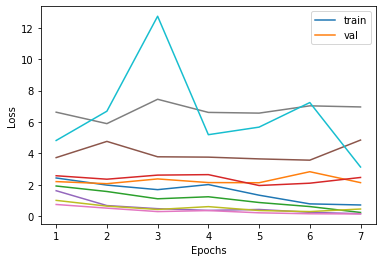

In [ ]:
from tqdm import tqdm
k = [0]
while len(k) != 0:
  model = models.vgg16(pretrained=True)
  model.classifier[6] = nn.Linear(4096,10)
  model.cuda()
  optimizer = optim.SGD(model.parameters(), lr=0.01)
  criterion = nn.CrossEntropyLoss()
  epochs = 7
  total_train_losses = []
  total_val_losses = []

  ff=open('{}/progress.txt'.format(save_folder),'w')

  for epoch in range(1,epochs+1):
      ##TRAINING##
      model.train()
      train_losses = []
      confusion_matrix.reset()

      for i, batch in enumerate(tqdm(train_dataloader)):
          img_batch, lbl_batch = batch
          img_batch, lbl_batch = img_batch.cuda(), lbl_batch.cuda()

          optimizer.zero_grad()
          output = model(img_batch.float())
          loss=criterion(output, lbl_batch.long())
          loss.backward()
          optimizer.step()

          train_losses.append(loss.item())
          confusion_matrix.add(output.data.squeeze(), lbl_batch.long())

          if i % 20 == 0:
              print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item()))
              
      train_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
      train_loss_mean = np.mean(train_losses)
      total_train_losses.append(train_loss_mean)
      

      ##VALIDATION##
      model.eval()
      val_losses = []

      for i, batch, in enumerate(tqdm(test_dataloader)):
          img_batch, lbl_batch = batch
          img_batch, lbl_batch = img_batch.cuda(), lbl_batch.cuda()
          outputs=model(img_batch.float())
          loss=criterion(outputs, lbl_batch.long())

          confusion_matrix.add(outputs.data.squeeze(), lbl_batch.long())
          val_losses.append(loss.item())

      print('Confusion Matrix:')
      print(confusion_matrix.conf)


      val_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
      val_loss_mean = np.mean(val_losses)
      total_val_losses.append(val_loss_mean)

      
      print('TRAIN_LOSS: ', '%.3f' % train_loss_mean, 'TRAIN_ACC: ', '%.3f' % train_acc)
      print('VAL_LOSS: ', '%.3f' % val_loss_mean, 'VAL_ACC: ', '%.3f' % val_acc)
      confusion_matrix.reset()

      write_results(save_folder, epoch, train_acc, val_acc, train_loss_mean, val_loss_mean)

      torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch))

  save_graph(total_train_losses, total_val_losses, epochs, save_folder)

  l = []
  val_d =[]
  for i, batch, in enumerate(tqdm(val_dataloader)):
          img_batch, lbl_batch = batch
          img_batch, lbl_batch = img_batch.cuda(), lbl_batch.cuda()
          outputs=model(img_batch.float())
          outputs = outputs.cpu()
          img_batch, lbl_batch = img_batch.cpu(), lbl_batch.cpu() 
          sm = torch.nn.Softmax()
          probabilities = sm(outputs) 
          top_p, top_class = probabilities.topk(1, dim = 1)
          for j in range(len(top_p)):
            if top_p[j] >= 0.995:
              l.append((img_batch[j], top_class[j]))
            else:
              val_d.append((img_batch[j], lbl_batch[j]))

  k = [(l[i][0], l[i][1].item()) for i in range(len(l))]
  r = [(val_d[i][0], val_d[i][1].item()) for i in range(len(val_d))]

  train_dataloader = torch.utils.data.DataLoader(torch.utils.data.ConcatDataset([train_dataset, k]), batch_size = 10)
  print(f"Added {len(k)} images to the training data")
  val_dataloader = torch.utils.data.DataLoader(dataset = r, batch_size = 10, shuffle = False)

  if len(r) <= 1000:
    break


# Each iteration had 7 epochs

| Model | Number of  epoch  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | 7 | 87.00 | 16.20 |